In [2]:
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import root
import astropy.constants as c
import math

In [3]:

spec_input = pd.read_table('/Users/afw2/BASTA/Paper1/data/basta_input_gaia_spec_gsp.ascii', delim_whitespace=True)
msc_input = pd.read_table('/Users/afw2/BASTA/Paper1/data/basta_input_gaia_spec.ascii',delim_whitespace=True)
pht_input = pd.read_table('/Users/afw2/BASTA/Paper1/data/basta_input_gaia_phot.ascii',delim_whitespace=True)

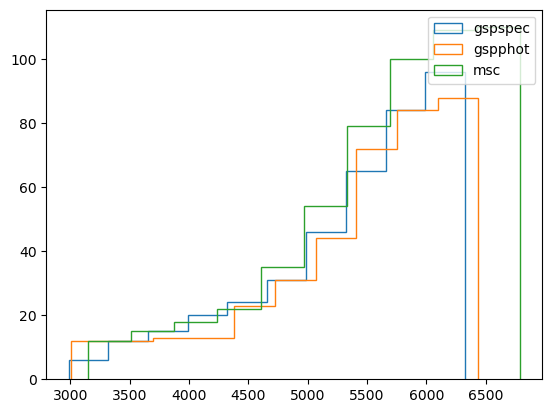

In [4]:
plt.hist(spec_input['Teff'], cumulative=True, histtype='step', label = 'gspspec')
plt.hist(pht_input['Teff'], cumulative=True, histtype='step', label = 'gspphot')
plt.hist(msc_input['Teff'], cumulative=True, histtype='step', label = 'msc')
plt.legend()
plt.show()

In [5]:
#read input and output files for the stars that have gaia and sweetcat spectroscopy

gaia_input = pd.read_table('/Users/afw2/BASTA/Paper1/data/basta_input_gaia_spec.ascii', delim_whitespace=True)
sc_input = pd.read_table('/Users/afw2/BASTA/Paper1/data/basta_input_sc.ascii',delim_whitespace=True)
nasa_input = pd.read_table('/Users/afw2/BASTA/Paper1/data/basta_input_nasa.ascii',delim_whitespace=True)

gaia_output  = pd.read_table('/Users/afw2/BASTA/Paper1/output/gaia_spec/results.ascii',delim_whitespace=True)
sc_output  = pd.read_table('/Users/afw2/BASTA/Paper1/output/sc/results.ascii',delim_whitespace=True)
nasa_output = pd.read_table('/Users/afw2/BASTA/Paper1/output/nasa/results.ascii', delim_whitespace=True)

nea_gaia_2m = pd.read_csv('/Users/afw2/BASTA/Paper1/data/gaia_phs_tm.csv')


In [6]:
#join everything together

joined_for_analysis = pd.merge(gaia_output, sc_output, on='#starid', suffixes = ('_gaia', '_sc'))
joined_for_analysis = pd.merge(nea_gaia_2m, joined_for_analysis, left_on='gaia_id', right_on='#starid')
final_idx = (joined_for_analysis['rv_flag']==1)*(joined_for_analysis['tran_flag']==1)*(joined_for_analysis['pl_bmassprov']=='Mass')*(joined_for_analysis['pl_rade']<=4)
intermediate = joined_for_analysis[final_idx]
error_cut_idx  = (intermediate['pl_bmasseerr1']/intermediate['pl_bmasse'] <= 0.25) * (intermediate['pl_radeerr1']/intermediate['pl_rade'] <= 0.25)
full_analysis = intermediate[error_cut_idx]

#This returns 181 planets, from the 80 stars we used
#For now, keeping the longer 181 planet dataframe in order to analyse all planet parameters
#however, apply small planet cut to remove larger planets!
#Therefore there are 87 planets :) - those other 100 or so are large planet companions which may be of interest for comparison later so keep this dataframe in mind
len(full_analysis)
print(type(nea_gaia_2m['gaia_id'][1]))


<class 'numpy.int64'>


In [7]:
nea_test = pd.read_csv('/Users/afw2/BASTA/Paper1/data/nea.csv')


def select_metallicity(table, met):
    if met == 'FeH':
        table = table[table['st_metratio']=='[Fe/H]']
    elif met == 'MH':
        table = table[table['st_metratio'] == '[M/H]']
    print(table['st_metratio'].str.contains("M"))



##test = select_metallicity(nea, met = 'FeH')
#print(len(nea_gaia_2m), len(test))

nea_test

/Users/afw2/.conda/envs/Galpy_first_look/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


pl_name pl_letter     hostname    hd_name hip_name         tic_id  \
0      Kepler-276 c         c   Kepler-276        NaN      NaN  TIC 138213510   
1      Kepler-829 b         b   Kepler-829        NaN      NaN  TIC 123451768   
2          K2-283 b         b       K2-283        NaN      NaN  TIC 266017624   
3          TrES-3 b         b       TrES-3        NaN      NaN  TIC 116264089   
4        TOI-1260 b         b     TOI-1260        NaN      NaN  TIC 355867695   
...             ...       ...          ...        ...      ...            ...   
4203     TOI-5542 b         b     TOI-5542        NaN      NaN  TIC 466206508   
4204    HD 184010 b         b    HD 184010  HD 184010      NaN  TIC 113329742   
4205    HD 184010 c         c    HD 184010  HD 184010      NaN  TIC 113329742   
4206      TOI-411 b         b      TOI-411        NaN      NaN  TIC 100990000   
4207  KIC 3526061 b         b  KIC 3526061        NaN      NaN  TIC 399793957   

     disc_pubdate  disc_year  discoverymethod disc_locale  ...  \
0         2014-02       2013          Transit       Space  ...   
1         2016-05       2016          Transit       Space  ...   
2         2018-12       2018          Transit       Space  ...   
3         2007-07       2007          Transit      Ground  ...   
4         2021-08       2021          Transit       Space  ...   
...           ...        ...              ...         ...  ...   
4203      2022-09       2022          Transit       Space  ...   
4204      2022-09       2022  Radial Velocity      Ground  ...   
4205      2022-09       2022  Radial Velocity      Ground  ...   
4206      2022-09       2022          Transit       Space  ...   
4207      2022-09       2022  Radial Velocity      Ground  ...   

                                          sy_pm_reflink    sy_pmra  \
0     <a refstr=STASSUN_ET_AL__2019 href=https://ui....    7.99553   
1     <a refstr=STASSUN_ET_AL__2019 href=https://ui....    7.93777   
2     <a refstr=STASSUN_ET_AL__2019 href=https://ui....  -10.97340   
3     <a refstr=STASSUN_ET_AL__2019 href=https://ui....  -24.52920   
4     <a refstr=STASSUN_ET_AL__2019 href=https://ui.... -177.23600   
...                                                 ...        ...   
4203  <a refstr=STASSUN_ET_AL__2019 href=https://ui....   -6.14486   
4204  <a refstr=STASSUN_ET_AL__2019 href=https://ui....   10.70890   
4205  <a refstr=STASSUN_ET_AL__2019 href=https://ui....   10.70890   
4206  <a refstr=STASSUN_ET_AL__2019 href=https://ui....  -51.66370   
4207  <a refstr=STASSUN_ET_AL__2019 href=https://ui....    7.63572   

     sy_pmraerr1 sy_pmraerr2                     sy_pmrastr         x  \
0       0.051581   -0.051581     7.9955300&plusmn;0.0515805  0.310575   
1       0.040833   -0.040833     7.9377700&plusmn;0.0408326  0.157566   
2       0.053624   -0.053624   -10.9734000&plusmn;0.0536244  0.959702   
3       0.037134   -0.037134   -24.5292000&plusmn;0.0371337 -0.027268   
4       0.036921   -0.036921  -177.2360000&plusmn;0.0369214 -0.376942   
...          ...         ...                            ...       ...   
4203    0.051566   -0.051566    -6.1448600&plusmn;0.0515661  0.261493   
4204    0.095601   -0.095601    10.7089000&plusmn;0.0956007  0.347024   
4205    0.095601   -0.095601    10.7089000&plusmn;0.0956007  0.347024   
4206    0.044345   -0.044345   -51.6637000&plusmn;0.0443452  0.422994   
4207    0.050710   -0.050710     7.6357200&plusmn;0.0507104  0.204695   

             y         z       htm20                sky_coord  
0    -0.711954  0.629813  1302657699    293.568197,39.0363123  
1    -0.720680  0.675124  -792260935   282.3328312,42.4638125  
2     0.224997  0.168368   609813555     13.1943679,9.6929181  
3    -0.792392  0.609403  1543705633   268.0291106,37.5463268  
4     0.158885  0.912507  -454174731   157.1440712,65.8541986  
...        ...       ...         ...                      ...  
4203 -0.405783 -0.875764  -801896825  302.7984228,-61.1354659  
4204 -0.823920  

In [8]:
nasa_analysis = pd.merge(nea_gaia_2m, nasa_output, left_on='gaia_id', right_on='#starid')
print(len(nasa_analysis))
final_idx = (nasa_analysis['rv_flag']==1)*(nasa_analysis['tran_flag']==1)*(nasa_analysis['pl_bmassprov']=='Mass')*(nasa_analysis['pl_rade']<=4)
intermediate = nasa_analysis[final_idx]
error_cut_idx  = (intermediate['pl_bmasseerr1']/intermediate['pl_bmasse'] <= 0.25) * (intermediate['pl_radeerr1']/intermediate['pl_rade'] <= 0.25)
nasa_analysis = intermediate[error_cut_idx]

#This returns 181 planets, from the 80 stars we used
#For now, keeping the longer 181 planet dataframe in order to analyse all planet parameters
#however, apply small planet cut to remove larger planets!
#Therefore there are 87 planets :) - those other 100 or so are large planet companions which may be of interest for comparison later so keep this dataframe in mind
len(nasa_analysis)

237


98

In [9]:
print(full_analysis.keys())

Index(['nea_dr3_tm_joiner_oid', 'gaia_id', 'ra_2_tm_join', 'dec_2_tm_join',
       'parallax_tm_join', 'original_ext_source_id', 'clean_tmass_psc_xsc_oid',
       'ra_tm', 'dec_tm', 'err_maj',
       ...
       'FeH_errp_sc', 'radPhot_sc', 'radPhot_errm_sc', 'radPhot_errp_sc',
       'massfin_sc', 'massfin_errm_sc', 'massfin_errp_sc', 'age_sc',
       'age_errm_sc', 'age_errp_sc'],
      dtype='object', length=593)


In [10]:
fontsize = 18

def plot_comparison(ax, var):
    ax.scatter(gaia_output[var], sc_output[var], s=2)
    gaia_range = max(gaia_output[var])-min(gaia_output[var])
    sc_range = max(sc_output[var])-min(sc_output[var])
    ax.set_ylabel('SweetCat')
    ax.axes.xaxis.set_visible(False)
    if 'Teff' in var:
        ax.set_title('Teff [K]')
    if 'FeH' in var:
        ax.set_title('FeH [dex]')
    if 'mass' in var:
        ax.set_title(r'Mass [M$_{\odot}$]')
    if 'rad' in var:
        ax.set_title(r'Radius [R$_{\odot}$]')
    if 'age' in var:
        ax.set_title(r'Age [Myr]')

def plot_residual(ax, var):
    residual = gaia_output[var] -  sc_output[var]
    ax.scatter(gaia_output[var], residual, s=2)
    ax.set_xlabel('Gaia')
    ax.set_ylabel('Gaia - SweetCat')
    gaia_range = max(gaia_output[var])-min(gaia_output[var])
    residual_range = max(residual) - min(residual)
    ax.set_aspect(gaia_range/(residual_range*4))

def plot(var):

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols = 1, sharex='all', figsize=(5,10))

    plt.subplots_adjust(hspace=0.1)
    plot_comparison(ax1, var)
    plot_residual(ax2, var)

    plt.show()

plot('Teff')
plot('FeH')
plot('radPhot')
plot('massfin')
plot('age')

ValueError: x and y must be the same size

In [11]:
def plot_comparison(ax, var):
    ax.scatter(nasa_output[var], sc_output[var], s=2)
    gaia_range = max(nasa_output[var])-min(nasa_output[var])
    sc_range = max(sc_output[var])-min(sc_output[var])
    ax.set_ylabel('SweetCat')
    ax.axes.xaxis.set_visible(False)
    if 'Teff' in var:
        ax.set_title('Teff [K]')
    if 'FeH' in var:
        ax.set_title('FeH [dex]')
    if 'mass' in var:
        ax.set_title(r'Mass [M$_{\odot}$]')
    if 'rad' in var:
        ax.set_title(r'Radius [R$_{\odot}$]')
    if 'age' in var:
        ax.set_title(r'Age [Myr]')

def plot_residual(ax, var):
    residual = nasa_output[var] -  sc_output[var]
    ax.scatter(nasa_output[var], residual, s=2)
    ax.set_xlabel('NASA')
    ax.set_ylabel('NASA- SweetCat')
    range = max(nasa_output[var])-min(gaia_output[var])
    residual_range = max(residual) - min(residual)
    ax.set_aspect(range/(residual_range*4))

def plot(var):

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols = 1, sharex='all', figsize=(5,10))

    plt.subplots_adjust(hspace=0.1)
    plot_comparison(ax1, var)
    plot_residual(ax2, var)

    plt.show()

plot('Teff')
plot('FeH')
plot('radPhot')
plot('massfin')
plot('age')

ValueError: x and y must be the same size

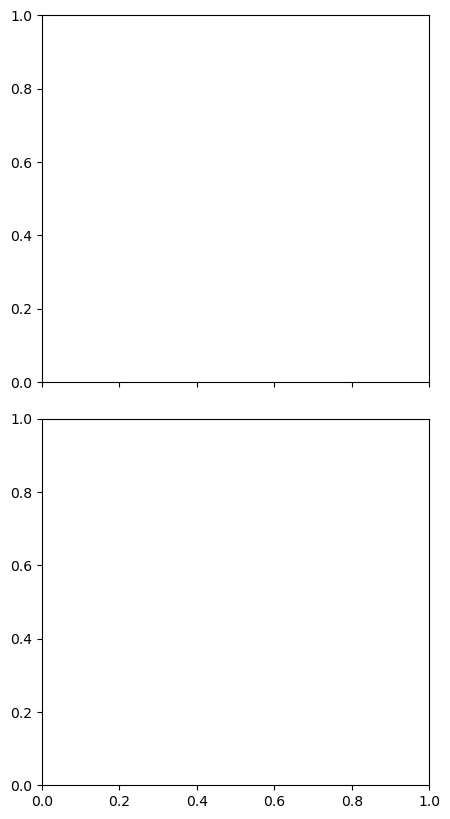

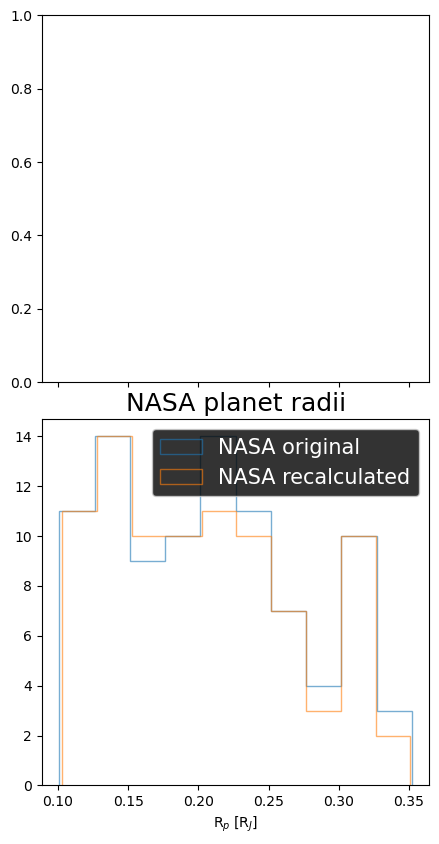

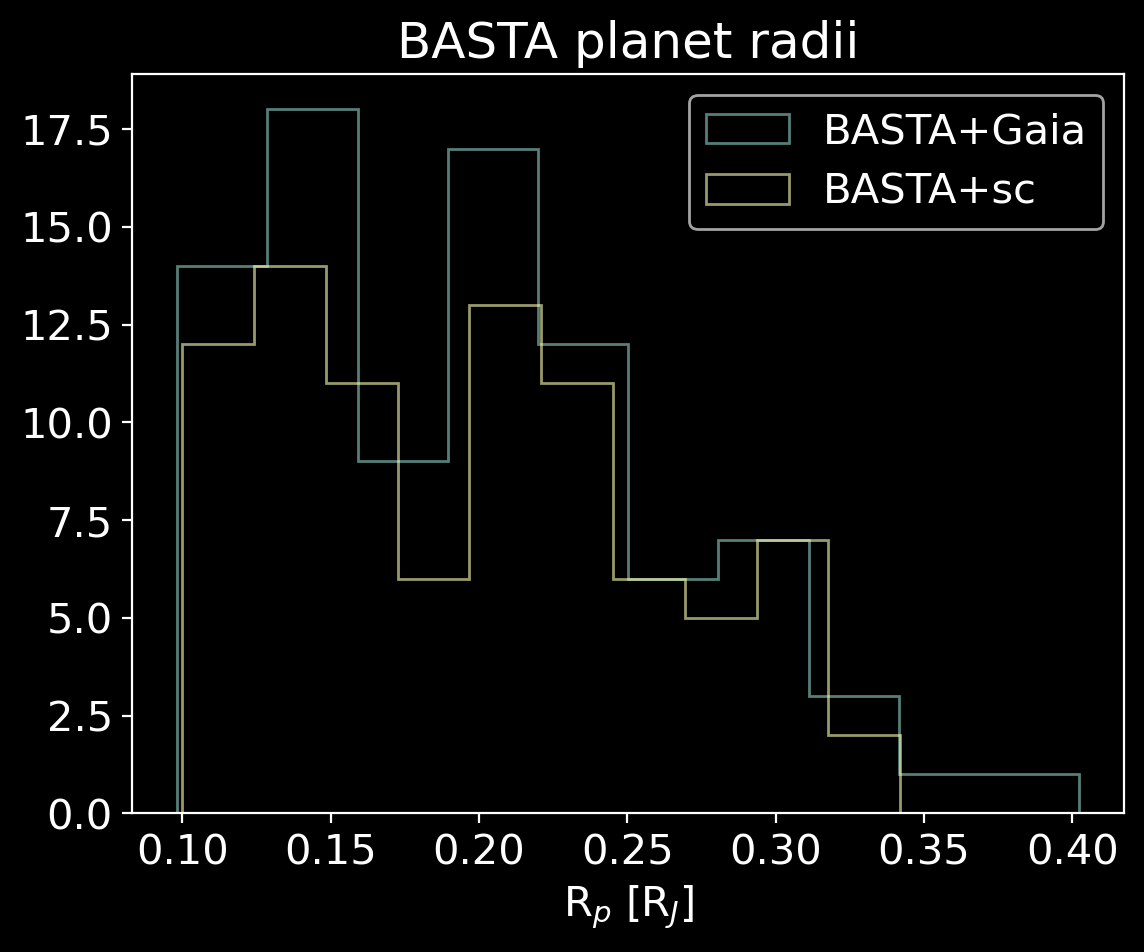

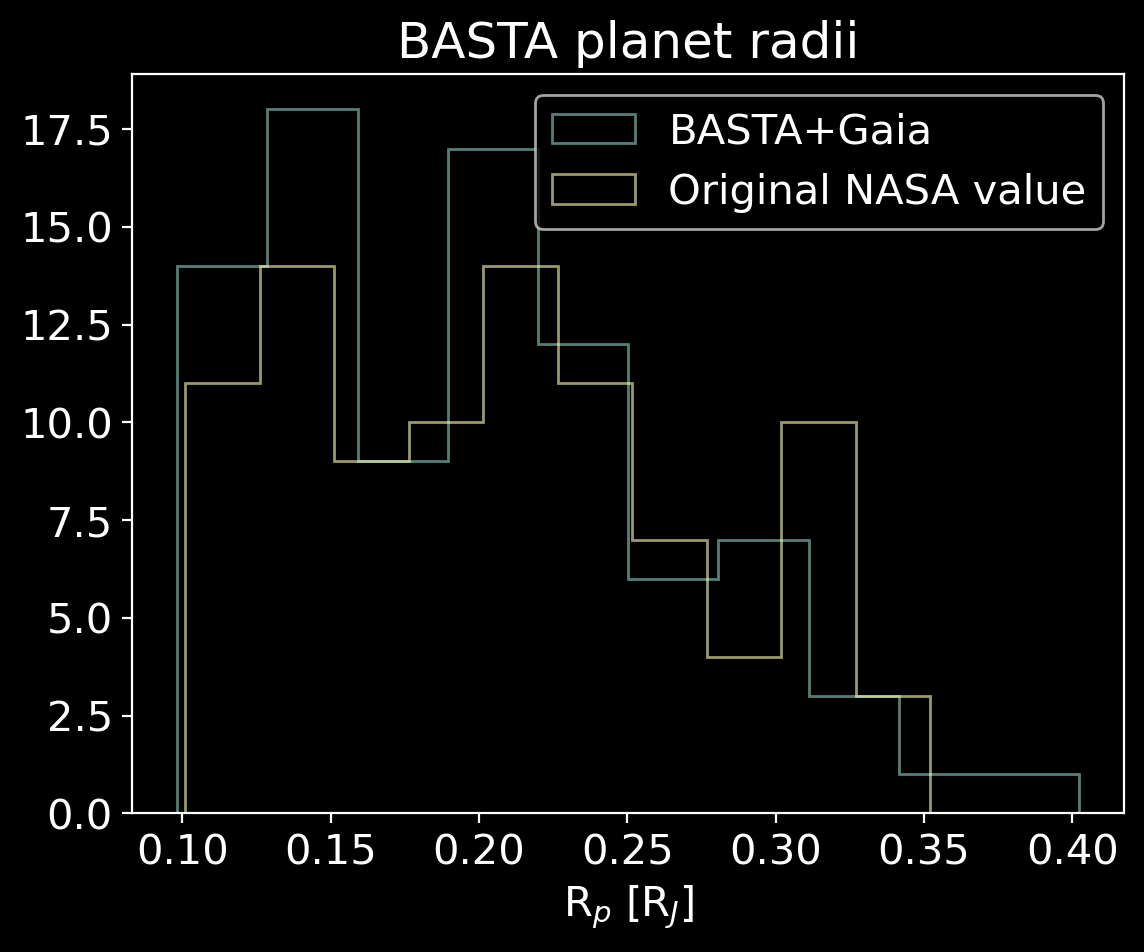

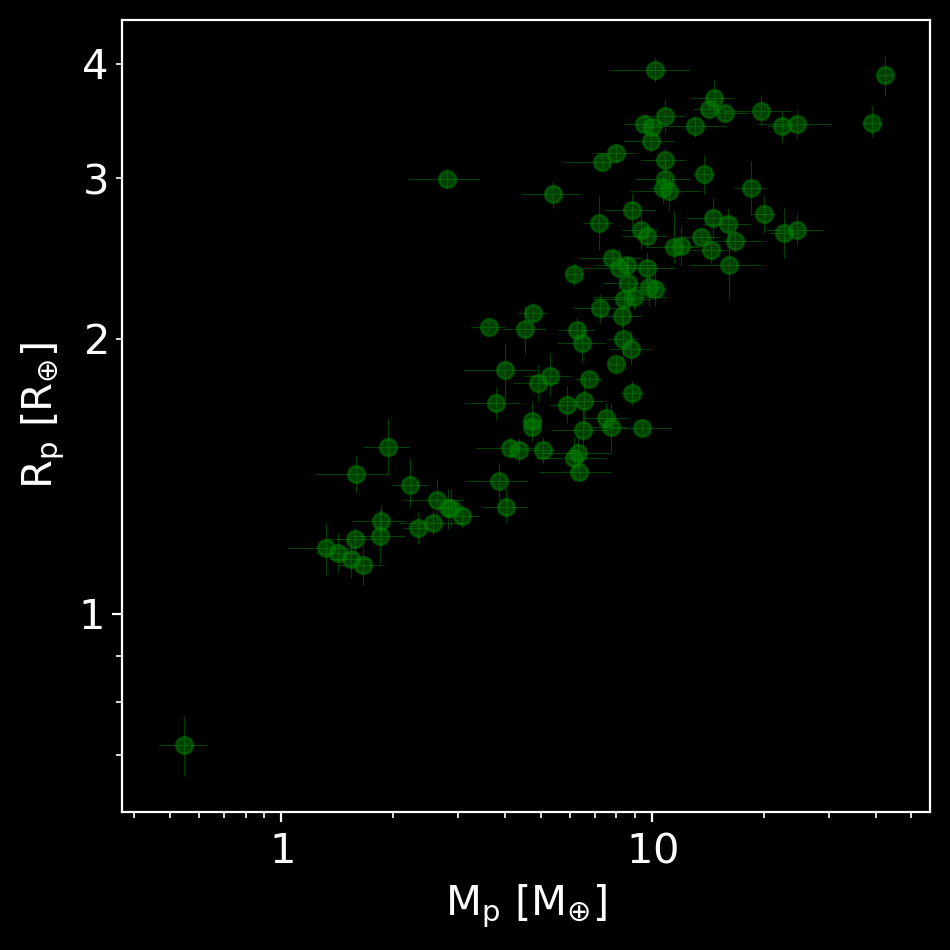

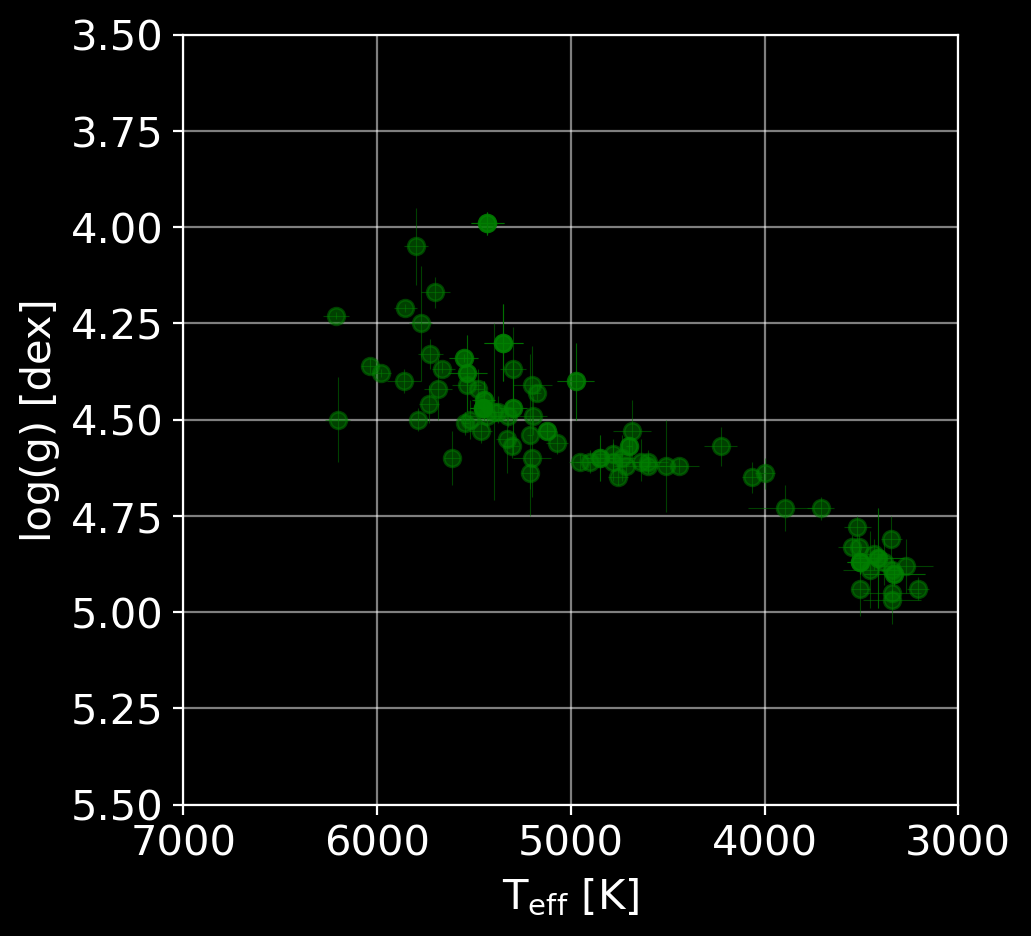

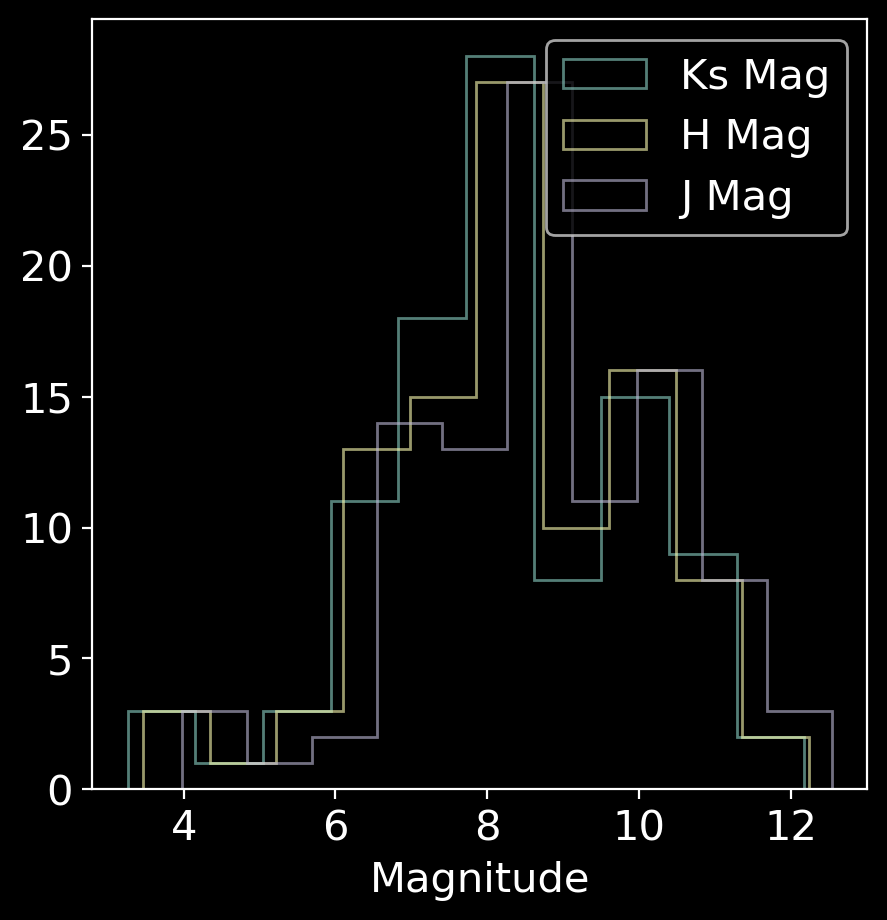

In [12]:
#now rejoin tp full planet table for all planet paramteres to be compared
#also recalculate new planet parameters
#also compare stellar parameters to  NASA stellar parameters

plt.style.use('dark_background')
dpi=200
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi

full_analysis.keys()
#calculating new planet mass and radius from the gaia and sweetcat produced results from BASTA
import astropy.constants as c

rj = c.R_jup
rs = c.R_sun
plt.rcParams.update({'font.size': 15})

plt.rcParams['axes.formatter.min_exponent'] = 4
#normalising constant
r_norm = rs / rj

incl = full_analysis['pl_orbincl']
ecc = full_analysis['pl_orbeccen']
p = full_analysis['pl_orbper']

rat = full_analysis['pl_ratror']
r_first = full_analysis['pl_radj']
r_1 = (rat * full_analysis['st_rad']) * r_norm
r_basta_gaia = (rat * full_analysis['radPhot_gaia']) * r_norm
r_basta_sc = (rat * full_analysis['radPhot_sc']) * r_norm

plt.hist(r_first, label='NASA original', alpha=0.6, histtype='step')
plt.hist(r_1, label='NASA recalculated', alpha=0.6, histtype='step')
plt.xlabel(r'R$_p$ [R$_J$]')
plt.title('NASA planet radii')


plt.legend()
plt.savefig('/Users/afw2/BASTA/Paper1/figures/nasa_planet_radii.jpg')
plt.show()

plt.hist(r_basta_gaia, label='BASTA+Gaia', alpha=0.6,  histtype='step')
plt.xlabel(r'R$_p$ [R$_J$]')
plt.hist(r_basta_sc, label='BASTA+sc', alpha=0.6,  histtype='step')
plt.xlabel(r'R$_p$ [R$_J$]')
plt.title('BASTA planet radii')

plt.legend()

plt.savefig('/Users/afw2/BASTA/Paper1/figures/basta_planet_radii.jpg')
plt.show()


plt.hist(r_basta_gaia, label='BASTA+Gaia', alpha=0.6,  histtype='step')
plt.xlabel(r'R$_p$ [R$_J$]')
plt.hist(r_first, label='Original NASA value', alpha=0.6,  histtype='step')
plt.xlabel(r'R$_p$ [R$_J$]')
plt.title('BASTA planet radii')

plt.legend()

plt.savefig('/Users/afw2/BASTA/Paper1/figures/nasa_basta_planet_radii.jpg')
plt.show()

xerr = [-nasa_analysis['pl_bmasseerr2'], nasa_analysis['pl_bmasseerr1']]
yerr = [-nasa_analysis['pl_radeerr2'], nasa_analysis['pl_radeerr1']]


plt.figure(figsize=(5,5))
plt.errorbar(nasa_analysis['pl_bmasse'], nasa_analysis['pl_rade'], fmt = 'o', c='green', xerr=xerr, yerr=yerr, alpha=0.5, elinewidth=0.4)
plt.loglog()
plt.ylabel(r'R$_{\rm{p}}$ [R$_{\oplus}$]')
plt.xlabel(r'M$_{\rm{p}}$ [M$_{\oplus}$]')
plt.tight_layout()

plt.savefig('/Users/afw2/BASTA/Paper1/figures/massradinit.jpg')


plt.show()

xerr = [-nasa_analysis['st_tefferr2'], nasa_analysis['st_tefferr1']]
yerr = [-nasa_analysis['st_loggerr2'], nasa_analysis['st_loggerr1']]


plt.figure(figsize=(5,5))
nasa_analysis = nasa_analysis.drop_duplicates(subset='pl_name')
plt.errorbar(nasa_analysis['st_teff'], nasa_analysis['st_logg'], fmt = 'o', c='green', xerr=xerr, yerr=yerr, alpha=0.5, elinewidth=0.4)

plt.xlabel(r'T$_{\rm{eff}}$ [K]')
plt.ylabel(r'log(g) [dex]')


plt.grid(alpha=0.5)
plt.xlim(7000,3000)
plt.ylim(5.5,3.5)



plt.savefig('/Users/afw2/BASTA/Paper1/figures/kiel.jpg')
plt.show()


plt.figure(figsize=(5,5))
plt.hist(nasa_analysis['ks_m'], label='Ks Mag', alpha=0.6,  histtype='step')
plt.hist(nasa_analysis['h_m'], label='H Mag', alpha=0.6,  histtype='step')
plt.hist(nasa_analysis['j_m'], label='J Mag', alpha=0.6,  histtype='step')


plt.xlabel(r'Magnitude')
plt.savefig('/Users/afw2/BASTA/Paper1/figures/magnitude.jpg')



plt.legend()
plt.show()

In [13]:
nasa_analysis['st_spectype']

3         G8 V
7         G5 V
9      G8 IV/V
10     G8 IV/V
11     G8 IV/V
        ...   
230       K4 V
231          G
234        NaN
235        NaN
236     K3.5 V
Name: st_spectype, Length: 98, dtype: object

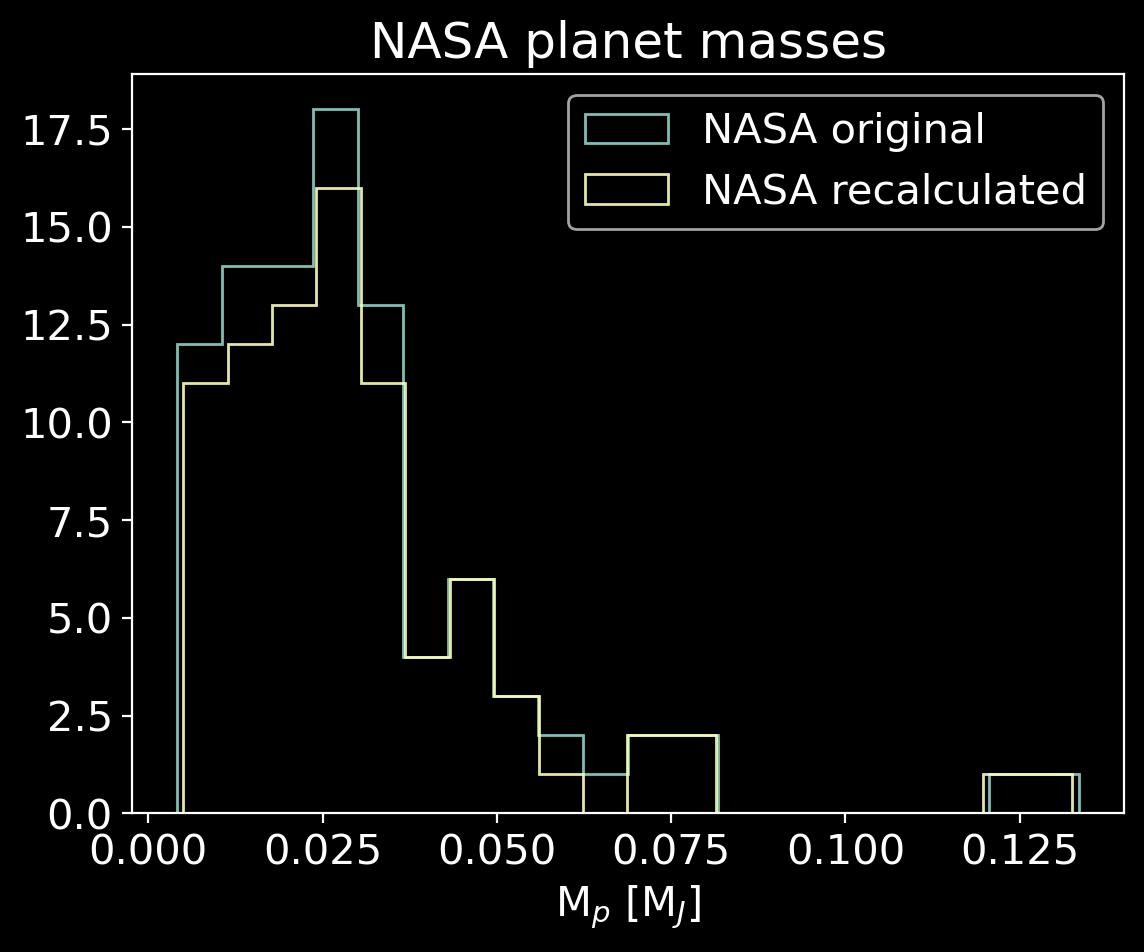

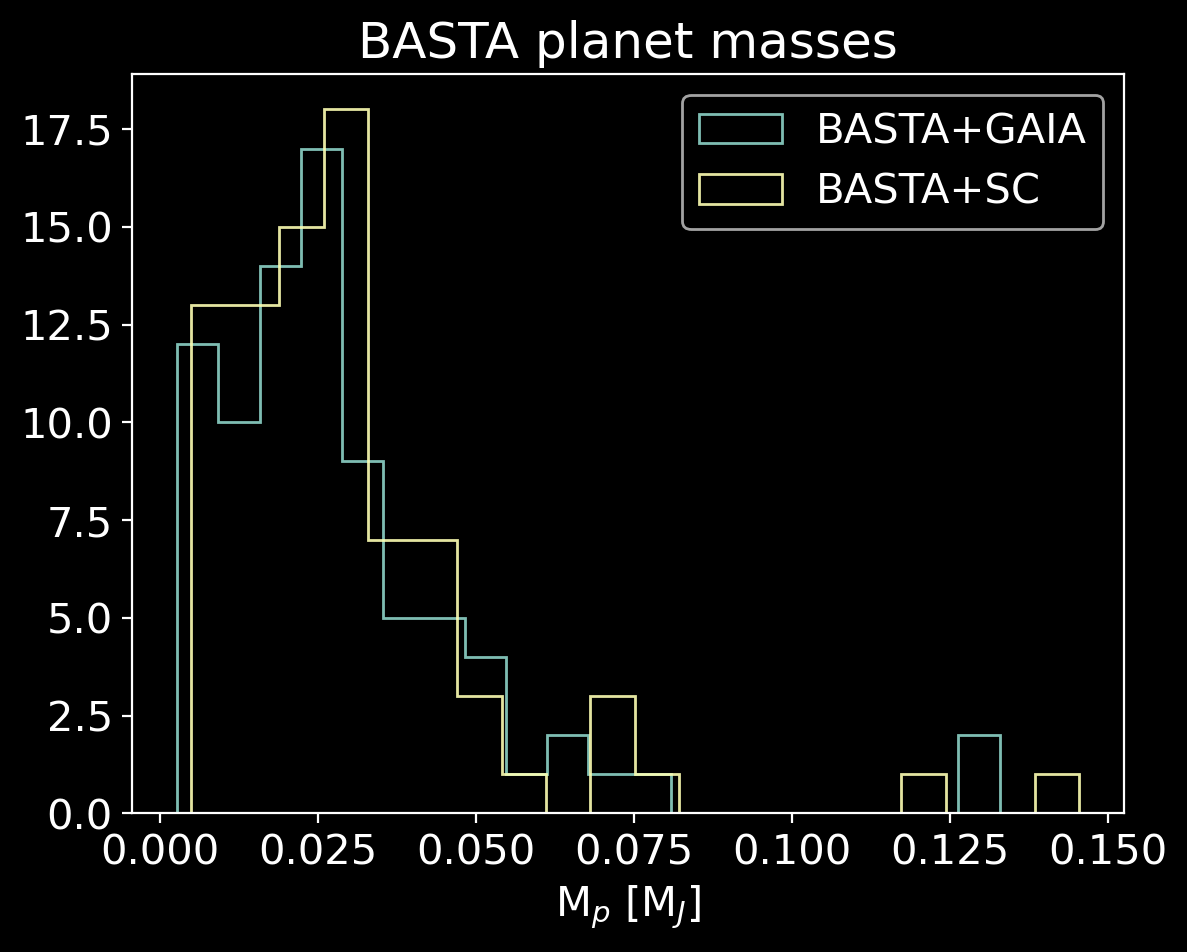

3      0.024112
10     0.024495
12     0.028236
13     0.047398
14     0.033299
         ...   
227         NaN
228    0.128990
231    0.041314
232    0.019624
233         NaN
Name: pl_orbincl, Length: 93, dtype: float64


In [14]:


def planet_mass(m_star, Msini_units='earth'):
    #stole this from radvel - maybe recalculate
    """Calculate Msini

    Calculate Msini for a given K, P, stellar mass, and e

    Args:
        K (float or array: Doppler semi-amplitude [m/s]
        P (float or array): Orbital period [days]
        Mstar (float or array): Mass of star [Msun]
        e (float or array): eccentricity
        Msini_units (Optional[str]): Units of Msini {'earth','jupiter'}
            default: 'earth'

    Returns:
        float or array: Msini [units = Msini_units]

    """

    # convert inputs to array so they work with units
    P = np.array(full_analysis['pl_orbper'])
    Mstar = np.array(m_star)
    K = np.array(full_analysis['pl_rvamp'])
    e = np.array(full_analysis['pl_orbeccen'])
    G = c.G.value                # added gravitational constant
    Mjup = c.M_jup.value         # added Jupiter's mass
    Msun = c.M_sun.value         # added sun's mass
    Mstar = Mstar*Msun
    Mstar = np.array(Mstar)
    K_0 = 28.4329

    P_year = (P * u.d).to(u.year).value
    P = (P * u.d).to(u.second).value

    # First assume that Mp << Mstar
    Msini = K / K_0 * np.sqrt(1.0 - e ** 2.0) * (Mstar/Msun) ** (2.0 / 3.0) * P_year ** (1 / 3.0)

    # Use correct calculation if any elements are >10% of the stellar mass
    if (np.array(((Msini * u.Mjup).to(u.M_sun) / (Mstar/Msun)).value > 0.10)).any():
        warnings.warn("Mpsini << Mstar assumption broken, correcting Msini calculation.")

        a = K*(((2*(np.pi)*G)/P)**(-1/3.))*np.sqrt(1-(e**2))
        Msini = []
        if isinstance(P, float):
            n_elements = 1
        else:
            assert type(K) == type(P) == type(Mstar) == type(e), "All input data types must match."
            assert K.size == P.size == Mstar.size == e.size, "All input arrays must have the same length."
            n_elements = len(P)
        for i in range(n_elements):
            def func(x):
                try:
                    return x - a[i]*((Mstar[i]+x)**(2/3.))
                except IndexError:
                    return x - a * ((Mstar + x) ** (2 / 3.))

            sol = root(func, Mjup)
            Msini.append(sol.x[0])

        Msini = np.array(Msini)
        Msini = Msini/Mjup

    if Msini_units.lower() == 'jupiter':
        pass
    elif Msini_units.lower() == 'earth':
        Msini = (Msini * u.M_jup).to(u.M_earth).value
    else:
        raise Exception("Msini_units must be 'earth', or 'jupiter'")


    mp_recalc = Msini / np.sin(np.deg2rad(incl))

    return mp_recalc

mp_recalc = planet_mass(full_analysis['st_mass'], Msini_units='jupiter')
mp_basta_gaia =  planet_mass(full_analysis['massfin_gaia'], Msini_units='jupiter')
mp_basta_sc =  planet_mass(full_analysis['massfin_sc'], Msini_units='jupiter')

#assumption = 4.191e-3 * full_analysis['st_mass'] ** (2 / 3) * p ** (1 / 3) * k * np.sqrt(1 - ecc ** 2) * 1 / (np.sin(np.deg2rad(incl)))
#mp_basta_gaia = 4.191e-3 * full_analysis['massfin_gaia'] ** (2 / 3) * p ** (1 / 3) * k * np.sqrt(1 - ecc ** 2) * 1 / (np.sin(incl))
#mp_basta_sc = 4.191e-3 * full_analysis['massfin_sc'] ** (2 / 3) * p ** (1 / 3) * k * np.sqrt(1 - ecc ** 2) * 1 / (np.sin(incl))

mp = full_analysis['pl_bmassj']

plt.hist(mp, label='NASA original', alpha=0.9, bins=20, histtype = 'step')
plt.hist(mp_recalc, label='NASA recalculated', alpha=0.9, bins=20, histtype = 'step')
plt.title('NASA planet masses')
plt.xlabel(r'M$_p$ [M$_J$]')
plt.legend()


plt.savefig('/Users/afw2/BASTA/Paper1/figures/nasa_planet_masses.jpg')

plt.show()
plt.hist(mp_basta_gaia, label='BASTA+GAIA', alpha=0.9, bins=20, histtype = 'step')
plt.hist(mp_basta_sc, label='BASTA+SC', alpha=0.9, bins=20, histtype = 'step')
plt.title('BASTA planet masses')
plt.xlabel(r'M$_p$ [M$_J$]')
plt.legend()


plt.savefig('/Users/afw2/BASTA/Paper1/figures/basta_planet_masses.jpg')




#plt.hist(mp_basta_gaia, label='BASTA+Gaia', alpha=0.4)
#plt.hist(mp_basta_sc, label='BASTA+sc', alpha=0.4)

#plt.legend()
plt.show()
print(mp_basta_gaia)

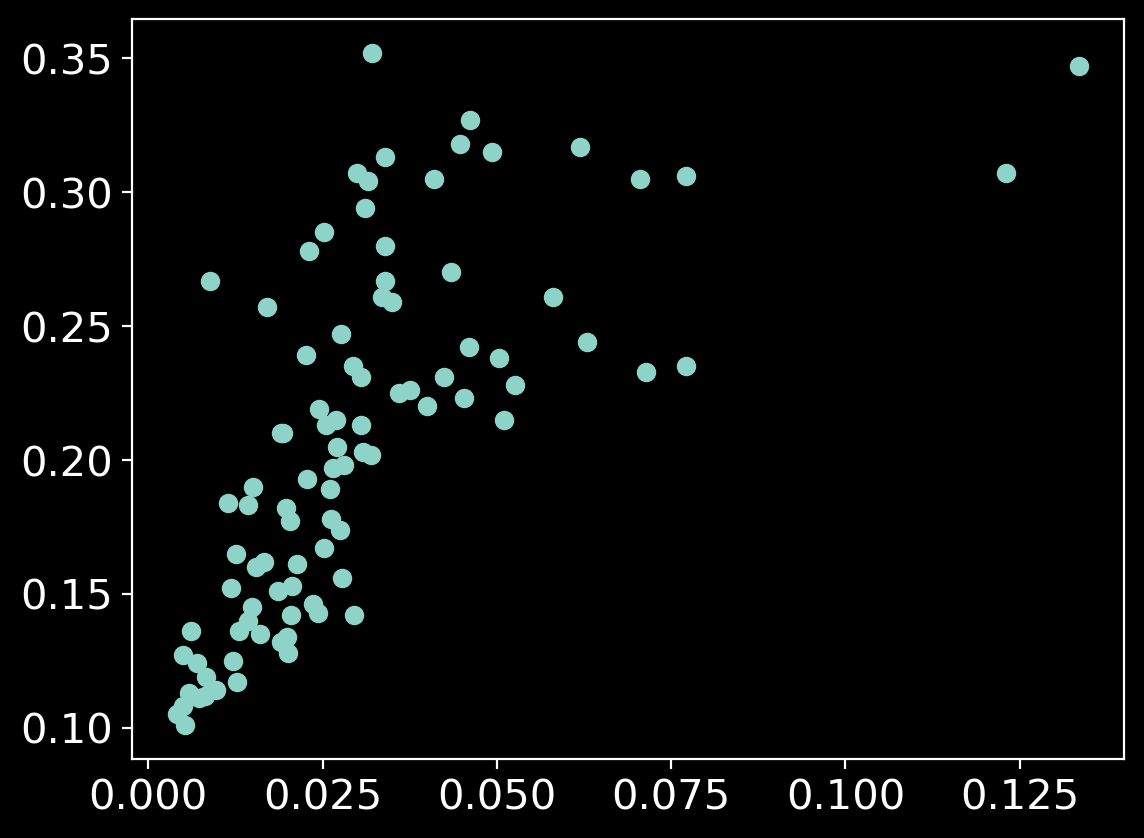

In [15]:
fig, ax = plt.subplots(1)

ax.scatter(mp, r_first)
plt.show()

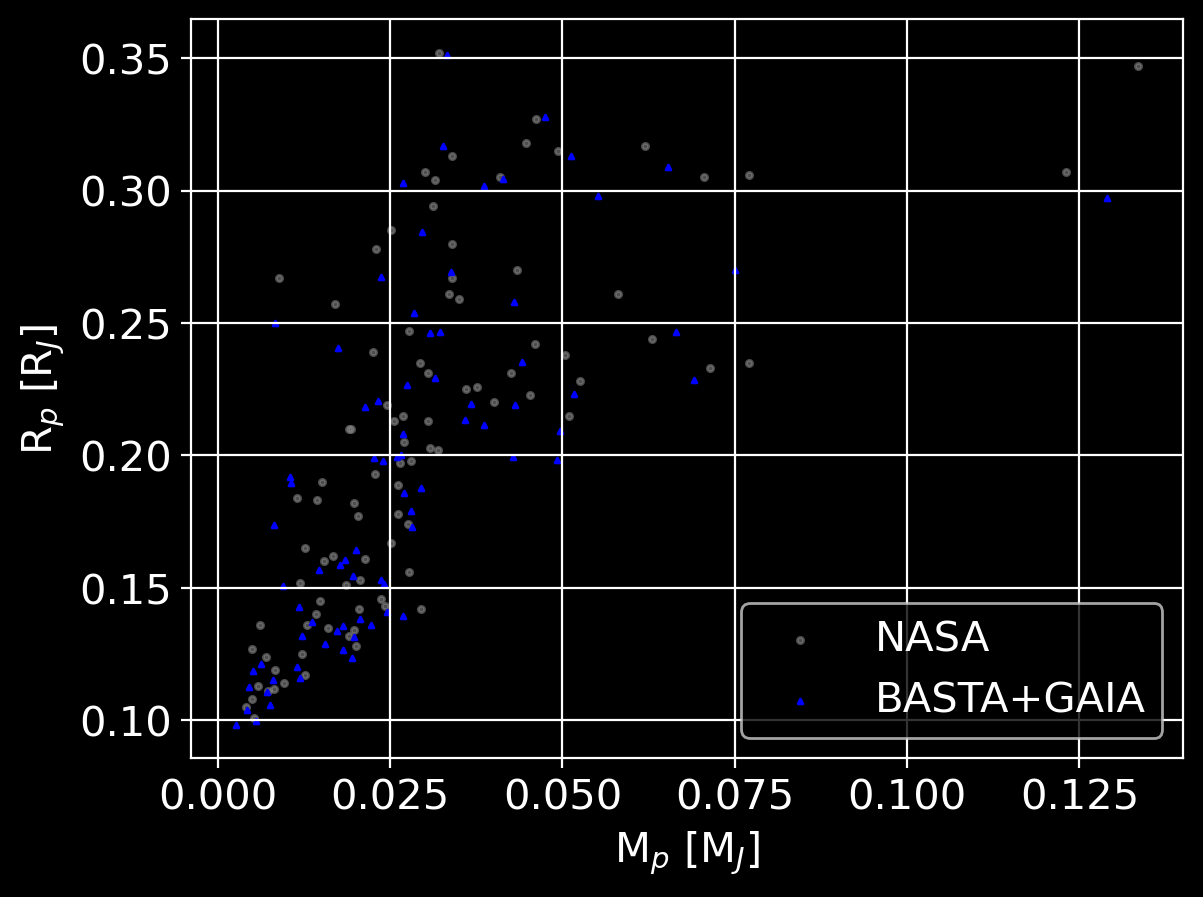

93 93 93 93 93 93


5.7

In [16]:
#plotting planet paramters for comparison

mass = np.array(full_analysis['pl_bmassj'])
rad = np.array(full_analysis['pl_radj'])

masserr = np.array([full_analysis['pl_bmasseerr2'],full_analysis['pl_bmasseerr1']])
raderr = np.array([full_analysis['pl_radeerr2'],full_analysis['pl_radeerr1']])

mass_gaia = np.array(mp_basta_gaia)
rad_gaia = np.array(r_basta_gaia)

masserr_gaia = np.array([full_analysis['pl_bmasseerr2'],full_analysis['pl_bmasseerr1']])
raderr_gaia = np.array([full_analysis['pl_radeerr2'],full_analysis['pl_radeerr1']])


mass_sc = mp_basta_sc
rad_sc = r_basta_sc

masserr_sc = np.array([full_analysis['pl_bmasseerr2'],full_analysis['pl_bmasseerr1']])
raderr_sc = np.array([full_analysis['pl_radeerr2'],full_analysis['pl_radeerr1']])

#ax1 = full_analysis.plot(kind='scatter', x='pl_bmasse', y='pl_rade', xerr = masserr, yerr = raderr, s=2, c='r')
#ax2 = full_analysis.plot(kind='scatter', x='pl_bmasse', y='pl_rade',  s=2)
#ax3 = full_analysis.plot(kind='scatter', x='pl_bmasse', y='pl_rade',  s=2)

ax1 = plt.scatter(mass, rad, s=5, c='grey', alpha = 0.6, label = 'NASA')
ax2 = plt.scatter(mass_gaia, rad_gaia, s=3, c='b', marker = '^', label = 'BASTA+GAIA')
#ax3 = plt.scatter(mass_sc, rad_sc, s=3, c='gold', marker = '^', label = 'BASTA+SC')



plt.xlabel(r'M$_p$ [M$_J$]')
plt.ylabel(r'R$_p$ [R$_J$]')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

print(len(mass), len(rad), len(mass_gaia), len(rad_gaia), len(mass_sc), len(rad_gaia))
max(full_analysis['pl_bmasseerr1'])

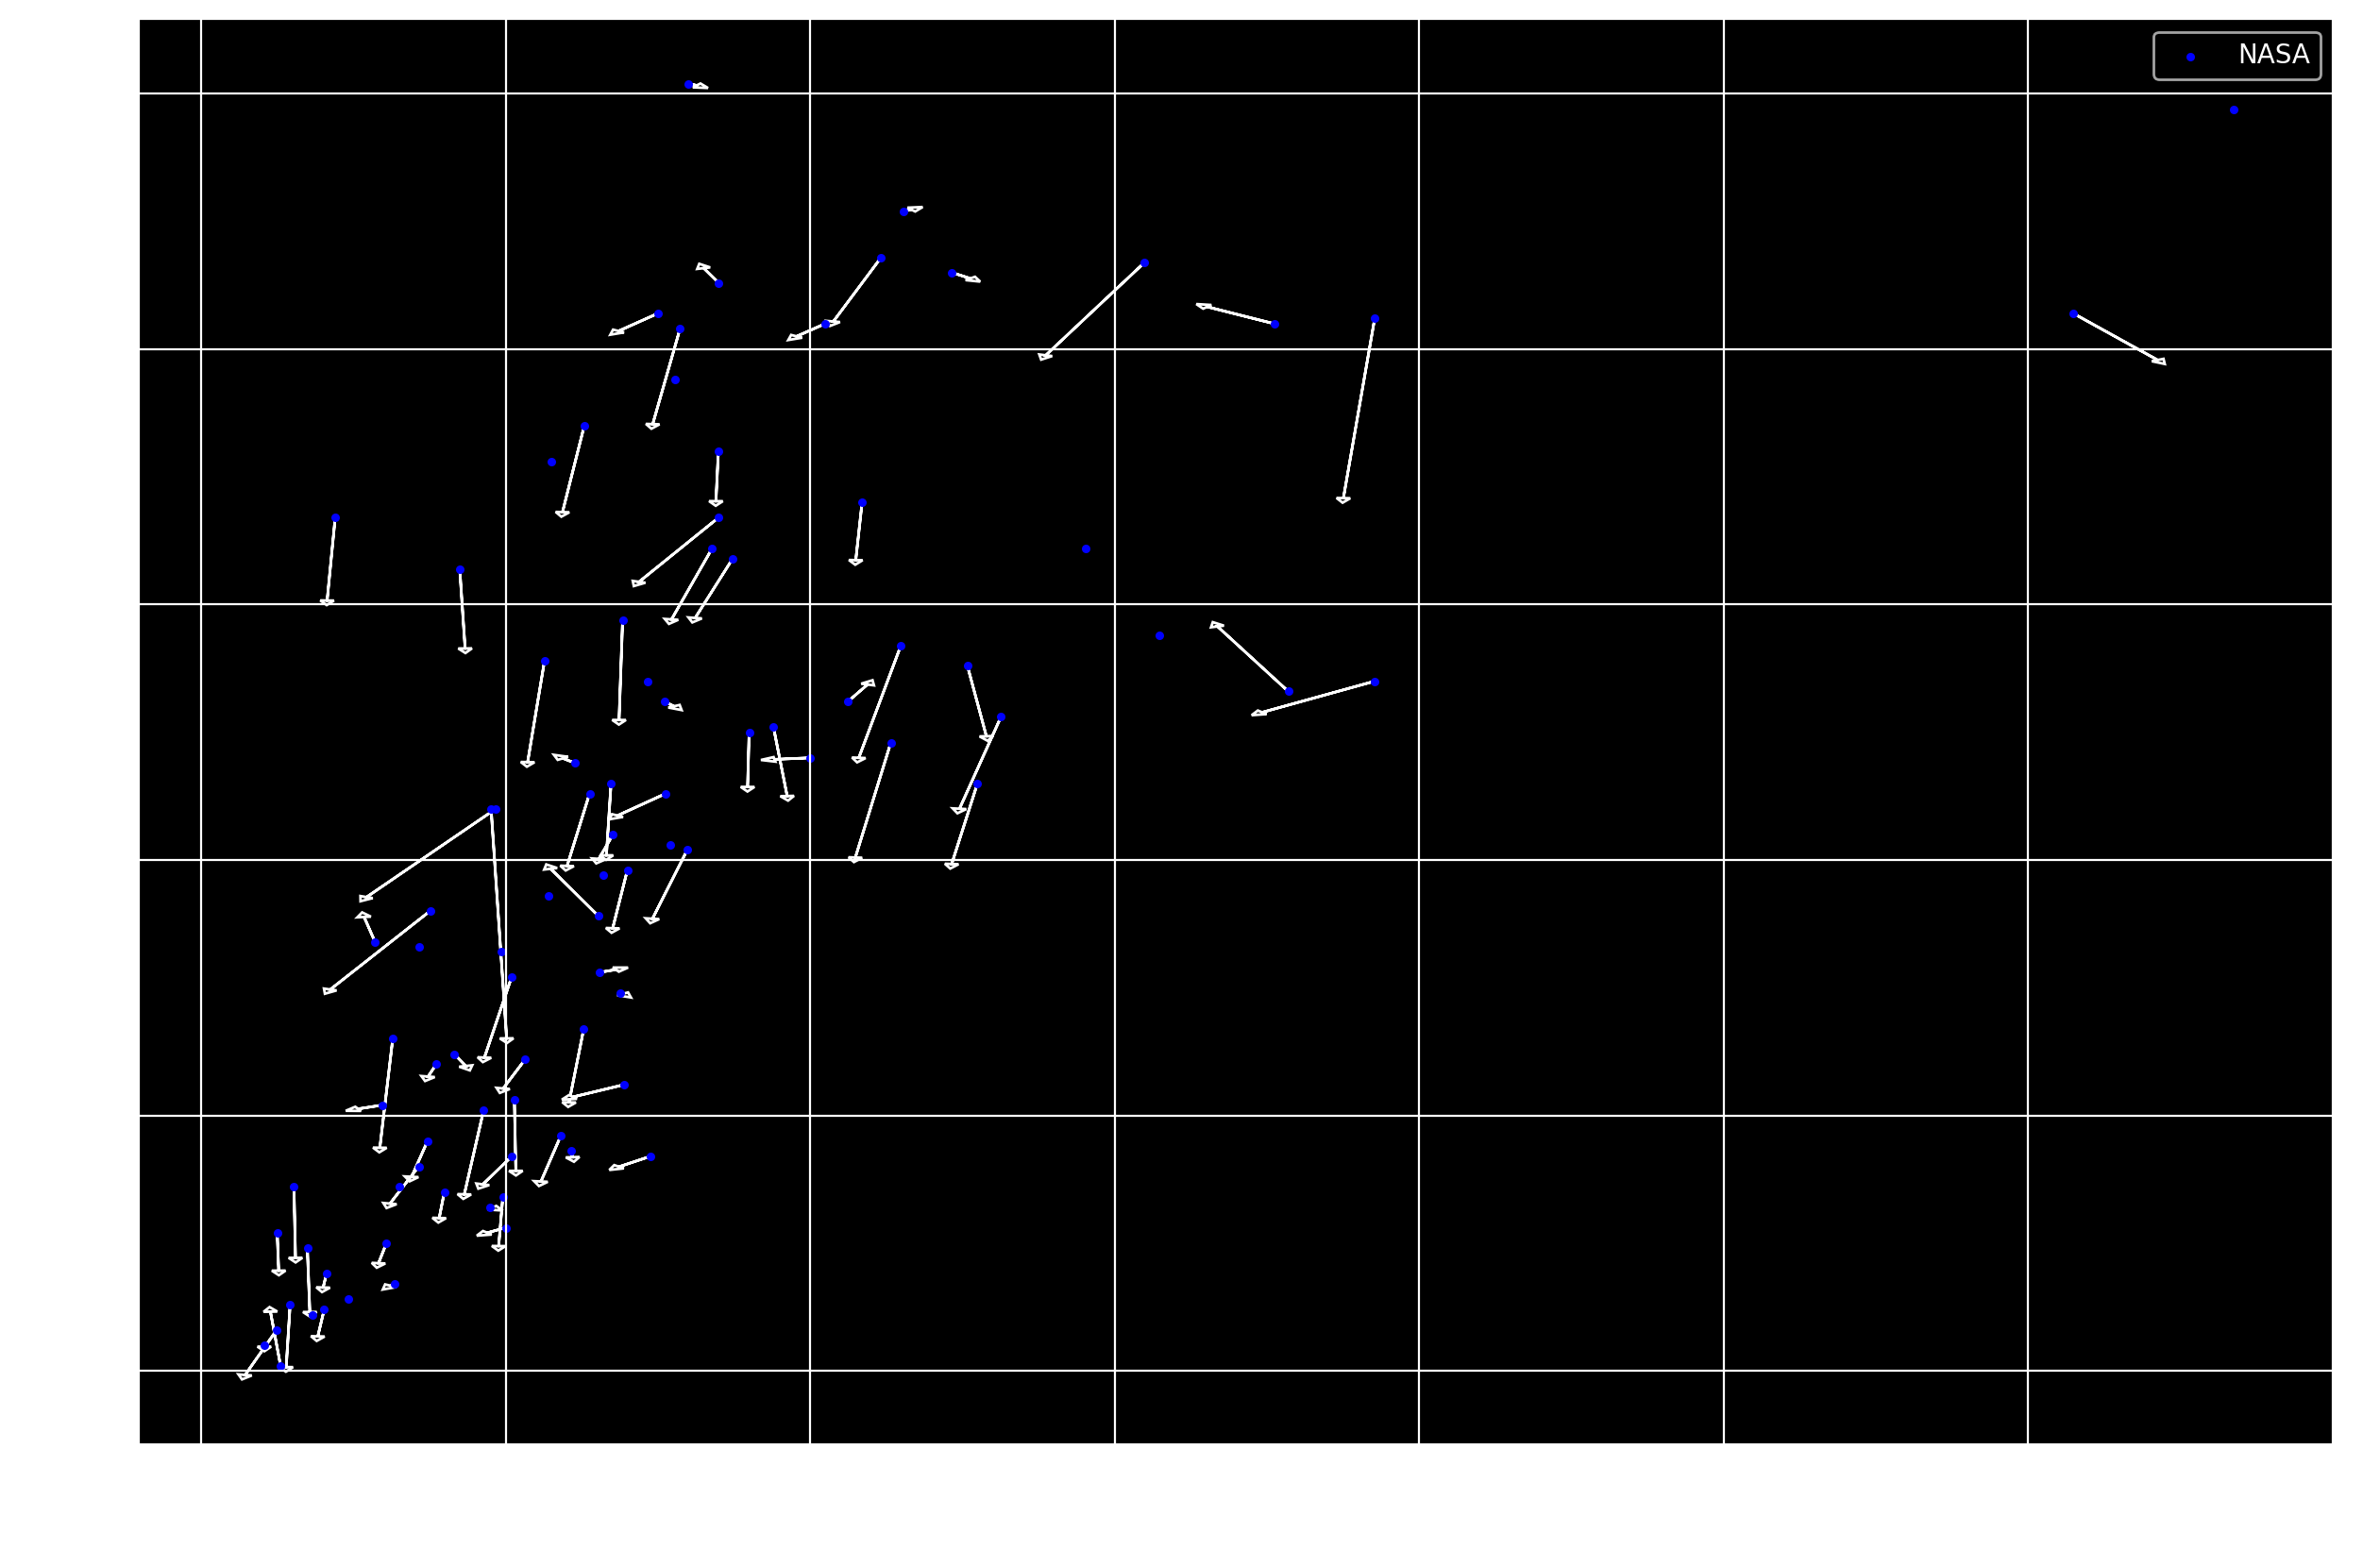

93 93 93 93 93 93


In [17]:
%matplotlib inline
dpi=200
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi

#ax1 = plt.scatter(mass, rad, s=5, c='grey', alpha = 0.6, label = 'NASA')
#ax2 = plt.scatter(mass_gaia, rad_gaia, s=3, c='b', marker = '^', label = 'BASTA+GAIA')
#ax3 = plt.scatter(mass_sc, rad_sc, s=3, c='gold', marker = '^', label = 'BASTA+SC')
fig, ax = plt.subplots(figsize=(15,10))
plt.grid(True)
for i in range(len(mass)):
    plt.arrow(x=mass[i],y=rad[i], dx=(mass_gaia[i]-mass[i]), dy=(rad_gaia[i]-rad[i]), width=.000001,length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', head_starts_at_zero=False)

#plt.scatter(mass_gaia, rad_gaia, s=20, c='gold', marker = '^', label = 'BASTA+SC')
plt.scatter(mass, rad, s=5, c='blue', marker = 'o', label = 'NASA')



plt.xlabel(r'M$_p$ [M$_J$]')
plt.ylabel(r'R$_p$ [R$_J$]')#plt.xscale('log')
#plt.yscale('log')
plt.legend()

plt.show()

print(len(mass), len(rad), len(mass_gaia), len(rad_gaia), len(mass_sc), len(rad_gaia))


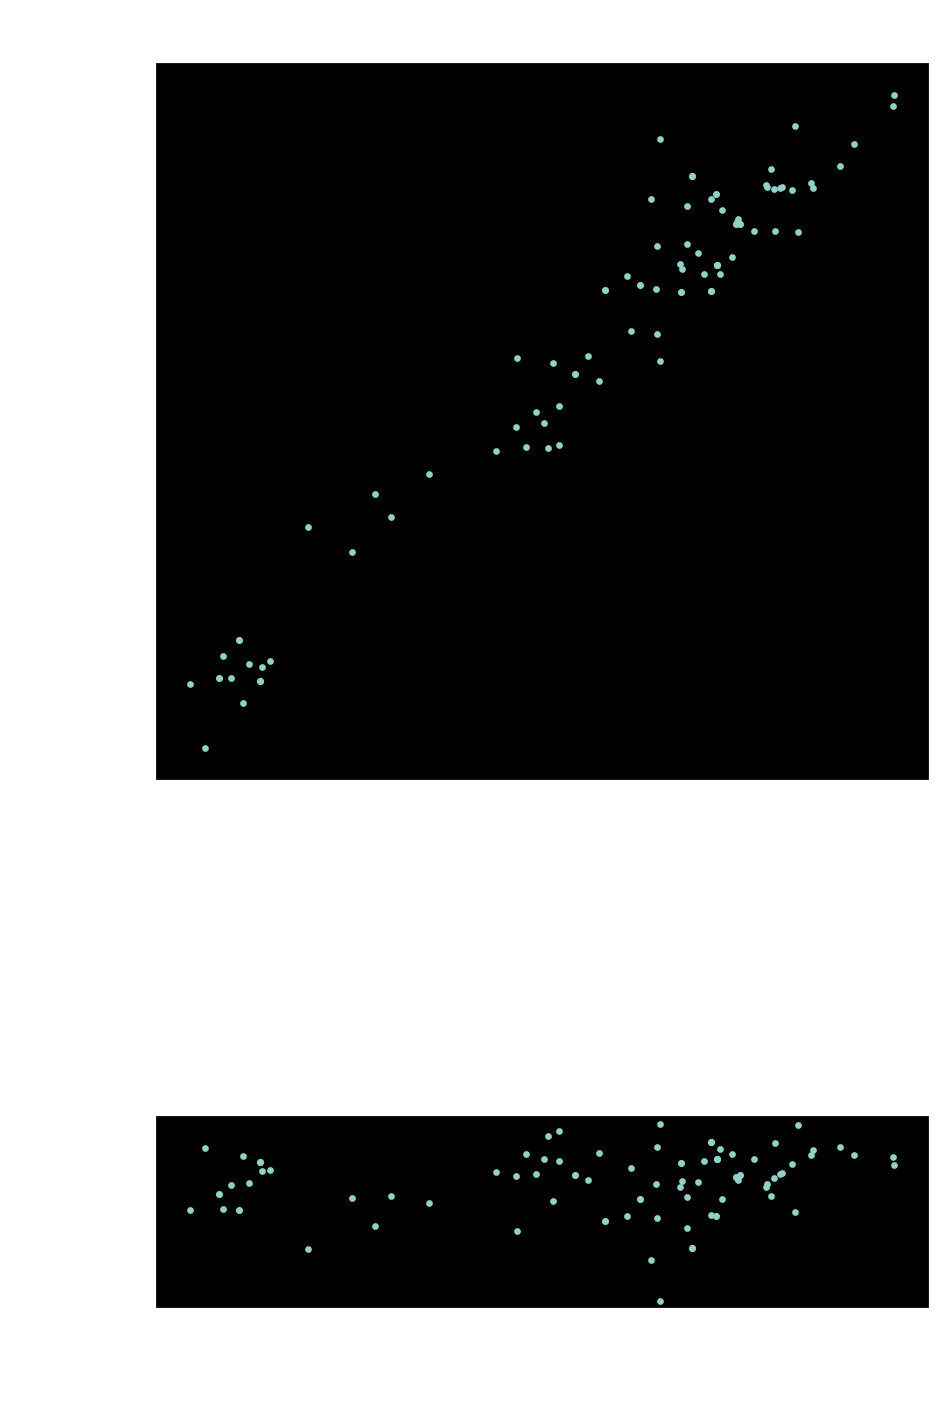

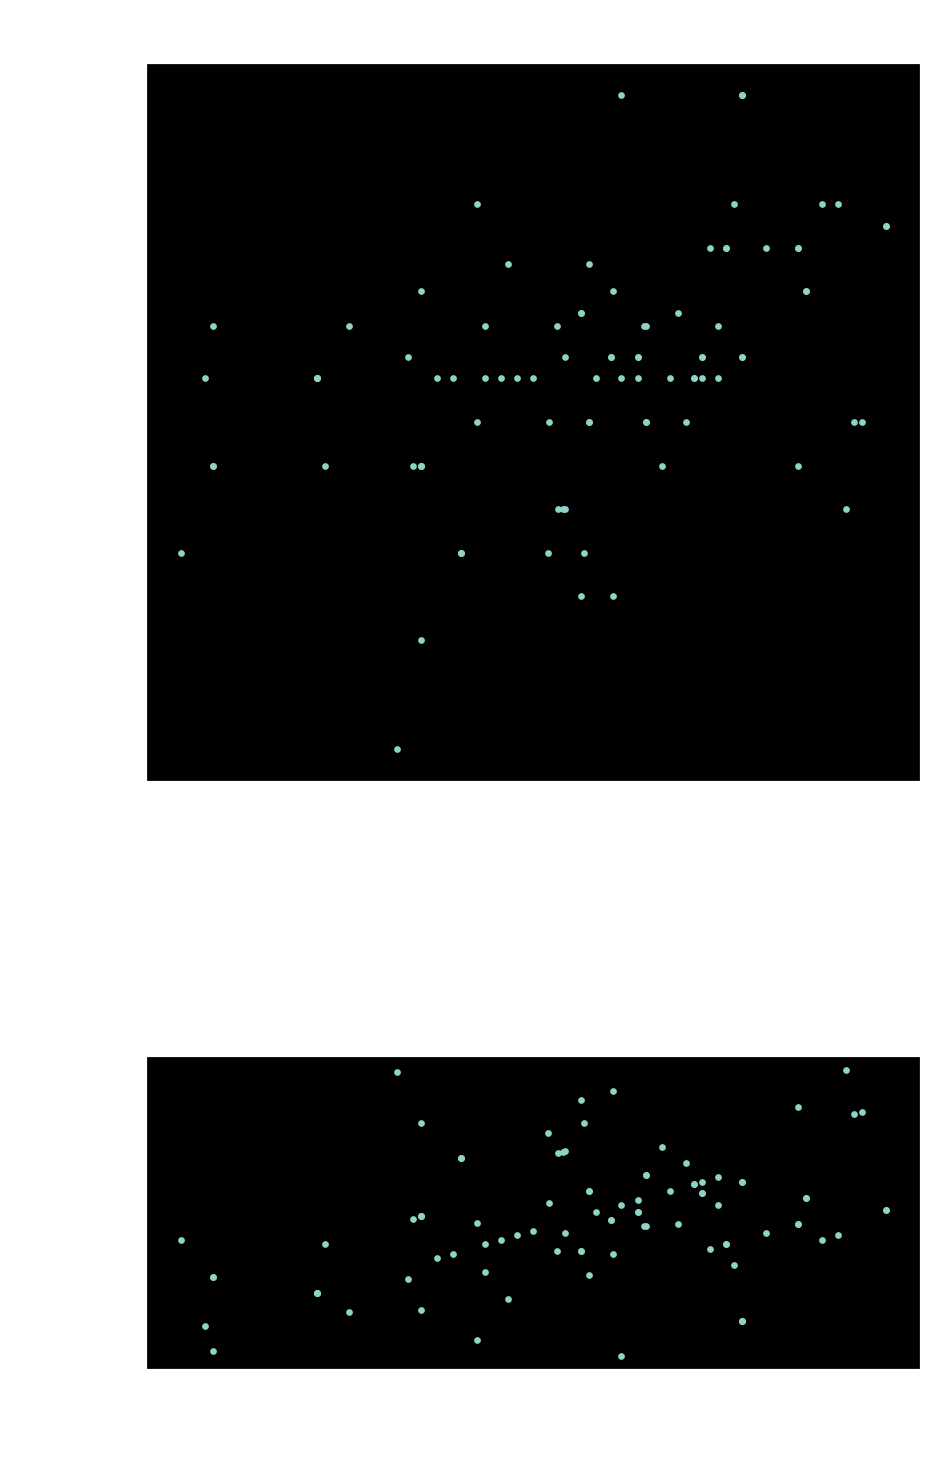

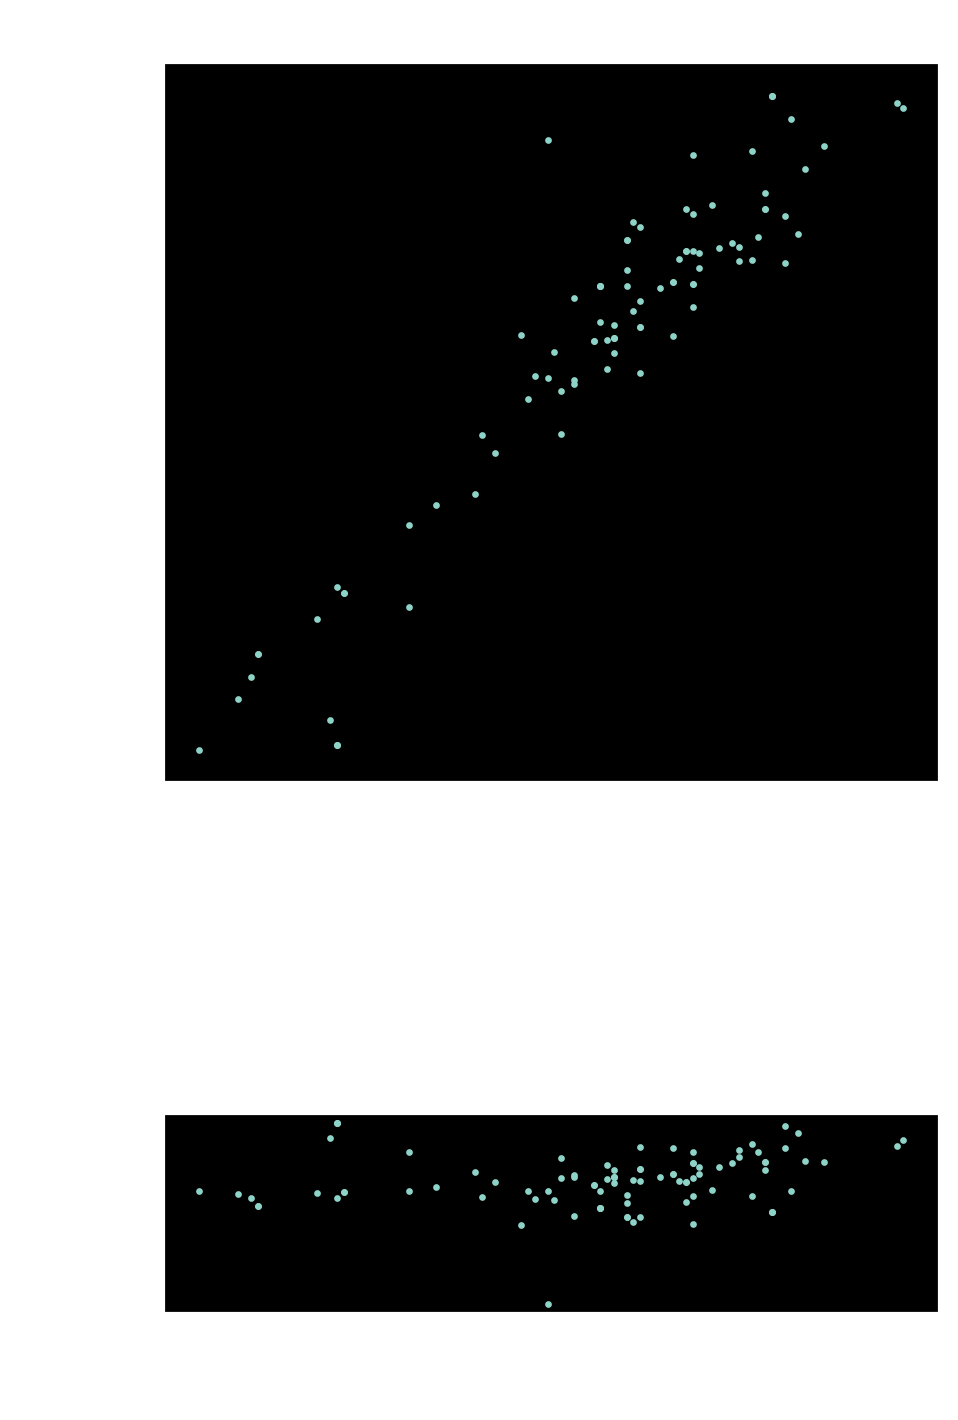

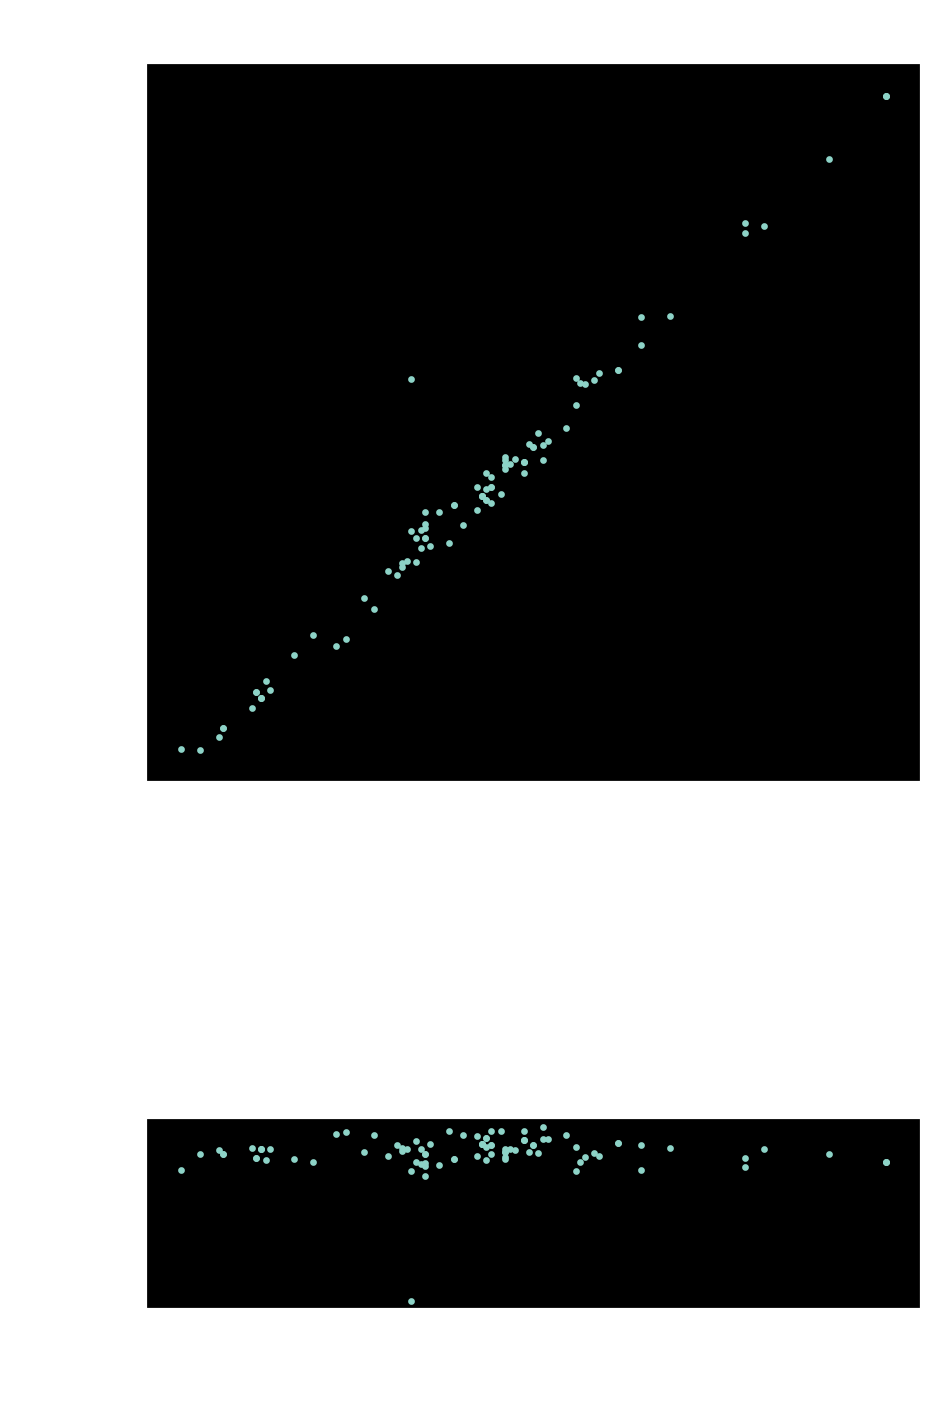

ValueError: 'box_aspect' and 'fig_aspect' must be positive

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc330cee280> (for post_execute):


ValueError: 'box_aspect' and 'fig_aspect' must be positive

ValueError: 'box_aspect' and 'fig_aspect' must be positive

<Figure size 1000x2000 with 2 Axes>

In [18]:
def plot_comparison(ax, var1, var2,source1, source2,  table):
    ax.scatter(table[var1], table[var2], s=2)
    gaia_range = max(table[var1])-min(table[var1])
    sc_range = max(table[var2])-min(table[var2])
    ax.set_ylabel(source2)
    ax.axes.xaxis.set_visible(False)
    if 'st_teff' in var1:
        ax.set_title('Teff [K]')
    if 'met' in var1:
        ax.set_title('FeH [dex]')
    if 'mass' in var1:
        ax.set_title(r'Mass [M$_{\odot}$]')
    if 'rad' in var1:
        ax.set_title(r'Radius [R$_{\odot}$]')
    if 'age' in var1:
        ax.set_title(r'Age [Myr]')

def plot_residual(ax, var1, var2, source1, source2, table):
    residual = table[var1] -  table[var2]
    ax.scatter(table[var1], residual, s=2)
    ax.set_xlabel(source1)
    ax.set_ylabel(('{0}-{1}'.format(source1,source2)))
    range = max(table[var1])-min(table[var2])
    residual_range = max(residual) - min(residual)
    ax.set_aspect(range/(residual_range*4))

def plot(var1, var2, source1, source2, table):

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols = 1, sharex='all', figsize=(5,10))

    plt.subplots_adjust(hspace=0.1)
    plot_comparison(ax1, var1, var2, source1, source2, table)
    plot_residual(ax2, var1, var2,source1, source2, table)

    plt.savefig('/Users/afw2/BASTA/Paper1/figures/{0}_{1}_{2}_{3}.pdf'.format(var1,var2,source1, source2))

    plt.show()

plot('st_teff', 'Teff_gaia', 'NASA', 'GAIA', full_analysis)
plot('st_met', 'FeH_gaia', 'NASA', 'GAIA', full_analysis)
plot('st_mass', 'massfin_gaia', 'NASA', 'GAIA', full_analysis)
plot('st_rad', 'radPhot_gaia', 'NASA', 'GAIA', full_analysis)
plot('st_age', 'age_gaia', 'NASA', 'GAIA', full_analysis)


plot('st_teff', 'Teff_sc', 'NASA', 'GAIA', full_analysis)
plot('st_met', 'FeH_sc', 'NASA', 'GAIA', full_analysis)
plot('st_mass', 'massfin_sc', 'NASA', 'GAIA', full_analysis)
plot('st_rad', 'radPhot_sc', 'NASA', 'GAIA', full_analysis)
plot('st_age', 'age_sc', 'NASA', 'GAIA', full_analysis)
#plot('FeH')
#plot('radPhot')
#plot('massfin')
#plot('age')


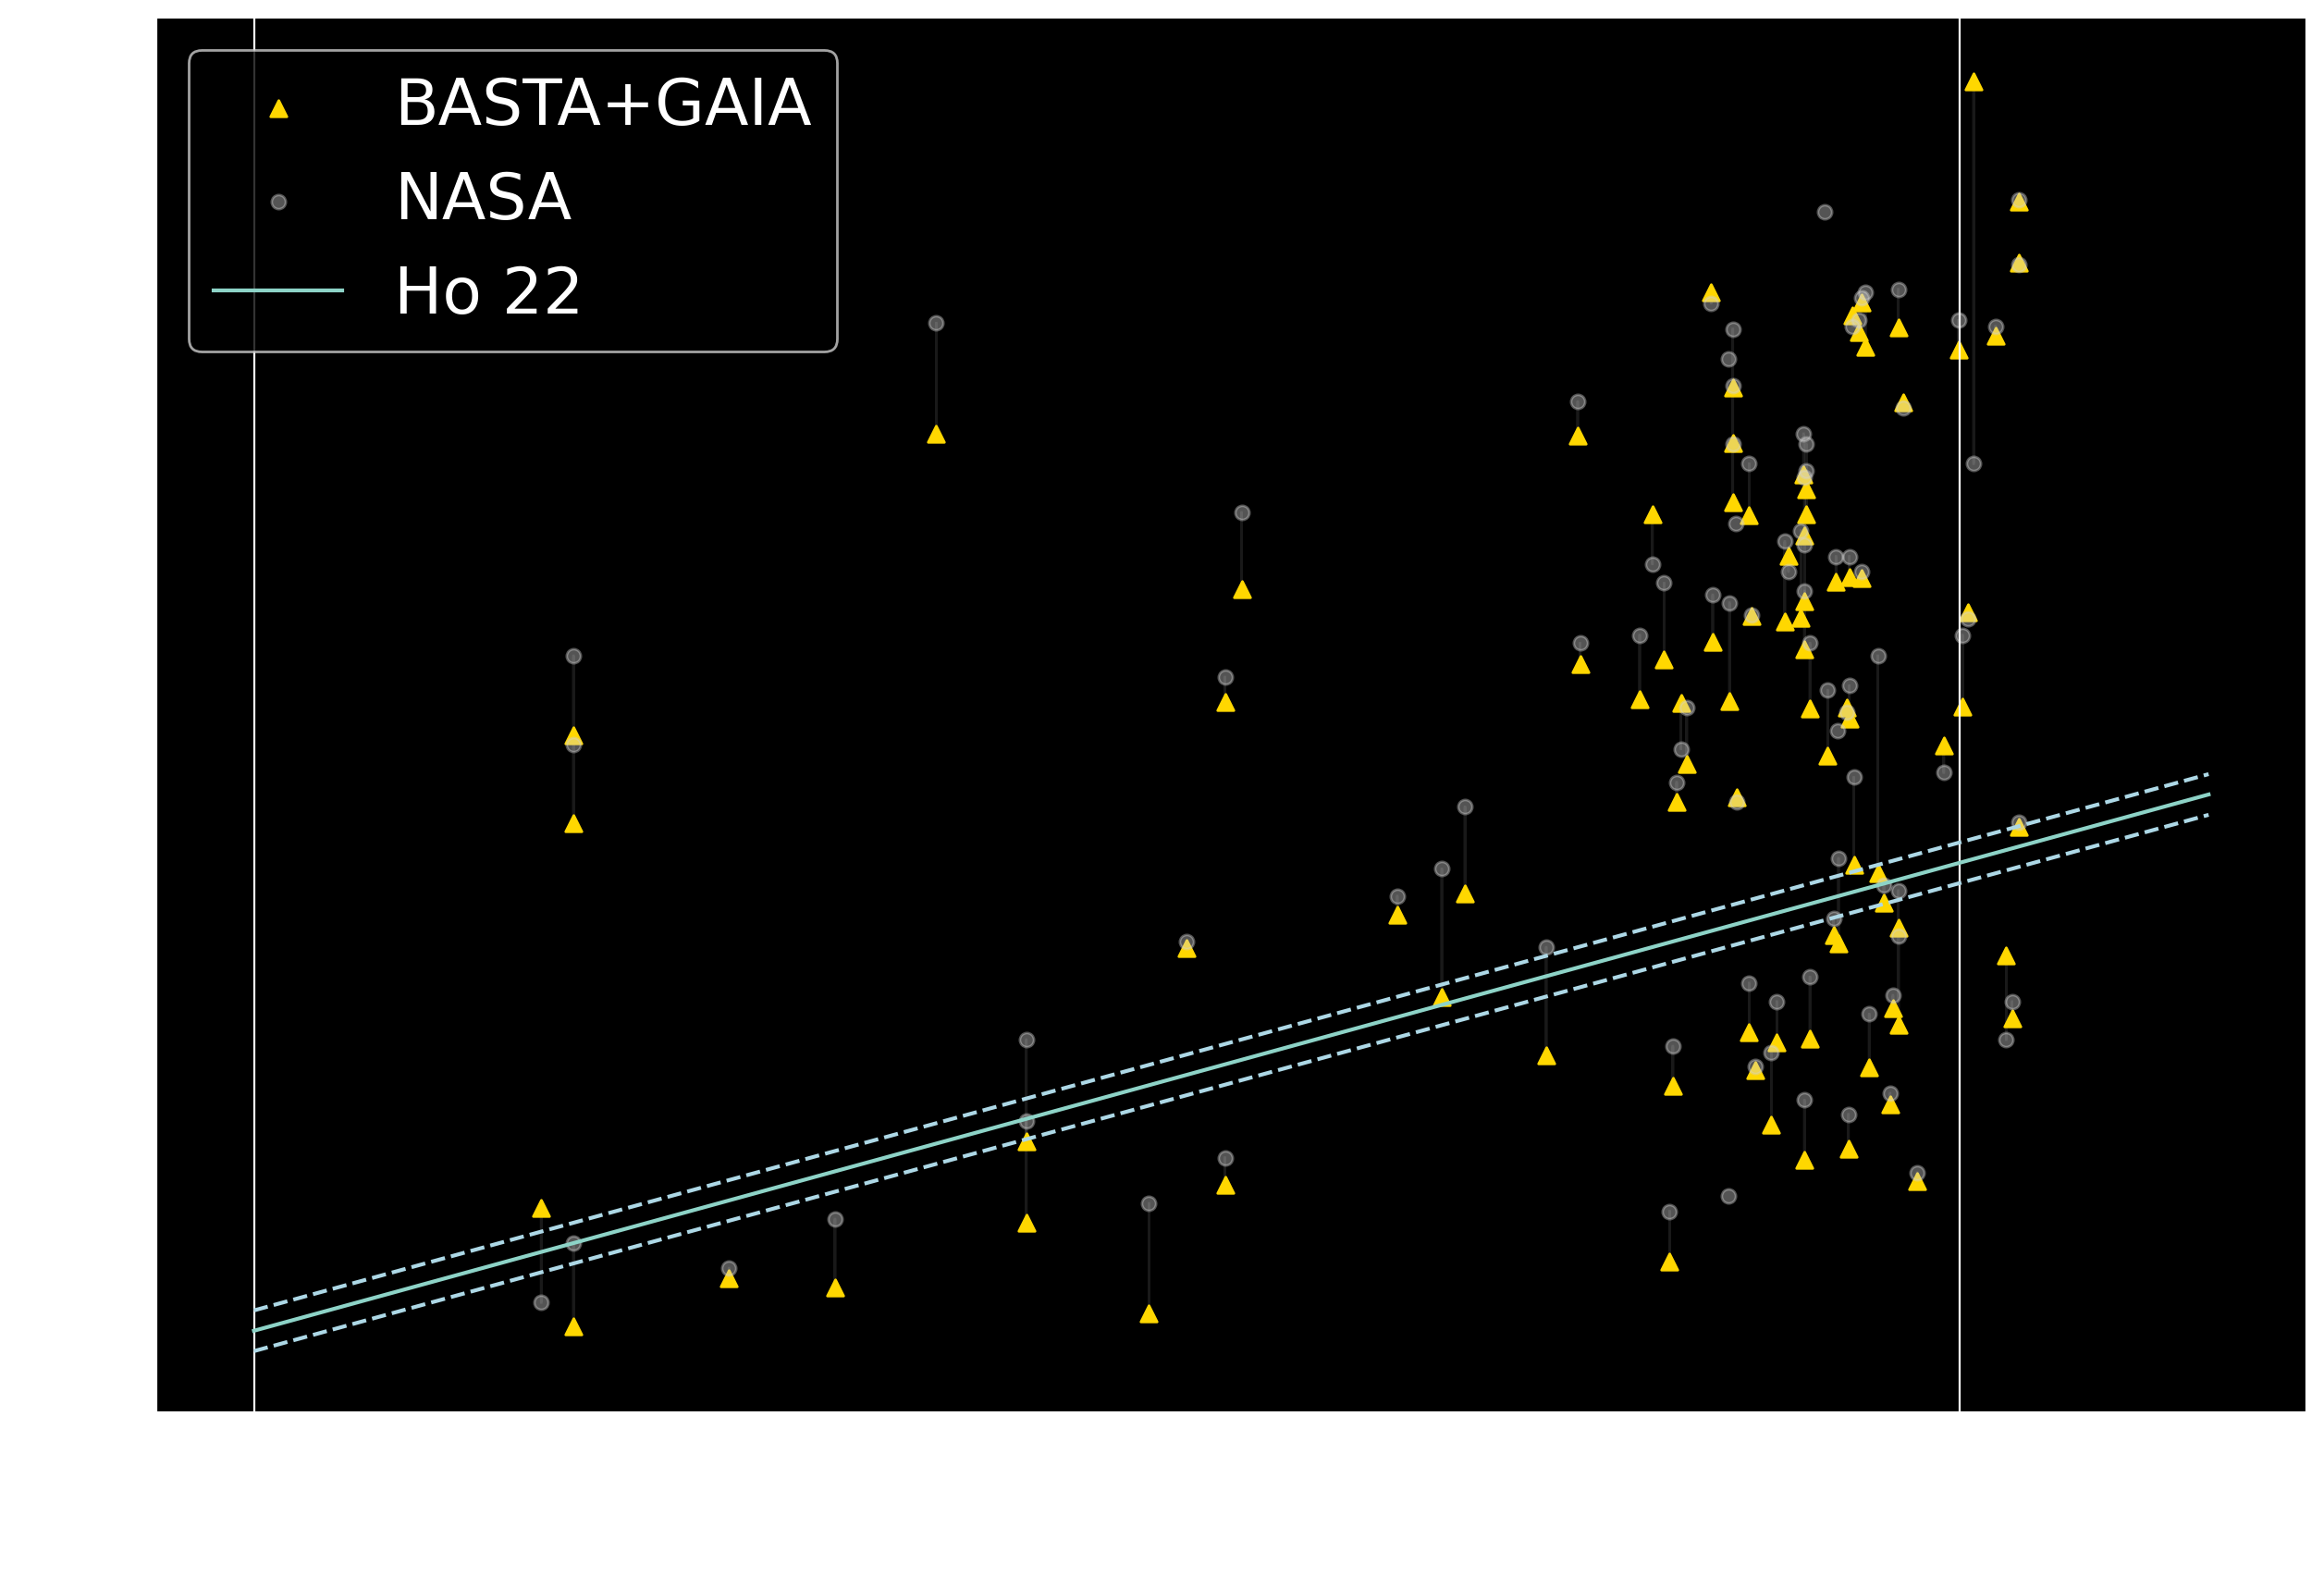

In [19]:
%matplotlib inline
dpi=200
import matplotlib as mpl
mpl.rcParams['figure.dpi']= dpi
plt.rcParams['axes.formatter.min_exponent'] = 4
plt.rcParams.update({'font.size': 25})

re = c.R_earth.value

rp_gaia_earth = (rad_gaia*rj.value)/re
rp_nasa_earth = (rad*rj.value)/re

period = np.array(full_analysis['pl_orbper'])
st_mass = np.array(full_analysis['massfin_gaia'])
st_age = np.array(full_analysis['age_gaia'])
st_teff = np.array(full_analysis['Teff_gaia'])
#ax1 = plt.scatter(mass, rad, s=5, c='grey', alpha = 0.6, label = 'NASA')
#ax2 = plt.scatter(mass_gaia, rad_gaia, s=3, c='b', marker = '^', label = 'BASTA+GAIA')
#ax3 = plt.scatter(mass_sc, rad_sc, s=3, c='gold', marker = '^', label = 'BASTA+SC')
fig, ax = plt.subplots(figsize=(15,10))

mass_grad = 0.23
mass_intercept =0.27

x = np.linspace(0.1,1.4,1000)
y = 10**(mass_grad*np.log10(x) + mass_intercept)
y_up = 10**((mass_grad)*np.log10(x) + mass_intercept+0.01)
y_lo = 10**((mass_grad)*np.log10(x) + mass_intercept-0.01)

plt.grid(True)
for i in range(len(mass)):
    plt.arrow(x=st_mass[i],y=rp_nasa_earth[i], dx=(0), dy=(rp_gaia_earth[i]-rp_nasa_earth[i]), width=.000001,length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,head_starts_at_zero=False)

plt.scatter((st_mass), (rp_gaia_earth), s=40, c='gold', marker = '^', label = 'BASTA+GAIA')
plt.scatter((st_mass),(rp_nasa_earth), s=30, c='lightgrey', alpha = 0.4, marker = 'o', label = 'NASA')
plt.plot(x, y, label = 'Ho 22')
plt.plot(x, y_up, c = 'lightblue', linestyle='--')
plt.plot(x, y_lo, c = 'lightblue', linestyle='--')
plt.xlabel(r'$log_{10}(M_{star}}$) [M$_\odot$]')
plt.ylabel(r'$log_{10}$(R$_p$ [R$_\oplus$])')
plt.xscale('log')
plt.yscale('log')

plt.legend()


plt.savefig('/Users/afw2/BASTA/Paper1/figures/radius_valley_stellar_mass.jpg')

plt.show()

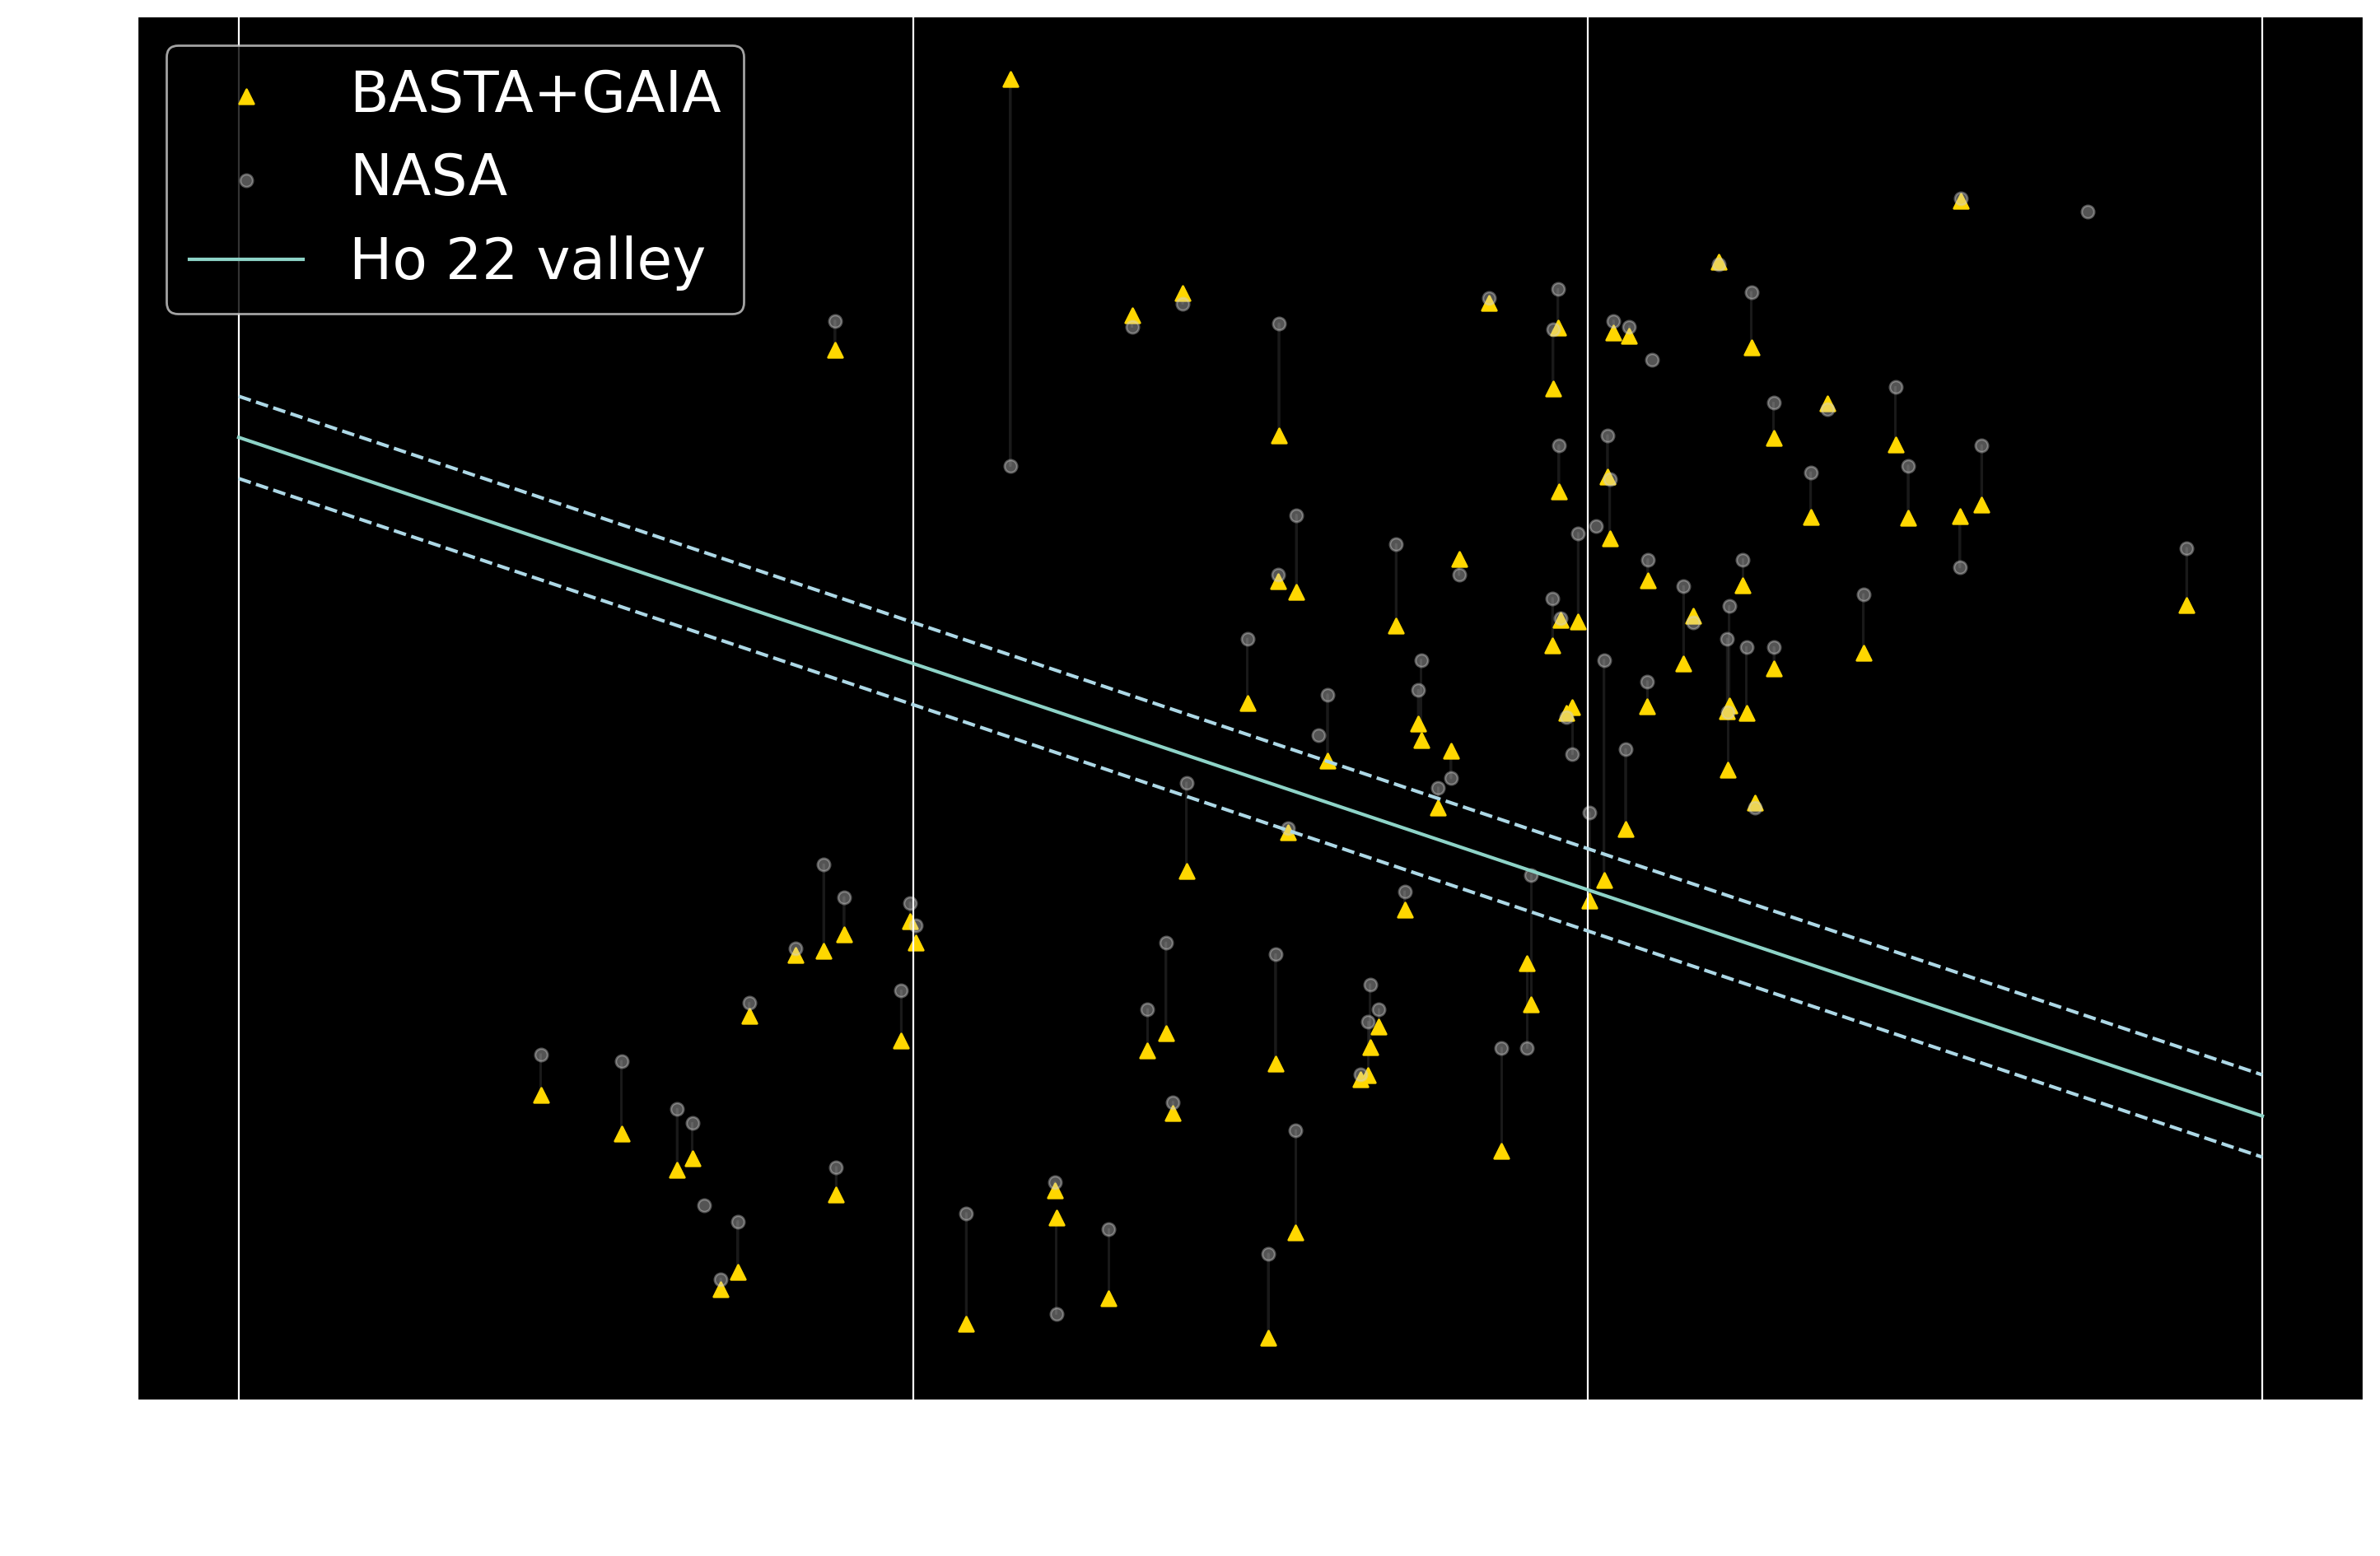

In [20]:
fig, ax = plt.subplots(figsize=(15,10))

mass_grad = -0.11
mass_intercept = 0.37

x = np.linspace(0.1,100,1000)
y = 10**(mass_grad*np.log10(x) + mass_intercept)
y_up = 10**((mass_grad)*np.log10(x) + mass_intercept+0.02)
y_lo = 10**((mass_grad)*np.log10(x) + mass_intercept-0.02)


plt.grid(True)
for i in range(len(mass)):
    plt.arrow(x=period[i],y=rp_nasa_earth[i], dx=(0), dy=(rp_gaia_earth[i]-rp_nasa_earth[i]), width=.000001,length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,head_starts_at_zero=False)

plt.scatter((period), (rp_gaia_earth), s=40, c='gold', marker = '^', label = 'BASTA+GAIA')
plt.scatter((period),(rp_nasa_earth), s=30, c='lightgrey', alpha = 0.4, marker = 'o', label = 'NASA')
plt.plot(x, y, label = 'Ho 22 valley')
plt.plot(x, y_up, c = 'lightblue', linestyle='--')
plt.plot(x, y_lo, c = 'lightblue', linestyle='--')
plt.xlabel(r'$log_{10}$P [d]')
plt.ylabel(r'$log_{10}$(R$_p$ [R$_E$])')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.legend()


plt.savefig('/Users/afw2/BASTA/Paper1/figures/radius_valley_period.jpg')
plt.show()

[-3.0010e-01  6.2400e-02  4.5010e-01  4.5010e-01  4.5010e-01 -8.0200e-02
 -4.0050e-01 -6.0060e-01 -1.9980e-01 -1.9980e-01 -8.0200e-02 -1.4970e-01
 -1.4970e-01 -5.0000e-01 -6.0060e-01 -6.0060e-01 -6.0060e-01 -6.0060e-01
 -3.0010e-01 -1.0000e-04 -1.4970e-01 -1.4970e-01 -8.0200e-02 -1.9980e-01
 -1.4970e-01 -1.4970e-01 -7.0000e-01 -1.9980e-01 -7.0000e-01 -1.0499e+00
 -1.9980e-01 -4.0050e-01 -4.0050e-01 -8.0200e-02 -1.4970e-01 -1.9980e-01
 -6.0060e-01 -1.9980e-01 -8.0200e-02 -4.9900e-02 -4.9900e-02 -3.0010e-01
 -1.9980e-01 -4.0050e-01  1.0010e-01 -3.0010e-01  2.0010e-01 -1.0000e-04
 -4.9900e-02 -1.9980e-01  1.0010e-01  1.0010e-01 -8.0200e-02 -1.9980e-01
 -1.9980e-01 -3.0010e-01  2.0010e-01  1.0010e-01 -4.0050e-01 -4.0050e-01
 -3.0010e-01 -1.0000e-04 -1.0000e-04 -1.9980e-01  4.5010e-01 -5.0000e-01
 -1.9980e-01  1.0010e-01 -3.0010e-01  1.0010e-01  2.0010e-01 -1.9980e-01
 -5.0000e-01 -1.4970e-01 -8.0200e-02 -4.0050e-01 -4.0050e-01 -4.0050e-01
 -5.0000e-01 -1.4970e-01 -1.4970e-01 -1.9980e-01 -1

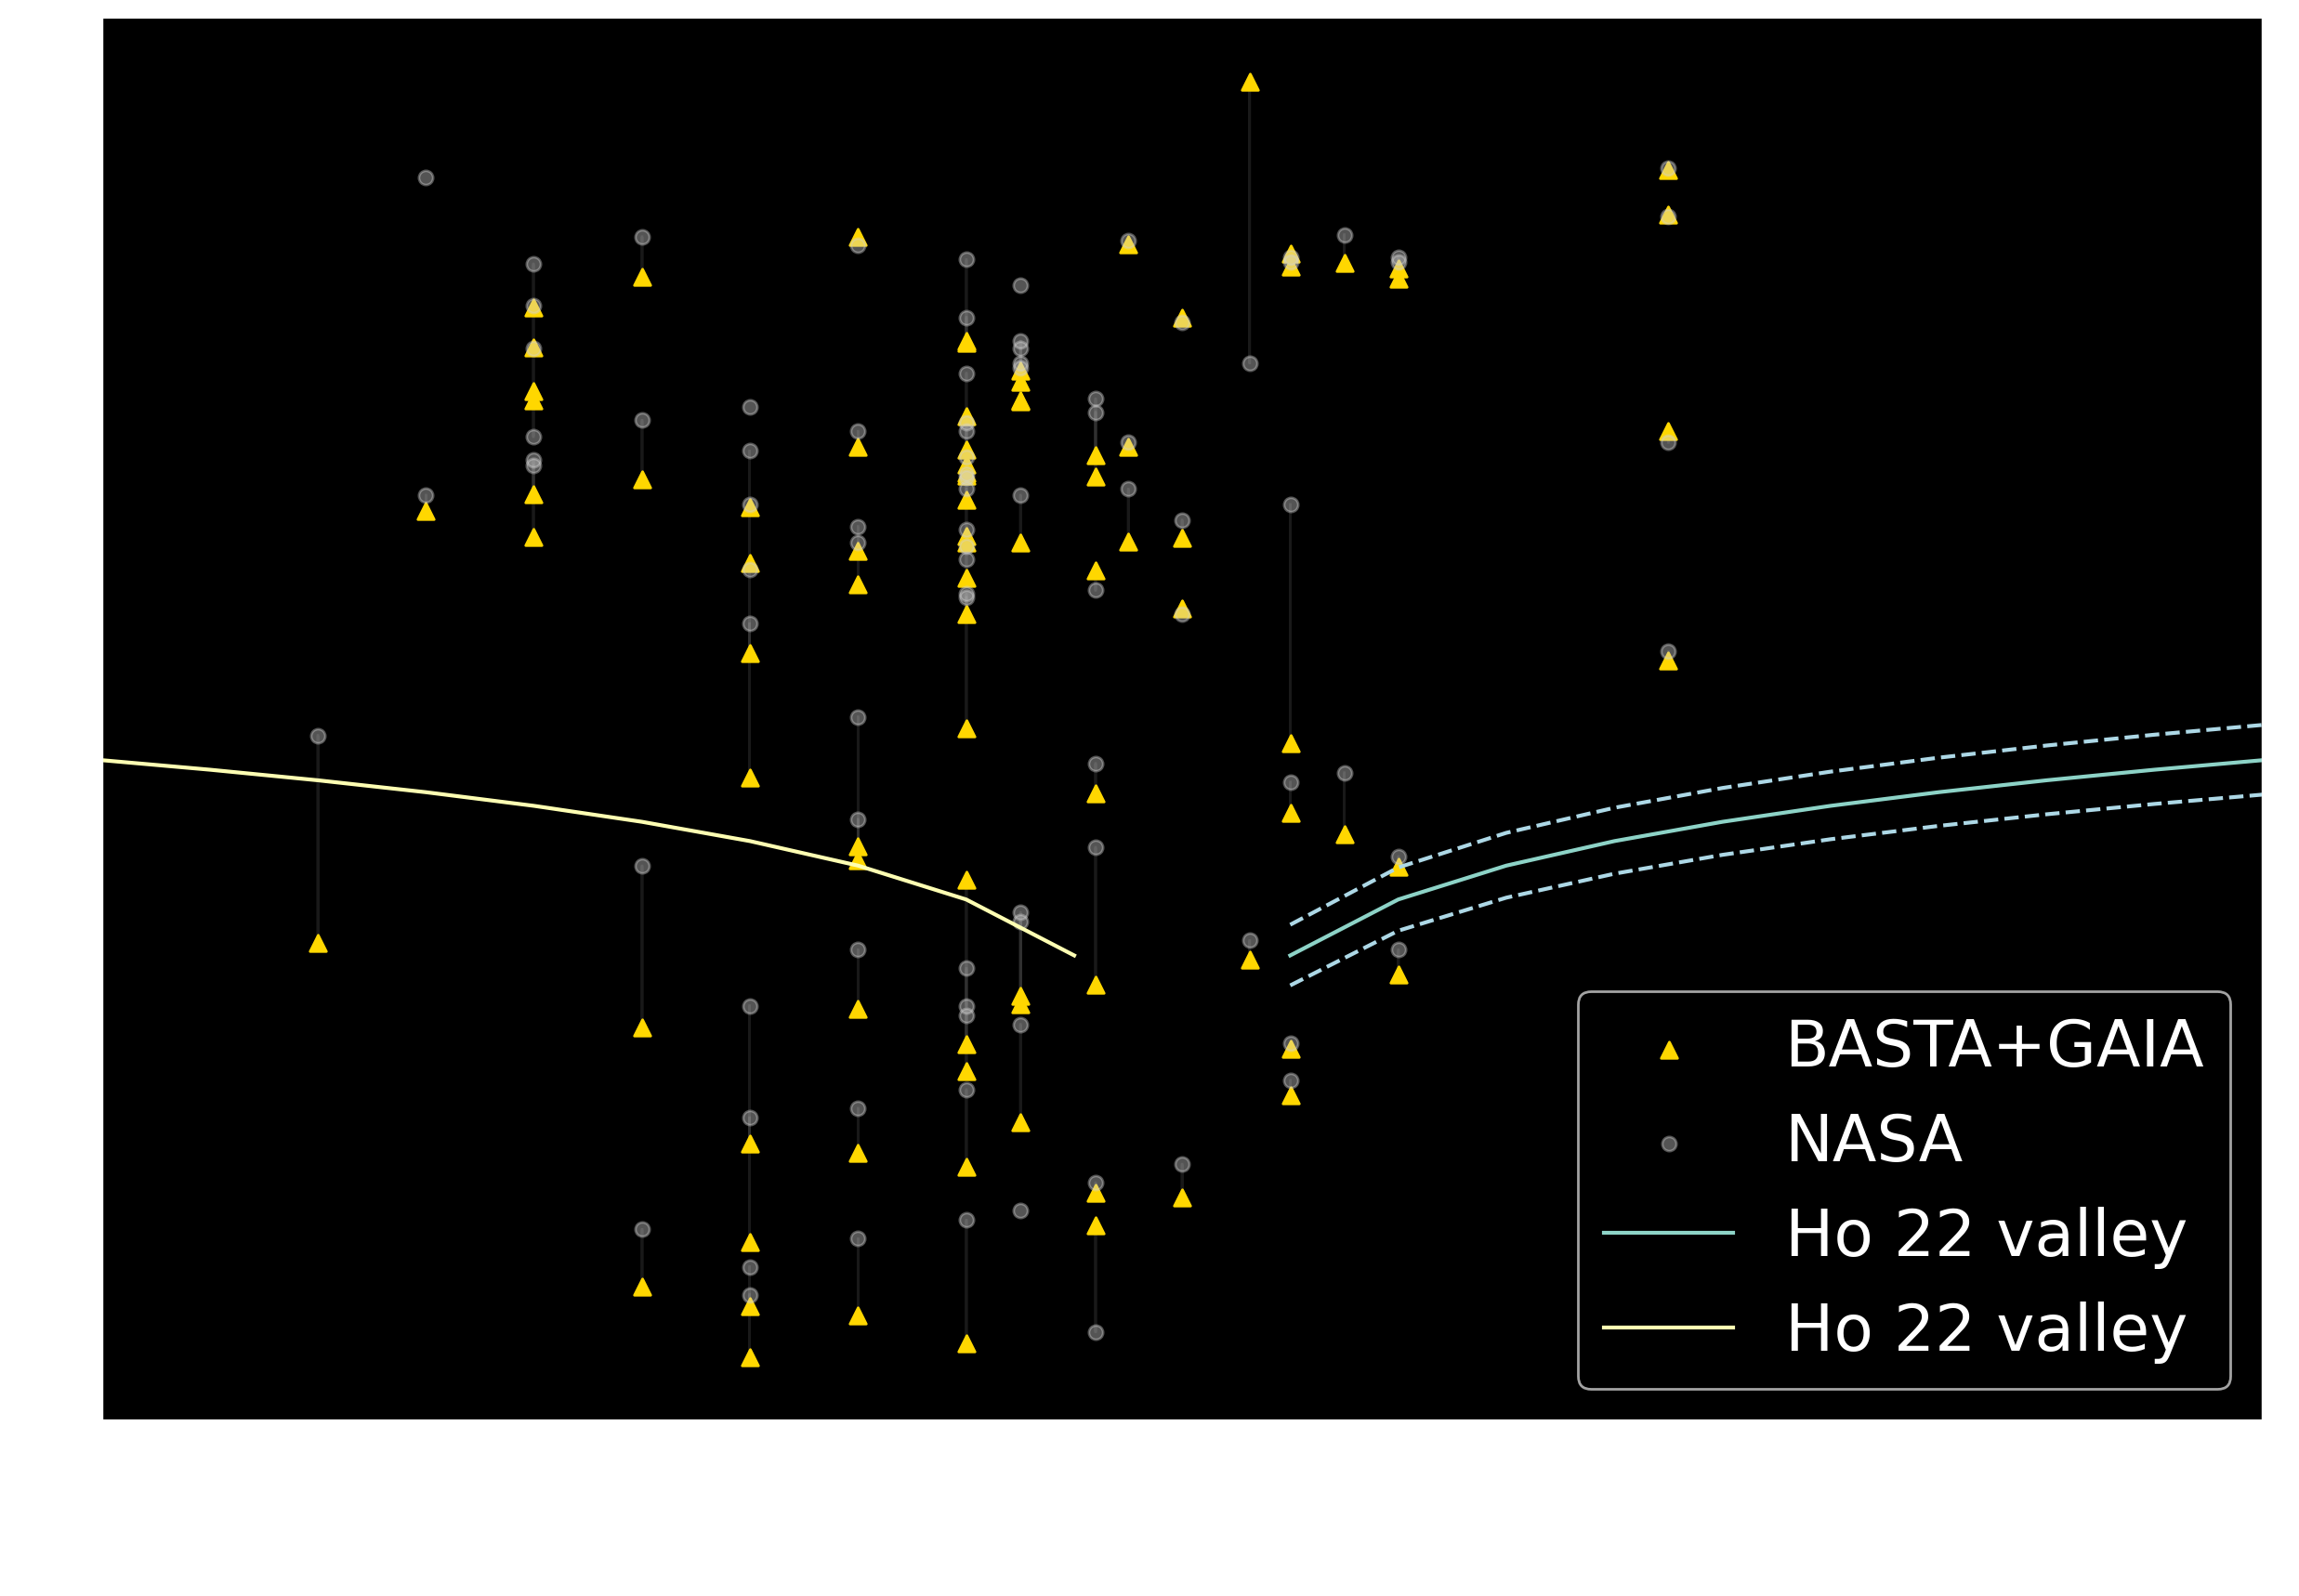

In [21]:
fig, ax = plt.subplots(figsize=(15,10))

mass_grad = 0.06
mass_intercept = 0.26
st_feh = np.array(full_analysis['FeH_gaia'])
print(st_feh)

x = np.linspace(0.1,100,1000)
y = 10**(mass_grad*np.log10(x) + mass_intercept)
y_up = 10**((mass_grad)*np.log10(x) + mass_intercept+0.01)
y_lo = 10**((mass_grad)*np.log10(x) + mass_intercept-0.01)


plt.grid(True)
for i in range(len(st_feh)):
    plt.arrow(x=st_feh[i],y=rp_nasa_earth[i], dx=(0), dy=(rp_gaia_earth[i]-rp_nasa_earth[i]), width=.000001,length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,head_starts_at_zero=False)

plt.scatter((st_feh), (rp_gaia_earth), s=40, c='gold', marker = '^', label = 'BASTA+GAIA')
plt.scatter((st_feh),(rp_nasa_earth), s=30, c='lightgrey', alpha = 0.4, marker = 'o', label = 'NASA')
plt.plot(x, y, label = 'Ho 22 valley')
plt.plot(-x, y, label = 'Ho 22 valley')
plt.plot(x, y_up, c = 'lightblue', linestyle='--')
plt.plot(x, y_lo, c = 'lightblue', linestyle='--')
plt.xlabel(r'$log_{10}(M_{star}}$) [K]')
plt.ylabel(r'$log_{10}$(R$_p$ [R$_E$])')
plt.xlim(-1,1)
plt.xscale('symlog')
plt.yscale('symlog')

plt.legend()


#plt.savefig('/Users/afw2/BASTA/Paper1/figures/stellar_teff_radius_comp.jpg')

plt.show()

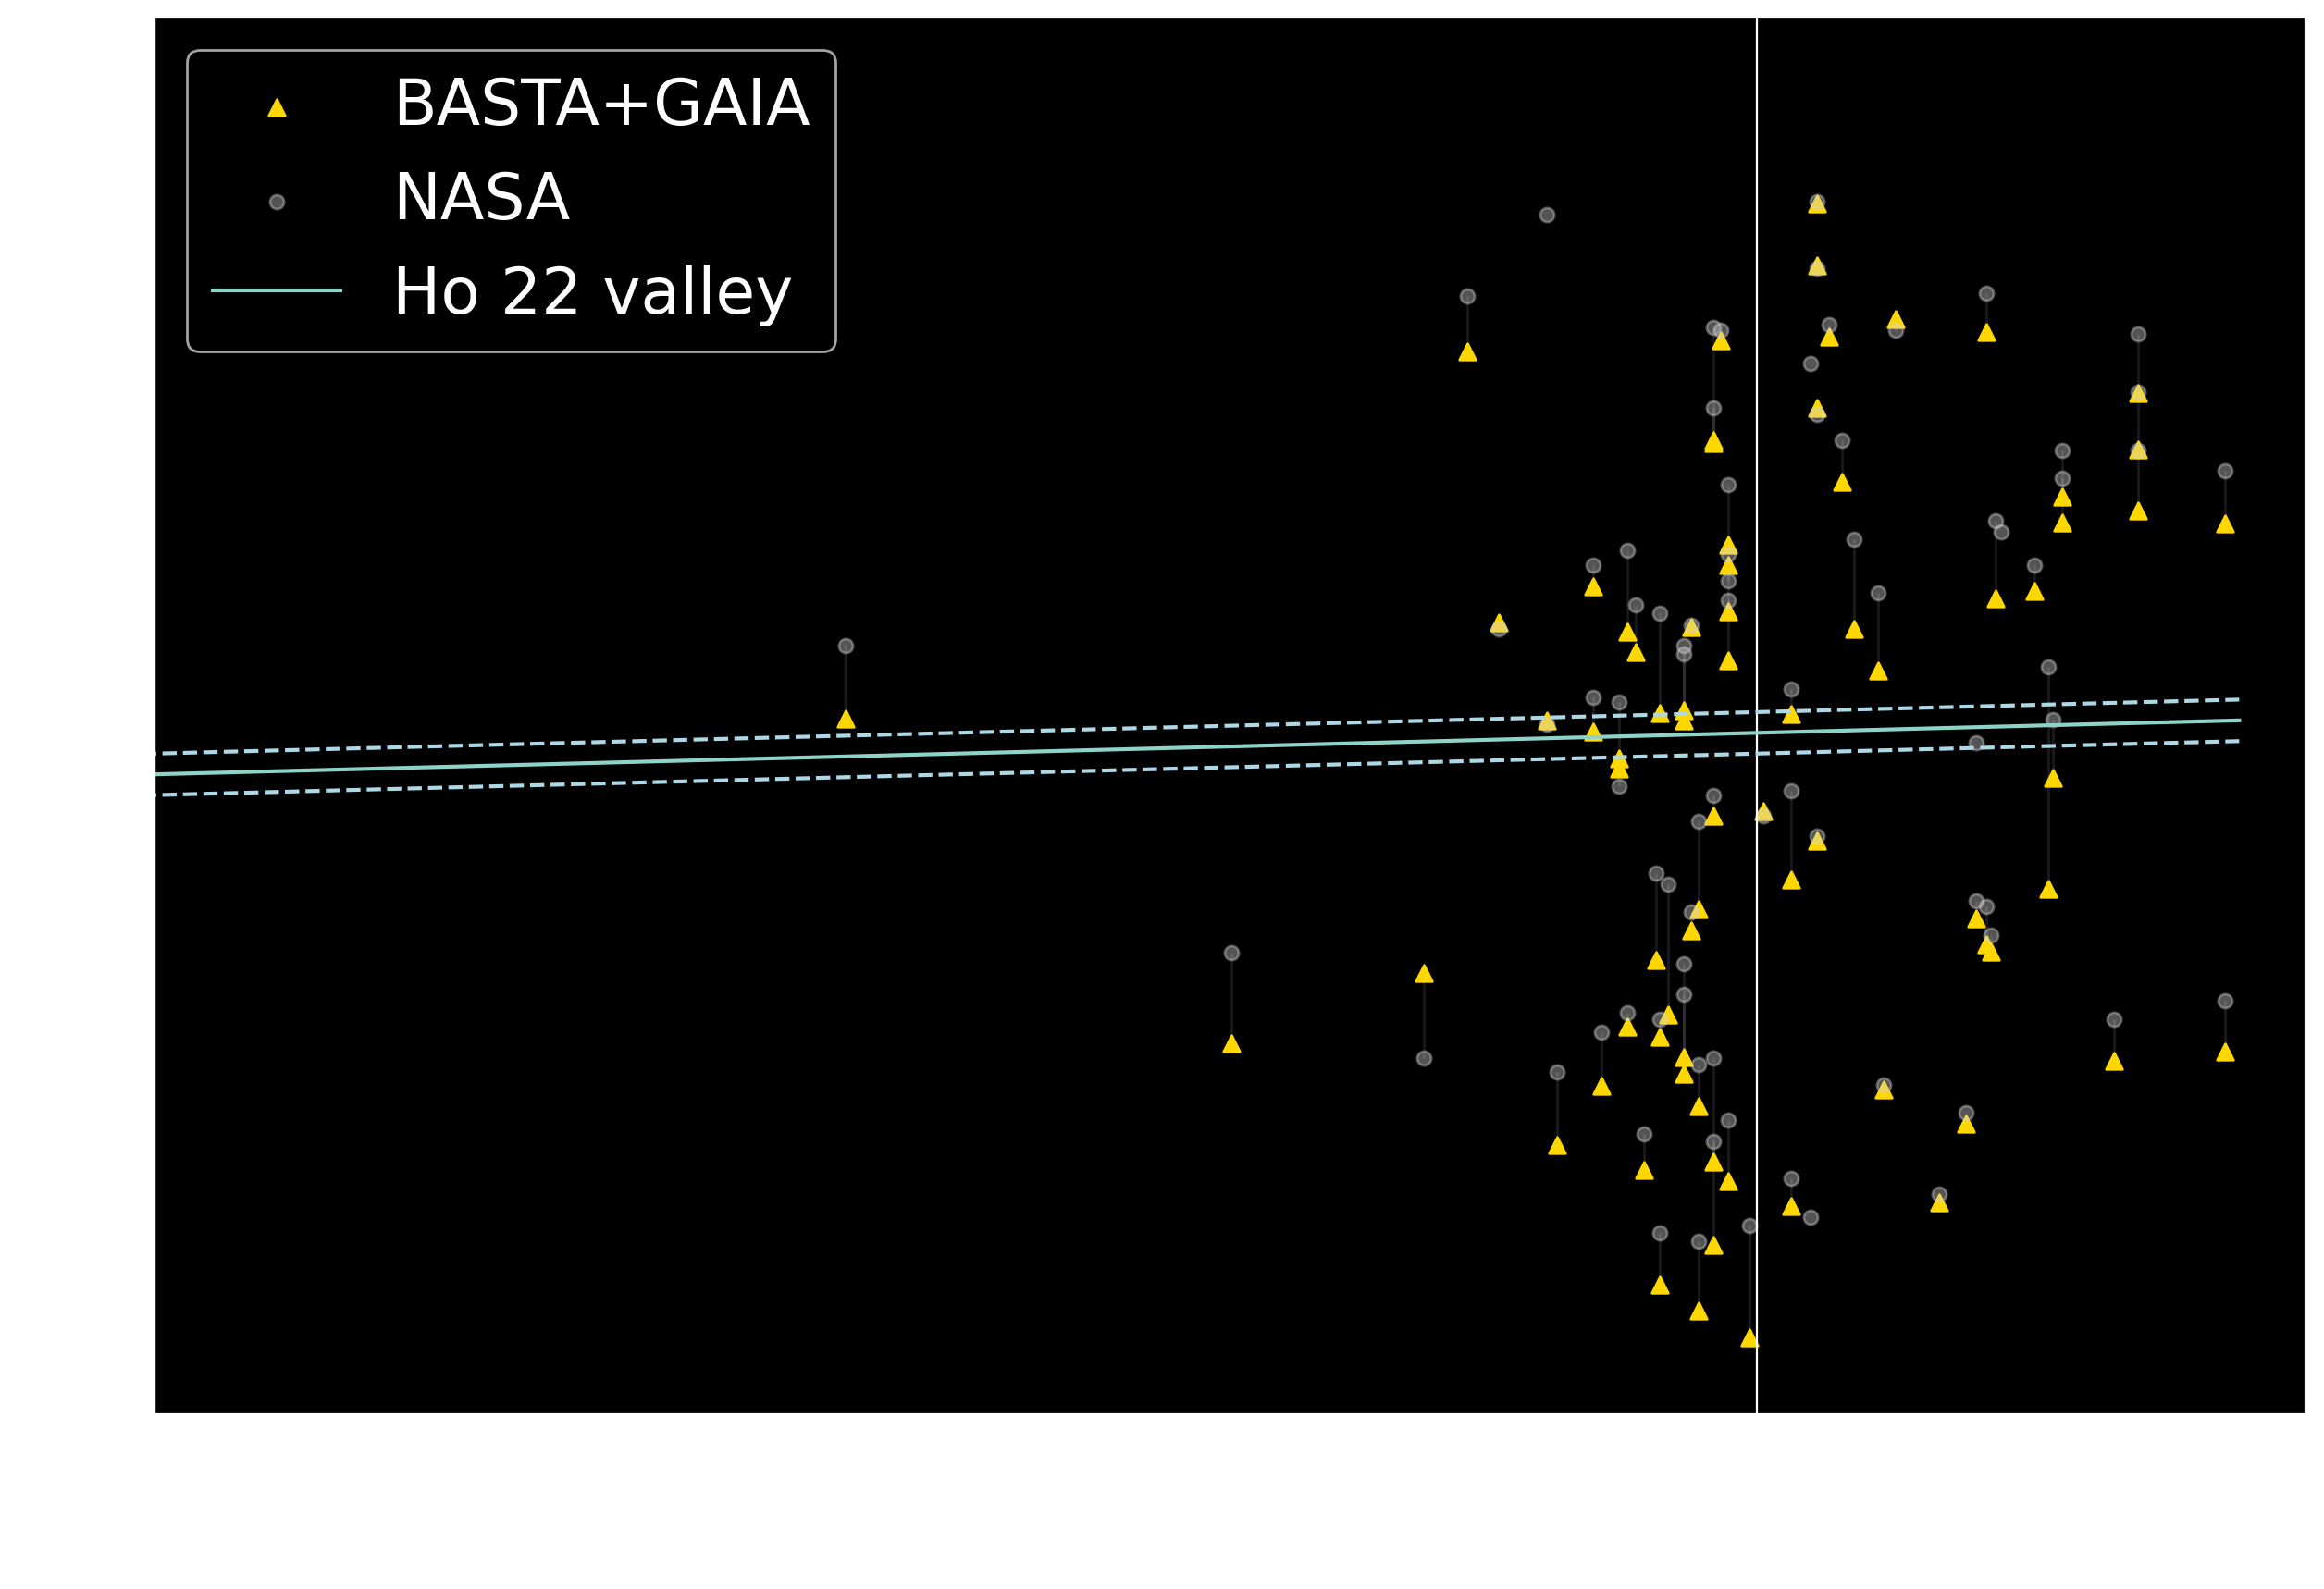

In [22]:
fig, ax = plt.subplots(figsize=(15,10))

mass_grad = 0.02
mass_intercept = 0.26
st_feh = np.array(full_analysis['FeH_gaia'])

x = np.linspace(10,20000,1000)
y = 10**(mass_grad*np.log10(x) + mass_intercept)
y_up = 10**((mass_grad)*np.log10(x) + mass_intercept+0.01)
y_lo = 10**((mass_grad)*np.log10(x) + mass_intercept-0.01)

plt.grid(True)
for i in range(len(st_feh)):
    plt.arrow(x=st_age[i],y=rp_nasa_earth[i], dx=(0), dy=(rp_gaia_earth[i]-rp_nasa_earth[i]), width=.000001,length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,head_starts_at_zero=False)

plt.scatter(st_age, rp_gaia_earth, s=40, c='gold', marker = '^', label = 'BASTA+GAIA')
plt.scatter((st_age),(rp_nasa_earth), s=30, c='lightgrey', alpha = 0.4, marker = 'o', label = 'NASA')
plt.plot(x, y, label = 'Ho 22 valley')
plt.plot(x, y_up, c = 'lightblue', linestyle='--')
plt.plot(x, y_lo, c = 'lightblue', linestyle='--')
plt.xlabel(r'$log_{10}(Age_{star}}$) [Gyr]')
plt.ylabel(r'$log_{10}$(R$_p$ [R$_E$])')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1000, 22000)
plt.legend()


plt.savefig('/Users/afw2/BASTA/Paper1/figures/radius_valley_stellar_age_cut.jpg')
plt.show()

93 93 93 93 93 93


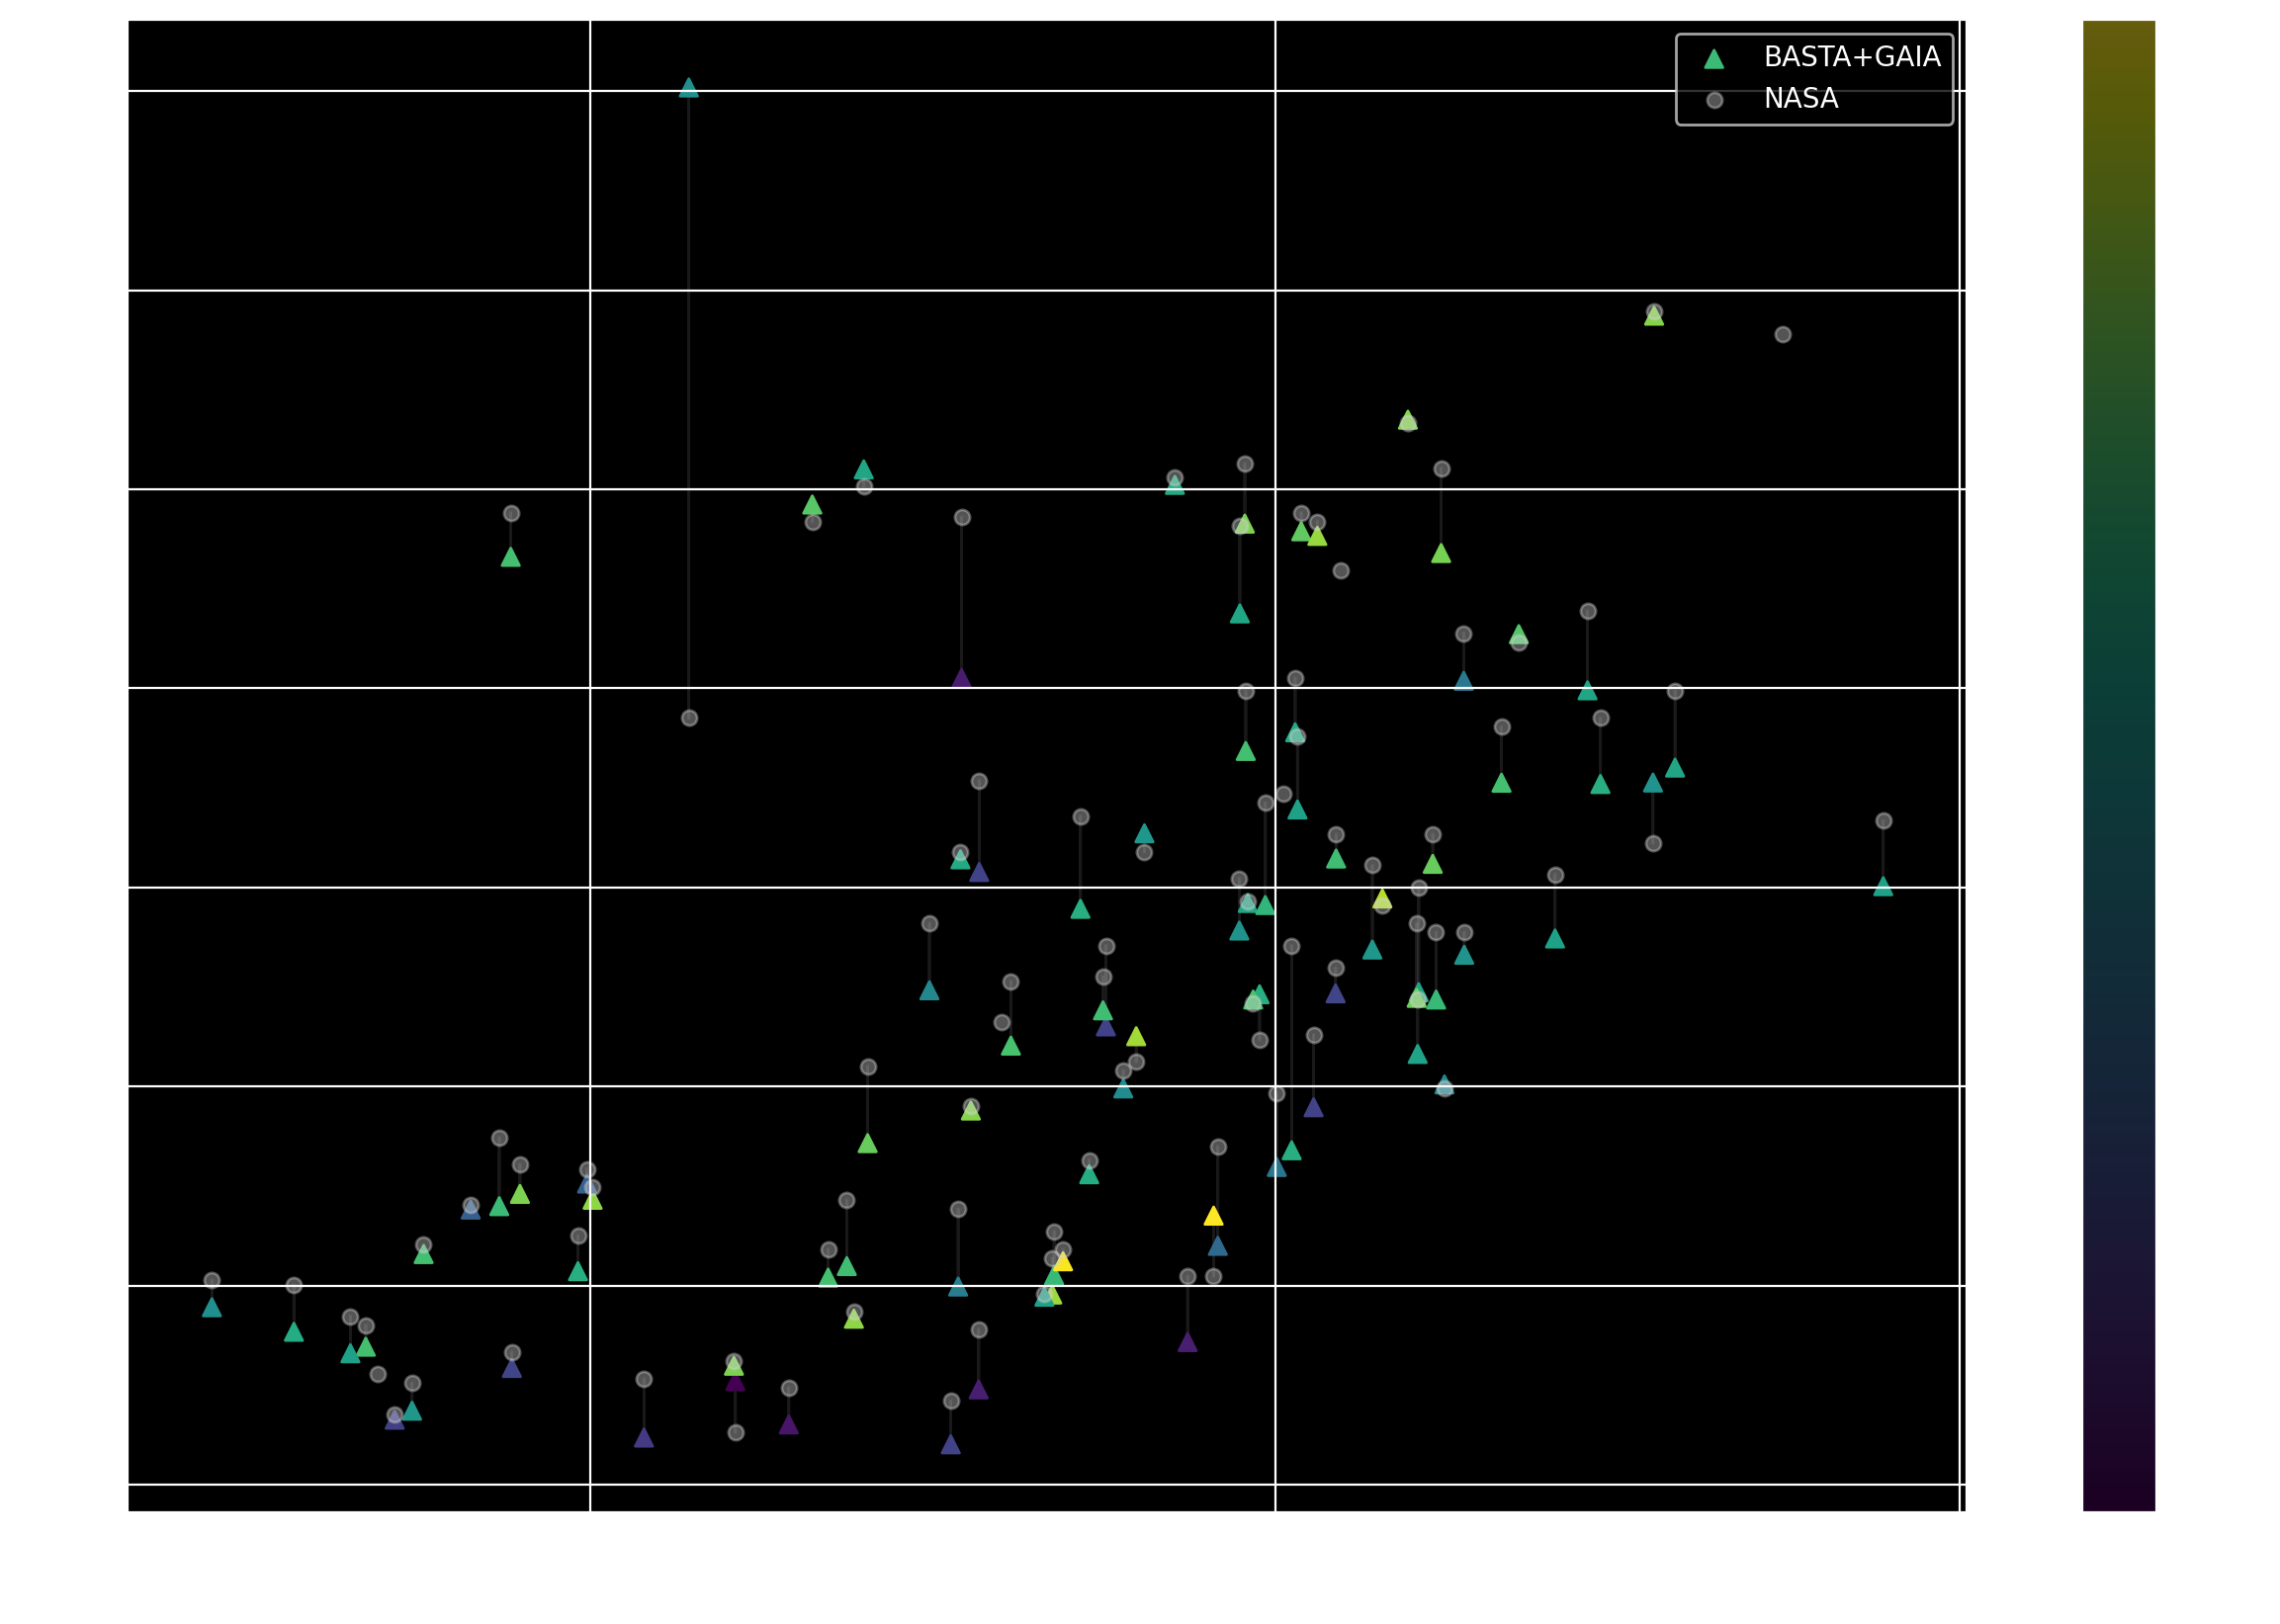

In [23]:

%matplotlib inline
dpi = 200
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = dpi

re = c.R_earth
me = c.M_earth
mj = c.M_jup

ms_gaia = np.array(full_analysis['massfin_gaia'])
ms_nasa = np.array(full_analysis['st_mass'])

rp_gaia_earth = (rad_gaia * rj.value) / re.value
rp_nasa_earth = (rad * rj.value) / re.value

mp_gaia_earth = (mp_basta_gaia * mj.value) / me.value
mp_nasa_earth = (mp_recalc * mj.value) / me.value

period = np.array(full_analysis['pl_orbper'])
#ax1 = plt.scatter(mass, rad, s=5, c='grey', alpha = 0.6, label = 'NASA')
#ax2 = plt.scatter(mass_gaia, rad_gaia, s=3, c='b', marker = '^', label = 'BASTA+GAIA')
#ax3 = plt.scatter(mass_sc, rad_sc, s=3, c='gold', marker = '^', label = 'BASTA+SC')
fig, ax = plt.subplots(figsize=(15, 10))
plt.grid(True)
for i in range(len(mass)):
    plt.arrow(x=period[i], y=rp_nasa_earth[i], dx=(0), dy=(rp_gaia_earth[i] - rp_nasa_earth[i]), width=.000001,
              length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,
              head_starts_at_zero=False)

plt.scatter(period, rp_gaia_earth, s=40, marker='^', label='BASTA+GAIA',  c=ms_nasa, cmap = 'viridis')
plt.scatter(period, rp_nasa_earth, s=30, c='lightgrey', alpha=0.4, marker='o', label='NASA')
plt.clim(0,1.5)
plt.colorbar(label=r'Stellar Mass M$_{\odot}$')

plt.xlabel(r'P$_p$ [d]')
plt.ylabel(r'R$_p$ [R$_E$]')  #plt.xscale('log')
plt.xscale('log')
#plt.yscale('log')
plt.legend()

plt.savefig('/Users/afw2/BASTA/Paper1/figures/period_radius_comp.jpg')

print(len(mass), len(rad), len(mass_gaia), len(rad_gaia), len(mass_sc), len(rad_gaia))

In [24]:
print(max(mp_nasa_earth))

42.09356547058821


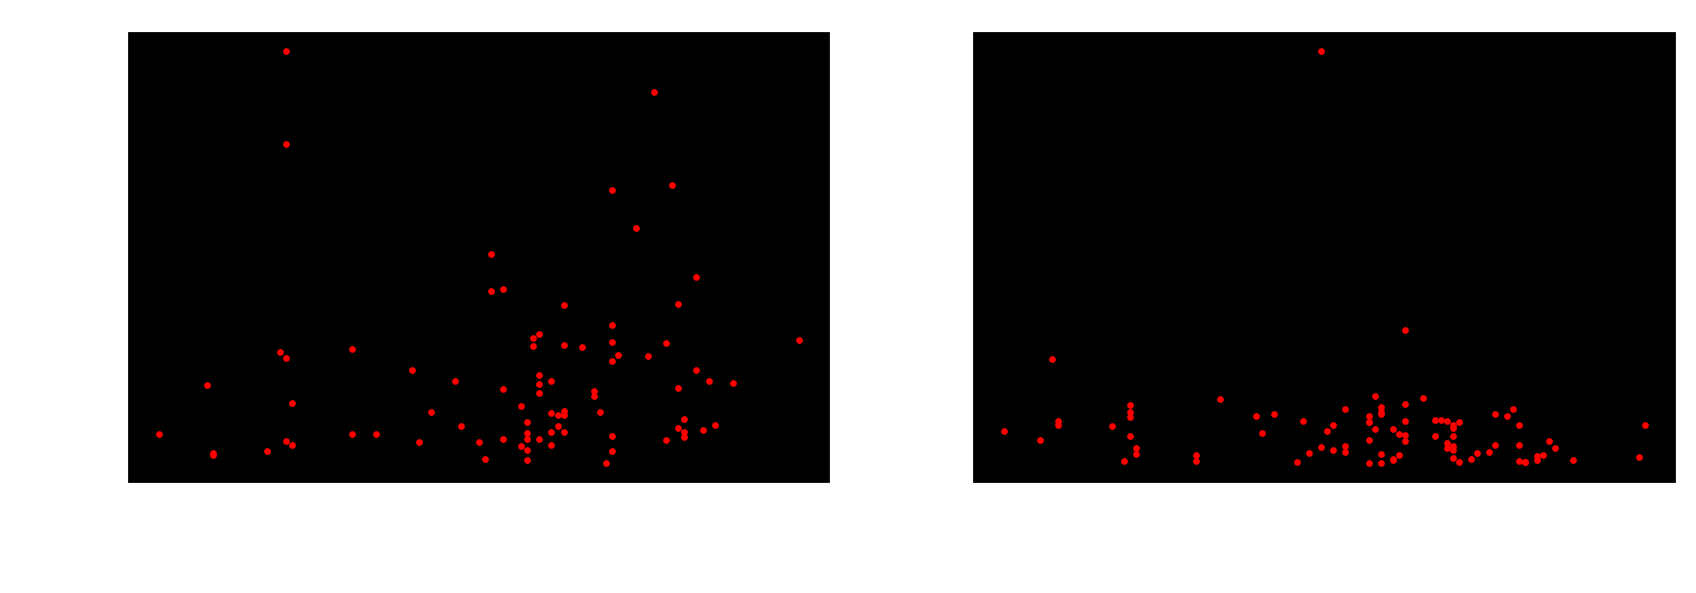

In [25]:
fig, ax = plt.subplots(1,2, figsize = (10,3))

ax[0].scatter(ms_nasa,abs(mp_nasa_earth- mp_gaia_earth ), s=2, c='r')
ax[0].set_xlabel(r'Stellar Mass [M$_{\odot}$]')
ax[0].set_ylabel(r'Change in Planet Mass [M$_{E}$]' )

ax[1].scatter(ms_nasa,abs(rp_nasa_earth - rp_gaia_earth), s=2, c='r')
ax[1].set_xlabel(r'Stellar Mass [M$_{\odot}$]')
ax[1].set_ylabel(r'Change in PLanet Radius [R$_e$]' )

plt.savefig('/Users/afw2/BASTA/Paper1/figures/stellar_mass_effect.jpg')
plt.show()

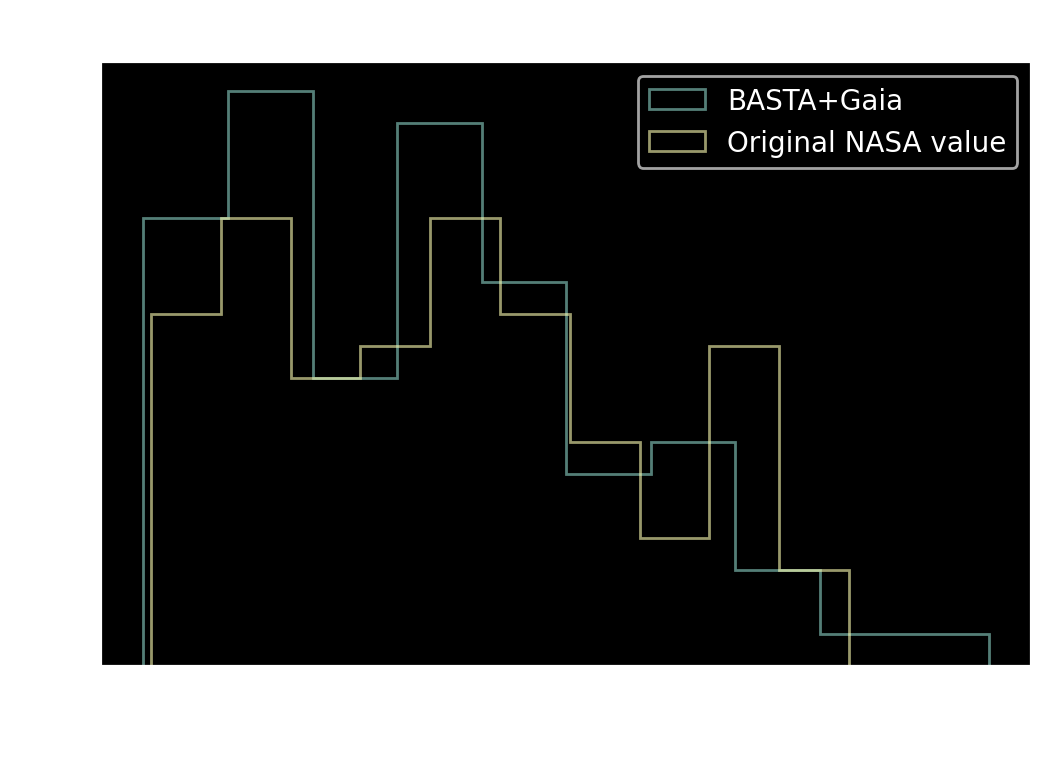

In [26]:
plt.hist(rp_gaia_earth, label='BASTA+Gaia', alpha=0.6,  histtype='step')
plt.xlabel(r'R$_p$ [R$_J$]')
plt.hist(rp_nasa_earth, label='Original NASA value', alpha=0.6,  histtype='step')
plt.xlabel(r'R$_p$ [R$_E$]')
plt.title('BASTA planet radii')

plt.legend()

plt.savefig('/Users/afw2/BASTA/Paper1/figures/nasa_basta_planet_radii.jpg')
plt.show()

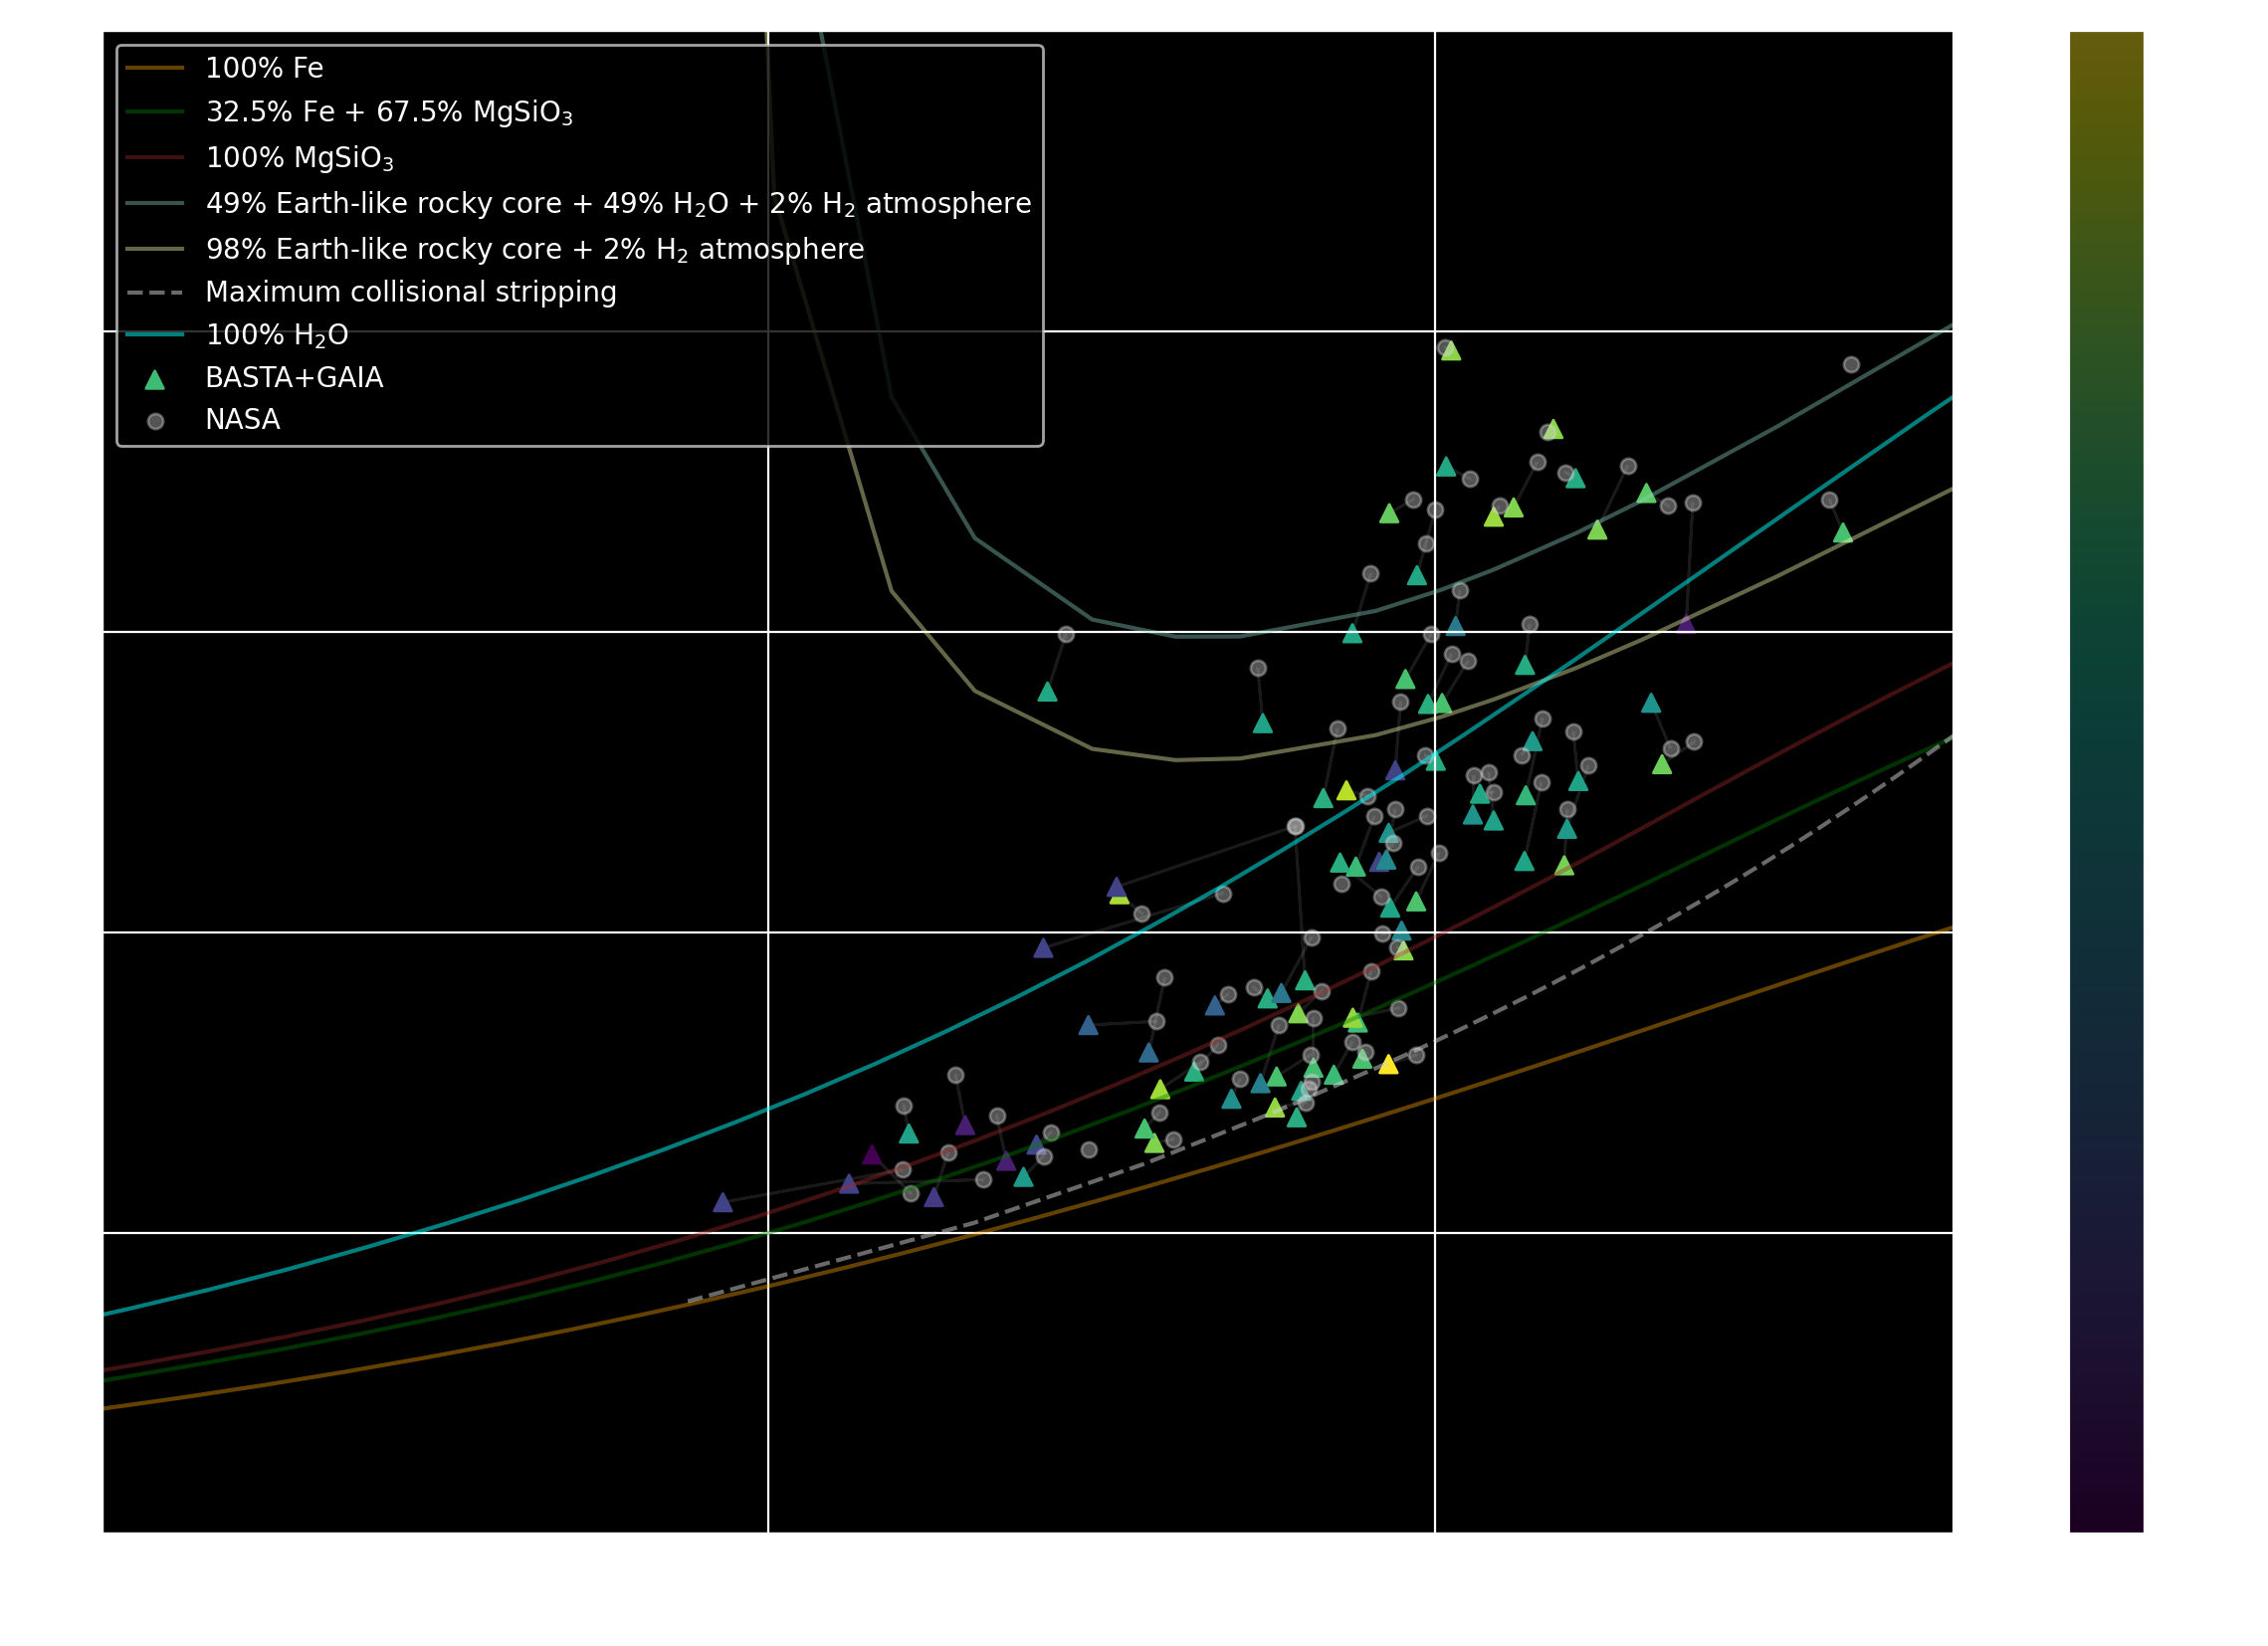

93 93 93 93 93 93


In [27]:

%matplotlib inline
dpi = 200
import matplotlib as mpl



mpl.rcParams['figure.dpi'] = dpi

re = c.R_earth
me = c.M_earth
mj = c.M_jup

ms_gaia = np.array(full_analysis['massfin_gaia'])
ms_nasa = np.array(full_analysis['st_mass'])

rp_gaia_earth = np.array((rad_gaia * rj.value) / re.value)
rp_nasa_earth = np.array((rad * rj.value) / re.value)

mp_gaia_earth = np.array((mp_basta_gaia * mj.value) / me.value)
mp_nasa_earth = np.array((mp_recalc * mj.value) / me.value)

fe_100 = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_fe.ascii', delim_whitespace=True)
earth = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/earth.ascii', delim_whitespace=True)
rock = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_rock.ascii', delim_whitespace=True)
h_cold = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/H_cold.ascii', delim_whitespace=True)
max_coll = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/max_coll_strip.ascii',
                             delim_whitespace=True)
h2o_100_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/h20_100_500k.ascii',
                                 delim_whitespace=True)
h2_2_earth_49_h2o_49_500k = pd.read_table(
        '/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_49_earth_49_h2O_500k.ascii', delim_whitespace=True)
h2_2_earth_98_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_98_earth_500k.ascii',
                                       delim_whitespace=True)


period = np.array(full_analysis['pl_orbper'])
#ax1 = plt.scatter(mass, rad, s=5, c='grey', alpha = 0.6, label = 'NASA')
#ax2 = plt.scatter(mass_gaia, rad_gaia, s=3, c='b', marker = '^', label = 'BASTA+GAIA')
#ax3 = plt.scatter(mass_sc, rad_sc, s=3, c='gold', marker = '^', label = 'BASTA+SC')
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(fe_100['Mass'], fe_100['Radius'], c = 'orange', label  = '100% Fe', alpha = 0.4)
plt.plot(earth['Mass'], earth['Radius'], c = 'green',  label  = f'32.5% Fe + 67.5% MgSiO$_3$', alpha = 0.4)
plt.plot(rock['Mass'], rock['Radius'],c = 'brown', label  = f'100% MgSiO$_3$', alpha = 0.4)
plt.plot(h2_2_earth_49_h2o_49_500k['Mass'], h2_2_earth_49_h2o_49_500k['Radius'], linestyle='-', label  = f'49% Earth-like rocky core + 49% H$_2$O + 2% H$_2$ atmosphere', alpha = 0.4)
plt.plot(h2_2_earth_98_500k['Mass'], h2_2_earth_98_500k['Radius'], linestyle='-', label  = f'98% Earth-like rocky core + 2% H$_2$ atmosphere', alpha = 0.4)
#plt.plot(h_cold['Mass'], h_cold['Radius'], label  = 'Cold Hydrogen')
plt.plot(max_coll['Mass'], max_coll['Radius'], linestyle='--', c='lightgrey', label  = 'Maximum collisional stripping', alpha = 0.5)
plt.plot(h2o_100_500k['Mass'], h2o_100_500k['Radius'], linestyle='-', c='cyan', label  = f'100% H$_2$O', alpha = 0.5)
plt.grid(True)
for i in range(len(ms_gaia)):
    plt.arrow(x=mp_nasa_earth[i], y=rp_nasa_earth[i], dx=(mp_gaia_earth[i] - mp_nasa_earth[i]), dy=(rp_gaia_earth[i] - rp_nasa_earth[i]), width=.000001,
              length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,
              head_starts_at_zero=False)

plt.scatter(mp_gaia_earth, rp_gaia_earth, s=40, marker='^', label='BASTA+GAIA',  c=ms_nasa, cmap = 'viridis')
plt.scatter(mp_nasa_earth, rp_nasa_earth, s=30, c='lightgrey', alpha=0.4, marker='o', label='NASA')



plt.legend()
plt.clim(0,1.5)
plt.xlim(0.1,60)
plt.ylim(0,5)
plt.colorbar(label=r'Stellar Mass M$_{\odot}$')

plt.xlabel(r'M$_p$ [M${\oplus}$]')
plt.ylabel(r'R$_p$ [R$_{\oplus}$]')  #plt.xscale('log')
plt.xscale('log')
#plt.yscale('log')
plt.legend()

plt.savefig('/Users/afw2/BASTA/Paper1/figures/mass_radius_comp.jpg')

plt.show()
print(len(mass), len(rad), len(mass_gaia), len(rad_gaia), len(mass_sc), len(rad_gaia))

In [28]:
nasa_mass_error_abs = (abs(full_analysis['st_masserr2'])+abs(full_analysis['st_masserr1']))
gaia_mass_error_abs = (abs(full_analysis['massfin_errp_gaia'])+abs(full_analysis['massfin_errm_gaia']))
sc_mass_error_abs = (abs(full_analysis['massfin_errp_sc'])+abs(full_analysis['massfin_errm_sc']))


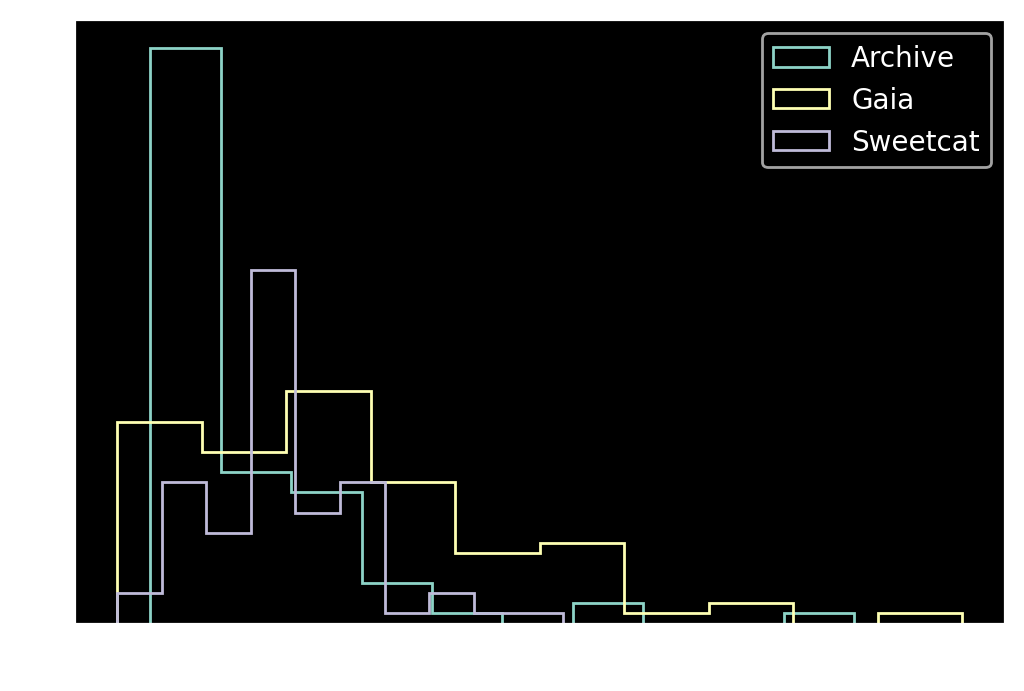

In [29]:
plt.hist(nasa_mass_error_abs, label='Archive', histtype='step')
plt.hist(gaia_mass_error_abs, label='Gaia',  histtype='step')
plt.hist(sc_mass_error_abs, label='Sweetcat',  histtype='step')
plt.legend()


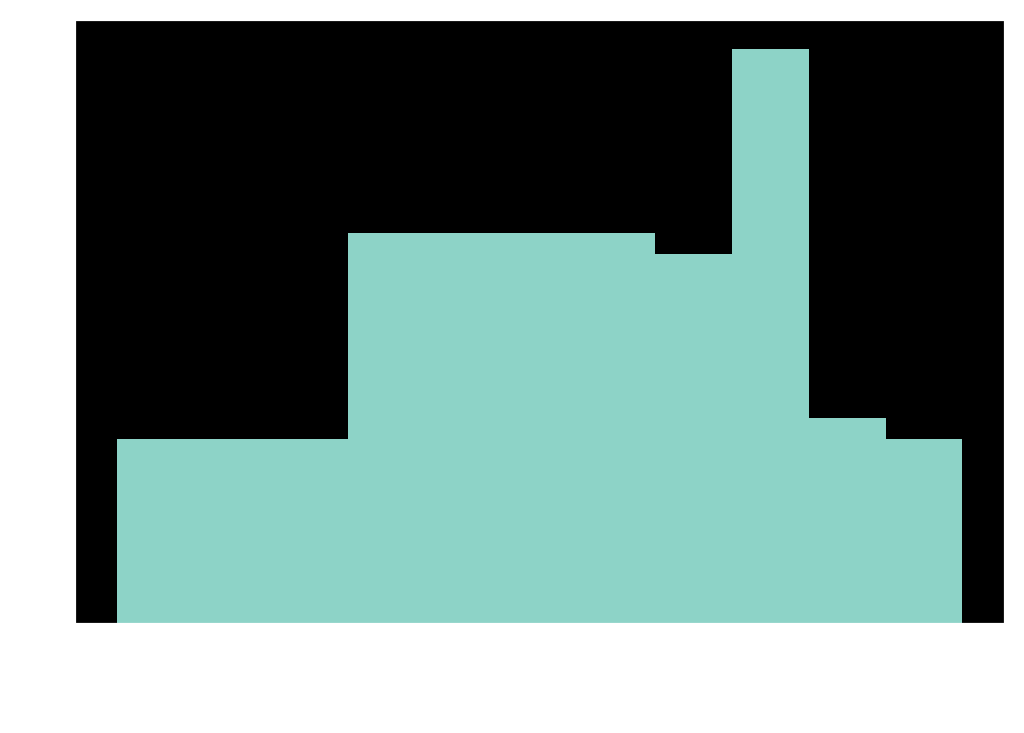

dict_keys(['m_0', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5'])


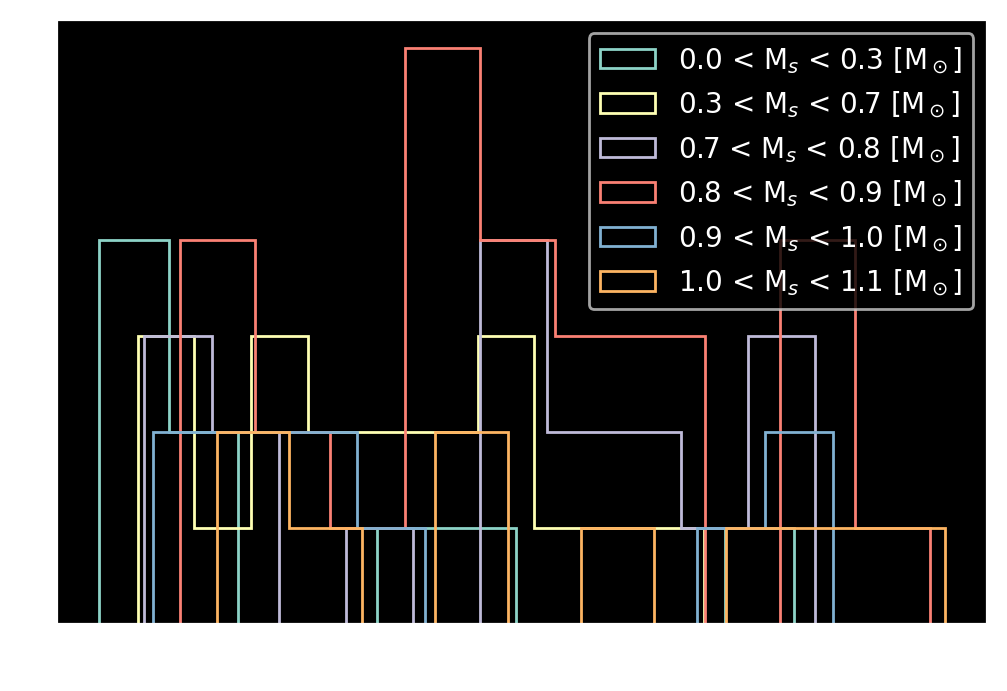

[0.  0.3 0.7 0.8 0.9 1.  1.1]
1.0832545569


In [30]:
#masses = plt.hist(full_analysis['massfin_gaia'])

def mass_split(table, colname, bins=[0,0.3,0.7,0.8,0.9,1,1.1]):
    masses = plt.hist(table[colname], bins=bins)
    bin_edges = masses[1]
    plt.xlabel(r'BASTA + GAIA stellar mass [M$_{\odot}$]')
    plt.show()

    masscuts = dict()

    for bin in range(len(bin_edges)-1):
        masscuts['m_{}'.format(bin)] = table[(table[colname] >= bin_edges[bin]) & (table[colname] < bin_edges[bin+1])]
    print((masscuts.keys()))

    for i in range(0,len(masscuts)):
        plt.hist(masscuts['m_{}'.format(i)]['pl_rade'], histtype='step', label =  r'{} < M$_s$ < {} [M$_\odot$]'.format(bin_edges[i], bin_edges[i+1]))
        plt.legend()
    plt.show()

    print(bin_edges)
    print(max(table[colname]))
    return masscuts

masses_split = mass_split(full_analysis, 'massfin_gaia')
#note this means 6 bins lol
#def plot_massbins(masses_split):



In [31]:
masses_split

{'m_0':      nea_dr3_tm_joiner_oid              gaia_id  ra_2_tm_join  dec_2_tm_join  \
 15                     248  5413438219396893568    153.708854     -47.154878   
 17                     159  6468968316900356736    306.928753     -56.462458   
 84                    1340  3311804515502788352     63.273952      15.247700   
 184                     48  5271055243163629056    124.532896     -68.314513   
 185                     48  5271055243163629056    124.532896     -68.314513   
 187                   4315   549007291282705024     44.339287      76.551349   
 210                    194  4781196115469953024     68.416099     -51.957431   
 211                    194  4781196115469953024     68.416099     -51.957431   
 212                    194  4781196115469953024     68.416099     -51.957431   
 
      parallax_tm_join original_ext_source_id  clean_tmass_psc_xsc_oid  \
 15          79.320578       10145184-4709244                106244827   
 17          49.055496       2027

In [32]:
masses_split['m_2']

nea_dr3_tm_joiner_oid              gaia_id  ra_2_tm_join  dec_2_tm_join  \
35                    4273  2248126315275354496    302.025678      66.850292   
36                    4273  2248126315275354496    302.025678      66.850292   
37                    4273  2248126315275354496    302.025678      66.850292   
41                    4329  2300641567596591488    325.202131      84.333770   
44                      89  4674216245427964416     55.459000     -62.767273   
52                    1142  2554032474712538880      8.740164       4.380697   
53                    1142  2554032474712538880      8.740164       4.380697   
69                    1043  2645940376800212096    353.954319       0.444678   
70                    4308  2288221003213039488    296.244630      74.062862   
77                     815  3580920878437938688    182.751398      -9.765240   
80                    1255   600750922666388992    126.464372      10.246565   
90                    1471  3409148746676599168     76.445945      21.548186   
177                   3644  2119602202081351168    281.194730      47.497264   
182                   2280  2076871091425583232    297.354000      41.300045   
192                    242  6683371847364921088    296.003934     -47.562045   
213                    689  2984582227215748864     81.853277     -14.276733   
215                    459  2908664557091200768     83.269253     -26.723849   
217                    459  2908664557091200768     83.269253     -26.723849   

     parallax_tm_join original_ext_source_id  clean_tmass_psc_xsc_oid  \
35          18.696709       20080574+6651019                462356351   
36          18.696709       20080574+6651019                462356351   
37          18.696709       20080574+6651019                462356351   
41          35.358132       21404490+8420005                470692631   
44          25.581744       03415036-6246014                 32737656   
52          21.136284       00345752+0422531                306598265   
53          21.136284       00345752+0422531                306598265   
69          15.969598       23354927+0026436                294666704   
70          15.142449       19445865+7403457                467753812   
77           6.478551       12110036-0945547                261077699   
80           4.913038       08255135+1014491                324102946   
90          11.171355       05054699+2132552                357077550   
177          5.247636       18444674+4729496                423430851   
182          4.801422       19492496+4118001                408753408   
192         14.562228       19440094-4733417                104463254   
213         13.333711       05272482-1416370                245132223   
215         30.651669       05330459-2643286                194648455   
217         30.651669       05330459-2643286                194648455   

          ra_tm     dec_tm  err_maj  ...  FeH_errp_sc  radPhot_sc  \
35   302.023958  66.850533     0.13  ...       0.0000    0.887590   
36   302.023958  66.850533     0.13  ...       0.0000    0.887590   
37   302.023958  66.850533     0.13  ...       0.0000    0.887590   
41   325.187114  84.333473     0.20  ...       0.0303    0.742245   
44    55.459851 -62.767059     0.16  ...       0.0501    0.687673   
52     8.739695   4.381432     0.07  ...       0.0498    0.847885   
53     8.739695   4.381432     0.07  ...       0.0498    0.847885   
69   353.955319   0.445452     0.12  ...       0.0000    0.717086   
70   296.244403  74.062714     0.10  ...       0.1877    0.829792   
77   182.751530  -9.765198     0.15  ...       0.0000    0.737607   
80   126.463978  10.246981     0.07  ...       0.0000    0.738132   
90    76.445799  21.548677     0.07  ...       0.0377    0.876405   
177  281.194750  47.497135     0.07  ...       0.0500    0.747899   
182  297.354004  41.300049     0.06  ...       0.1377    0.741437   
192  296.003920 -47.561596     0.07  ...       0.1426    0.70

In [33]:
def planet_mass(m_star_colname, df, Msini_units='earth'):
    #stole this from radvel - maybe recalculate
    """Calculate Msini

    Calculate Msini for a given K, P, stellar mass, and e

    Args:
        K (float or array: Doppler semi-amplitude [m/s]
        P (float or array): Orbital period [days]
        Mstar (float or array): Mass of star [Msun]
        e (float or array): eccentricity
        Msini_units (Optional[str]): Units of Msini {'earth','jupiter'}
            default: 'earth'

    Returns:
        float or array: Msini [units = Msini_units]

    """
    m_star = df[m_star_colname]
    # convert inputs to array so they work with units
    P = np.array(df['pl_orbper'])
    Mstar = np.array(m_star)
    K = np.array(df['pl_rvamp'])
    e = np.array(df['pl_orbeccen'])
    G = c.G.value                # added gravitational constant
    Mjup = c.M_jup.value         # added Jupiter's mass
    Msun = c.M_sun.value         # added sun's mass
    Mstar = Mstar*Msun
    Mstar = np.array(Mstar)
    K_0 = 28.4329

    incl = df['pl_orbincl']


    P_year = (P * u.d).to(u.year).value
    P = (P * u.d).to(u.second).value

    # First assume that Mp << Mstar
    Msini = K / K_0 * np.sqrt(1.0 - e ** 2.0) * (Mstar/Msun) ** (2.0 / 3.0) * P_year ** (1 / 3.0)

    # Use correct calculation if any elements are >10% of the stellar mass
    if (np.array(((Msini * u.Mjup).to(u.M_sun) / (Mstar/Msun)).value > 0.10)).any():
        warnings.warn("Mpsini << Mstar assumption broken, correcting Msini calculation.")

        a = K*(((2*(np.pi)*G)/P)**(-1/3.))*np.sqrt(1-(e**2))
        Msini = []
        if isinstance(P, float):
            n_elements = 1
        else:
            assert type(K) == type(P) == type(Mstar) == type(e), "All input data types must match."
            assert K.size == P.size == Mstar.size == e.size, "All input arrays must have the same length."
            n_elements = len(P)
        for i in range(n_elements):
            def func(x):
                try:
                    return x - a[i]*((Mstar[i]+x)**(2/3.))
                except IndexError:
                    return x - a * ((Mstar + x) ** (2 / 3.))

            sol = root(func, Mjup)
            Msini.append(sol.x[0])

        Msini = np.array(Msini)
        Msini = Msini/Mjup

    if Msini_units.lower() == 'jupiter':
        pass
    elif Msini_units.lower() == 'earth':
        Msini = (Msini * u.M_jup).to(u.M_earth).value
    else:
        raise Exception("Msini_units must be 'earth', or 'jupiter'")


    mp_recalc = Msini / np.sin(np.deg2rad(incl))

    return mp_recalc

mp_recalc = planet_mass('st_mass', masses_split['m_0'], Msini_units='earth')
mp_basta_gaia =  planet_mass('massfin_gaia', masses_split['m_0'], Msini_units='earth')
mp_basta_sc =  planet_mass('massfin_sc',masses_split['m_0'], Msini_units='earth')

print(mp_basta_gaia)
print(mp_recalc)


15      1.429863
17      1.321030
84     23.832265
184     2.274110
185     1.973343
187          NaN
210     0.854003
211     3.329235
212     2.585195
Name: pl_orbincl, dtype: float64
15      1.633692
17      2.097611
84     24.382219
184     2.200310
185     1.909303
187          NaN
210     1.587016
211     6.186809
212     4.804138
Name: pl_orbincl, dtype: float64


In [34]:
def new_r(df, radius_col_name):

    rj = c.R_jup
    rs = c.R_sun
    re = c.R_earth
#normalising constant
    r_norm = rs / re

    incl = df['pl_orbincl']
    ecc = df['pl_orbeccen']
    p = df['pl_orbper']

    rat = df['pl_ratror']
    r_first = df['pl_radj']

    r_new = (rat* df[radius_col_name])*r_norm
    return r_new

rp_recalc = new_r(masses_split['m_0'], 'st_rad')
rp_basta_gaia = new_r(masses_split['m_0'], 'radPhot_gaia')
rp_basta_sc = new_r(masses_split['m_0'], 'radPhot_sc')

rp_recalc
rp_basta_gaia

15     1.260527
17     1.163662
84     3.025867
184    1.239707
185    1.358583
187    1.151781
210    1.101872
211    2.151291
212    1.948275
dtype: float64

m_0
[0, 0]
9
m_1
[0, 1]
19
m_2
[0, 2]
18
m_3
[1, 0]
28
m_4
[1, 1]
10
m_5
[1, 2]
9


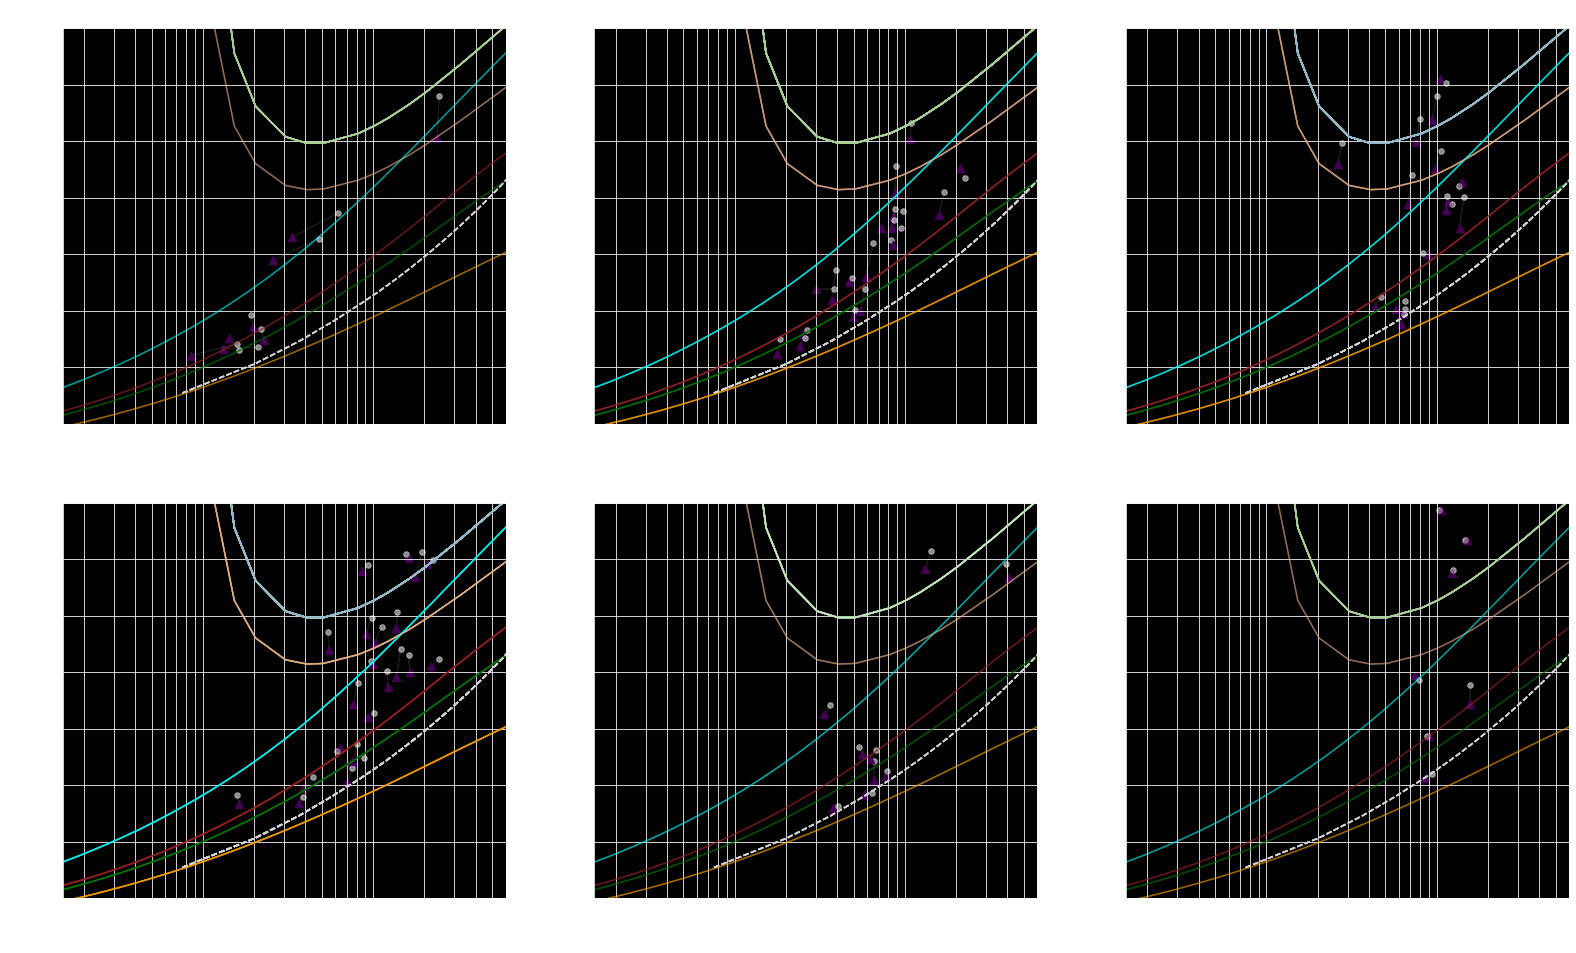

In [36]:
%matplotlib inline
import matplotlib
dpi = 200
def m_r_plot_masses(masses_split):
    plt.rcParams.update({'font.size': 15})

    fe_100 = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_fe.ascii', delim_whitespace=True)
    earth = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/earth.ascii', delim_whitespace=True)
    rock = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_rock.ascii', delim_whitespace=True)
    h_cold = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/H_cold.ascii', delim_whitespace=True)
    max_coll = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/max_coll_strip.ascii', delim_whitespace=True)
    h2o_100_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/h20_100_500k.ascii', delim_whitespace=True)
    h2_2_earth_49_h2o_49_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_49_earth_49_h2O_500k.ascii', delim_whitespace=True)
    h2_2_earth_98_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_98_earth_500k.ascii', delim_whitespace=True)


    fig, ax = plt.subplots(2,3, figsize=(27, 16))
    for i in masses_split:
        print(i)
        m_i = '{}'.format(i)
        intm = int(i.strip('m_'))
        if intm <= 2:
            i_x = 0
            i_y = intm
        else:
            i_x = 1
            i_y = intm-3

        print([i_x, i_y])

        mp_old = np.array(planet_mass('st_mass', masses_split[m_i], Msini_units='earth'))
        mp_new =  np.array(planet_mass('massfin_gaia', masses_split[m_i], Msini_units='earth'))

        rp_old = np.array(new_r(masses_split[m_i], 'st_rad'))
        rp_new = np.array(new_r(masses_split[m_i], 'radPhot_gaia'))
        st_mass = np.array(masses_split[m_i]['massfin_gaia'])

        print(len(st_mass))

        for j in range(0,len(st_mass)):
            ax[i_x, i_y].arrow(x=mp_old[j], y=rp_old[j], dx=(mp_new[j] - mp_old[j]), dy=(rp_new[j]- rp_old[j]), width=.000001,
            length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,
            head_starts_at_zero=False)

            ax[i_x, i_y].scatter(mp_new[j], rp_new[j], s=50, marker='^', label='BASTA+GAIA',  c=st_mass[j], cmap = 'viridis')
            ax[i_x, i_y].scatter(mp_old[j], rp_old[j], s=30, c='lightgrey', alpha=0.4, marker='o', label='NASA')
            #ax[i_x, i_y].legend()
            ax[i_x, i_y].set_xlabel(r'M$_p$ [M$_E$]')
            ax[i_x, i_y].set_ylabel(r'R$_p$ [R$_E$]')  #plt.xscale('log')
            #ax[i_x, i_y].set_xscale('log')
            ax[i_x, i_y].grid(True, which="both")
            ax[i_x, i_y].set_title(r'{} < M$_s$ [M$_\odot$] < {}'.format(min(st_mass), max(st_mass)))
            ax[i_x, i_y].plot(fe_100['Mass'], fe_100['Radius'], c = 'orange', label  = '100% Fe', alpha = 0.1)
            ax[i_x, i_y].plot(earth['Mass'], earth['Radius'], c = 'green',  label  = f'32.5% Fe + 67.5% MgSiO$_3$', alpha = 0.1)
            ax[i_x, i_y].plot(rock['Mass'], rock['Radius'],c = 'brown', label  = f'100% MgSiO$_3$', alpha = 0.1)
            ax[i_x, i_y].plot(h2_2_earth_49_h2o_49_500k['Mass'], h2_2_earth_49_h2o_49_500k['Radius'], linestyle='-', label  = f'49% Earth-like rocky core + 49% H$_2$O + 2% H$_2$ atmosphere', alpha = 0.8)
            ax[i_x, i_y].plot(h2_2_earth_98_500k['Mass'], h2_2_earth_98_500k['Radius'], linestyle='-', label  = f'98% Earth-like rocky core + 2% H$_2$ atmosphere', alpha = 0.1)
            #plt.plot(h_cold['Mass'], h_cold['Radius'], label  = 'Cold Hydrogen')
            ax[i_x, i_y].plot(max_coll['Mass'], max_coll['Radius'], linestyle='--', c='lightgrey', label  = 'Maximum collisional stripping', alpha = 0.5)
            ax[i_x, i_y].plot(h2o_100_500k['Mass'], h2o_100_500k['Radius'], linestyle='-', c='cyan', label  = f'100% H$_2$O', alpha = 0.1)

            ax[i_x, i_y].scatter(mp_new[j], rp_new[j], s=70, marker='^', label='BASTA+GAIA',  c=st_mass[j], cmap = 'viridis')
            ax[i_x, i_y].scatter(mp_old[j], rp_old[j], s=30, c='lightgrey', alpha=0.4, marker='o', label='NASA')

            ax[i_x, i_y].set_xscale('log')
            ax[i_x, i_y].set_xlim(0.15,60)
            ax[i_x, i_y].set_ylim(0.5,4)

    plt.savefig('/Users/afw2/BASTA/Paper1/figures/mass_split_mass_radius_comp.pdf')
    plt.show()

m_r_plot_masses(masses_split)

In [38]:
df = full_analysis

In [39]:
mp_new

NameError: name 'mp_new' is not defined

In [40]:
rp_old = np.array(df['pl_rade'])
re = c.R_earth.value
rj = c.R_jup.value
rp_gaia_earth = np.array((r_1 * rj) / re)
rp_nasa_earth = np.array(rp_old)

df['rp_1'] = rp_gaia_earth
df['mp_new'] = np.array(mp_gaia_earth)

st_mass_old = np.array(df['st_mass'])
st_mass_new = np.array(df['massfin_gaia'])

period  = np.array(df['pl_orbper'])
age_old = np.array(df['st_age'])
age_new = np.array(df['age_gaia']/1000)
# now plotting st_mass valley


period_grad = -0.11
period_intercept = 0.37

x = np.linspace(0.1, 100, 1000)
y = 10 ** (period_grad * np.log10(x) + period_intercept)
y_up = 10 ** ((period_grad) * np.log10(x) + period_intercept + 0.02)
y_lo = 10 ** ((period_grad) * np.log10(x) + period_intercept - 0.02)

# could change this to be bigger errors - have not included different gradients that cynthia used


In [41]:
df_below = df[df['rp_1']<= (10 ** (period_grad * np.log10(df['pl_orbper']) + period_intercept))]
df_above = df[df['rp_1']> (10 ** (period_grad * np.log10(df['pl_orbper']) + period_intercept))]

In [42]:
df_above

nea_dr3_tm_joiner_oid              gaia_id  ra_2_tm_join  dec_2_tm_join  \
13                     654  6259263137059042048    228.248237     -16.724652   
14                     654  6259263137059042048    228.248237     -16.724652   
18                      84  4673947174316727040     51.750299     -63.500200   
33                     446  5068777809824976256     36.867873     -27.636147   
34                     175  6641996571978861440    293.286641     -54.532740   
35                    4273  2248126315275354496    302.025678      66.850292   
36                    4273  2248126315275354496    302.025678      66.850292   
37                    4273  2248126315275354496    302.025678      66.850292   
41                    4329  2300641567596591488    325.202131      84.333770   
44                      89  4674216245427964416     55.459000     -62.767273   
53                    1142  2554032474712538880      8.740164       4.380697   
57                       6  4623036865373793408     84.299541     -80.464458   
59                       4  4617759514501503616     12.546957     -83.743763   
61                    1233  3145754895088191744    117.924631       9.385215   
62                    1233  3145754895088191744    117.924631       9.385215   
64                     721  5746824674801810816    129.688293     -13.256521   
68                    1536  3997075206232885888    168.637642      25.710603   
69                    1043  2645940376800212096    353.954319       0.444678   
74                     740  3613175223837135616    207.349747     -12.284932   
80                    1255   600750922666388992    126.464372      10.246565   
84                    1340  3311804515502788352     63.273952      15.247700   
86                    1078  2657374606238804992    349.384348       1.300147   
87                    1078  2657374606238804992    349.384348       1.300147   
91                     812  3616931735377523712    205.375866      -9.946070   
92                     988  3796690380302214272    172.335384      -1.455147   
102                   2141  2101507367429089664    291.148103      40.669414   
116                   3592  2119583201145735808    281.482465      47.207820   
130                   2418  2076960598545789824    297.115095      41.909108   
139                   2193  2102110174677569664    288.530894      40.942375   
145                   1682  2051106987063242880    290.420974      37.851651   
162                   2196  2075112109039378688    299.139312      40.948936   
177                   3644  2119602202081351168    281.194730      47.497264   
179                   2968  2106705269988803072    284.482427      44.397887   
189                    760  3767281845873242112    154.644855     -11.717835   
190                     12  4632865331094140928     38.121040     -78.023679   
192                    242  6683371847364921088    296.003934     -47.562045   
195                   4267  1053809778428567680    157.144011      65.854187   
200                    274  6520880040423258240    338.399669     -43.436879   
205                   4247  2216420110788943744    326.851609      62.753815   
208                     95  5481210874877547904     91.799694     -61.997219   
209                    178  4770828304936109056     75.846289     -54.177738   
211                    194  4781196115469953024     68.416099     -51.957431   
212                    194  4781196115469953024     68.416099     -51.957431   
213                    689  2984582227215748864     81.853277     -14.276733   
219                   1183  3850421005290172416    148.185136       6.216095   
220                   1183  3850421005290172416    148.185136       6.216095   
221                   1183  3850421005290172416    148.185136       6.216095   
223                    314  6140553127216043648    194.468084     -39.758073   
224                    314  6140553127216043648    194.468084     -39.758073   
225  

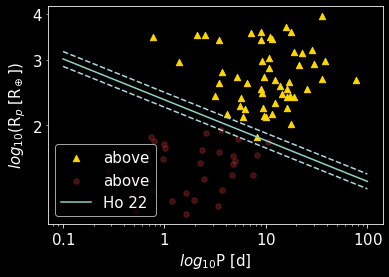

In [43]:
plt.style.use('dark_background')

plt.scatter((df_above['pl_orbper']), (df_above['rp_1']), s=40, c='gold', marker='^', label='above')
plt.scatter((df_below['pl_orbper']), (df_below['rp_1']), s=30, c='brown', alpha=0.4, marker='o' ,label='above')

plt.plot(x, y, label='Ho 22')
plt.plot(x, y_up, c='lightblue', linestyle='--')
plt.plot(x, y_lo, c='lightblue', linestyle='--')
plt.xlabel(r'$log_{10}$P [d]')
plt.ylabel(r'$log_{10}$(R$_p$ [R$_\oplus$])')
plt.xscale('log')
plt.yscale('log')

plt.legend()

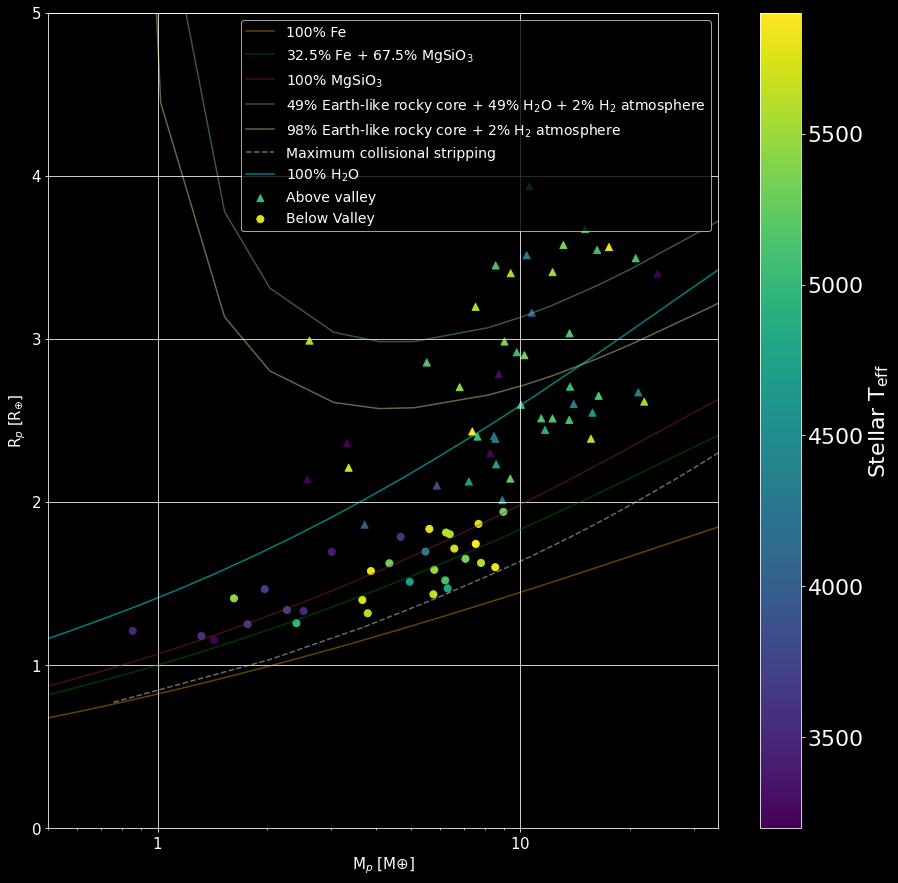

In [44]:
mp_old = np.array(df['pl_bmasse'])
ms = np.array(df['massfin_gaia'])
fig, ax = plt.subplots(figsize=(15, 15))

plt.rc('font', size=22)
plt.rc('axes', titlesize=22)
plt.rc('legend', fontsize=14)

    #PLotting planet composition thoretical tracks

    #importing the values from files

fe_100 = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_fe.ascii', delim_whitespace=True)
earth = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/earth.ascii', delim_whitespace=True)
rock = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_rock.ascii', delim_whitespace=True)
h_cold = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/H_cold.ascii', delim_whitespace=True)
max_coll = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/max_coll_strip.ascii',
                             delim_whitespace=True)
h2o_100_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/h20_100_500k.ascii',
                                 delim_whitespace=True)
h2_2_earth_49_h2o_49_500k = pd.read_table(
        '/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_49_earth_49_h2O_500k.ascii', delim_whitespace=True)
h2_2_earth_98_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_98_earth_500k.ascii',
                                       delim_whitespace=True)

plt.plot(fe_100['Mass'], fe_100['Radius'], c='orange', label='100% Fe', alpha=0.4)
plt.plot(earth['Mass'], earth['Radius'], c='green', label=f'32.5% Fe + 67.5% MgSiO$_3$', alpha=0.4)
plt.plot(rock['Mass'], rock['Radius'], c='brown', label=f'100% MgSiO$_3$', alpha=0.4)
plt.plot(h2_2_earth_49_h2o_49_500k['Mass'], h2_2_earth_49_h2o_49_500k['Radius'], linestyle='-',
             label=f'49% Earth-like rocky core + 49% H$_2$O + 2% H$_2$ atmosphere', alpha=0.4)
plt.plot(h2_2_earth_98_500k['Mass'], h2_2_earth_98_500k['Radius'], linestyle='-',
             label=f'98% Earth-like rocky core + 2% H$_2$ atmosphere', alpha=0.4)
    # plt.plot(h_cold['Mass'], h_cold['Radius'], label  = 'Cold Hydrogen')
plt.plot(max_coll['Mass'], max_coll['Radius'], linestyle='--', c='lightgrey', label='Maximum collisional stripping',
             alpha=0.5)
plt.plot(h2o_100_500k['Mass'], h2o_100_500k['Radius'], linestyle='-', c='cyan', label=f'100% H$_2$O', alpha=0.5)


plt.grid(True)

plt.scatter(df_above['mp_new'], df_above['rp_1'], s=50, c=df_above['Teff_gaia'], marker='^', label='Above valley')
plt.scatter(df_below['mp_new'], df_below['rp_1'], s=50, c=df_below['Teff_gaia'], alpha=1, marker='o', label='Below Valley')

plt.clim()
plt.colorbar(label=r'Stellar T$_{\rm{eff}}$')

plt.legend()

plt.xlim(0.5, 35)
plt.ylim(0, 5)


plt.xlabel(r'M$_p$ [M${\oplus}$]')
plt.ylabel(r'R$_p$ [R$_{\oplus}$]')
plt.xscale('log')
# plt.yscale('log')
plt.legend()

TypeError: __init__() got an unexpected keyword argument 'n_rows'

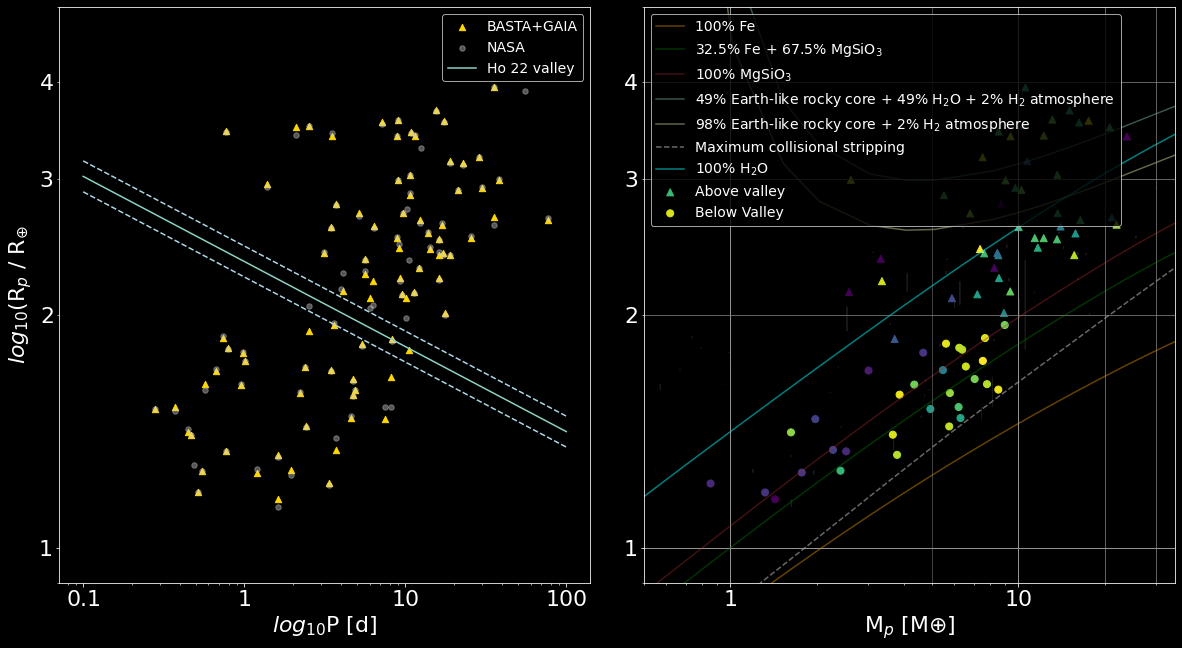

In [82]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

mass_grad = -0.11
mass_intercept = 0.37

plt.rc('font', size=22)
plt.rc('axes', titlesize=22)
plt.rc('legend', fontsize=14)

x = np.linspace(0.1,100,1000)
y = 10**(mass_grad*np.log10(x) + mass_intercept)
y_up = 10**((mass_grad)*np.log10(x) + mass_intercept+0.02)
y_lo = 10**((mass_grad)*np.log10(x) + mass_intercept-0.02)

#plt.setp(ax, ylim=ax[1].get_ylim())
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.3)

plt.grid(True)
for i in range(len(mass)):
    plt.arrow(x=period[i],y=rp_nasa_earth[i], dx=(0), dy=(rp_gaia_earth[i]-rp_nasa_earth[i]), width=.000001,length_includes_head=True, head_width=.0009, head_length=.0009, facecolor='k', alpha=0.1,head_starts_at_zero=False)

ax[0].scatter((period), (rp_gaia_earth), s=40, c='gold', marker = '^', label = 'BASTA+GAIA')
ax[0].scatter((period),(rp_nasa_earth), s=30, c='lightgrey', alpha = 0.4, marker = 'o', label = 'NASA')

ax[0].plot(x, y, label = 'Ho 22 valley')
ax[0].plot(x, y_up, c = 'lightblue', linestyle='--')
ax[0].plot(x, y_lo, c = 'lightblue', linestyle='--')

ax[0].set_xlabel(r'$log_{10}$P [d]')
ax[0].set_ylabel(r'$log_{10}$(R$_p$ / R$_{\oplus}$')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(0.9, 5)

for i in [1,2,3,4]:
    ax[1].axhline(i, color='gray', linewidth=0.5)
for i in [1,10,20,30,50,60,70,80]:
    ax[1].axvline(i, color='gray', linewidth=0.5)

ax[0].legend()

mp_old = np.array(df['pl_bmasse'])
ms = np.array(df['massfin_gaia'])

    #PLotting planet composition thoretical tracks
    #importing the values from files

fe_100 = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_fe.ascii', delim_whitespace=True)
earth = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/earth.ascii', delim_whitespace=True)
rock = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_rock.ascii', delim_whitespace=True)
h_cold = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/H_cold.ascii', delim_whitespace=True)
max_coll = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/max_coll_strip.ascii',
                             delim_whitespace=True)
h2o_100_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/h20_100_500k.ascii',
                                 delim_whitespace=True)
h2_2_earth_49_h2o_49_500k = pd.read_table(
        '/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_49_earth_49_h2O_500k.ascii', delim_whitespace=True)
h2_2_earth_98_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_98_earth_500k.ascii',
                                       delim_whitespace=True)





ax[1].plot(fe_100['Mass'], fe_100['Radius'], c='orange', label='100% Fe', alpha=0.4)
ax[1].plot(earth['Mass'], earth['Radius'], c='green', label=f'32.5% Fe + 67.5% MgSiO$_3$', alpha=0.4)
ax[1].plot(rock['Mass'], rock['Radius'], c='brown', label=f'100% MgSiO$_3$', alpha=0.4)
ax[1].plot(h2_2_earth_49_h2o_49_500k['Mass'], h2_2_earth_49_h2o_49_500k['Radius'], linestyle='-',
             label=f'49% Earth-like rocky core + 49% H$_2$O + 2% H$_2$ atmosphere', alpha=0.4)
ax[1].plot(h2_2_earth_98_500k['Mass'], h2_2_earth_98_500k['Radius'], linestyle='-',
             label=f'98% Earth-like rocky core + 2% H$_2$ atmosphere', alpha=0.4)
    # plt.plot(h_cold['Mass'], h_cold['Radius'], label  = 'Cold Hydrogen')
ax[1].plot(max_coll['Mass'], max_coll['Radius'], linestyle='--', c='lightgrey', label='Maximum collisional stripping',
             alpha=0.5)
ax[1].plot(h2o_100_500k['Mass'], h2o_100_500k['Radius'], linestyle='-', c='cyan', label=f'100% H$_2$O', alpha=0.5)


#ax[1].grid(True)

ax[1].scatter(df_above['mp_new'], df_above['rp_1'], s=50, c=df_above['Teff_gaia'], marker='^', label='Above valley')
ax[1].scatter(df_below['mp_new'], df_below['rp_1'], s=50, c=df_below['Teff_gaia'], alpha=1, marker='o', label='Below Valley')


ax[1].set_yticks([1,2,3,4], major = True)
ax[1].set_xticks([1,5,10,20,30], major = True)

for i in [1,2,3,4]:
    ax[1].axhline(i, color='gray', linewidth=0.5)
    ax[1].set_yticks(i)
    ax[1].set_yticklabels(i)


for i in [1,5,10,20,30]:
    ax[1].axvline(i, color='gray', linewidth=0.5)


plt.legend()

ax[1].set_xlim(0.5, 35)
ax[1].set_ylim(0.9, 5)
ax[1].set_yscale('log')

ax[1].set_xlabel(r'M$_p$ [M${\oplus}$]')
ax[1].set_xscale('log')
ax[1].legend(loc = 'upper left', n_rows = 2 )


plt.savefig('/Users/afw2/BASTA/Paper1/figures/radius_valley_period_mass_radius.jpg')
plt.show()

In [ ]:
plt.scatter(df_above['FeH_gaia'], df_above['rp_1'], s=40, c='gold', marker='^', label='above')
plt.scatter(df_below['FeH_gaia'], df_below['rp_1'], s=30, c='brown', alpha=0.4, marker='o', label='below')


plt.xlabel('FeH(dex)')
plt.ylabel('R(Re)')
plt.legend()


plt.show()

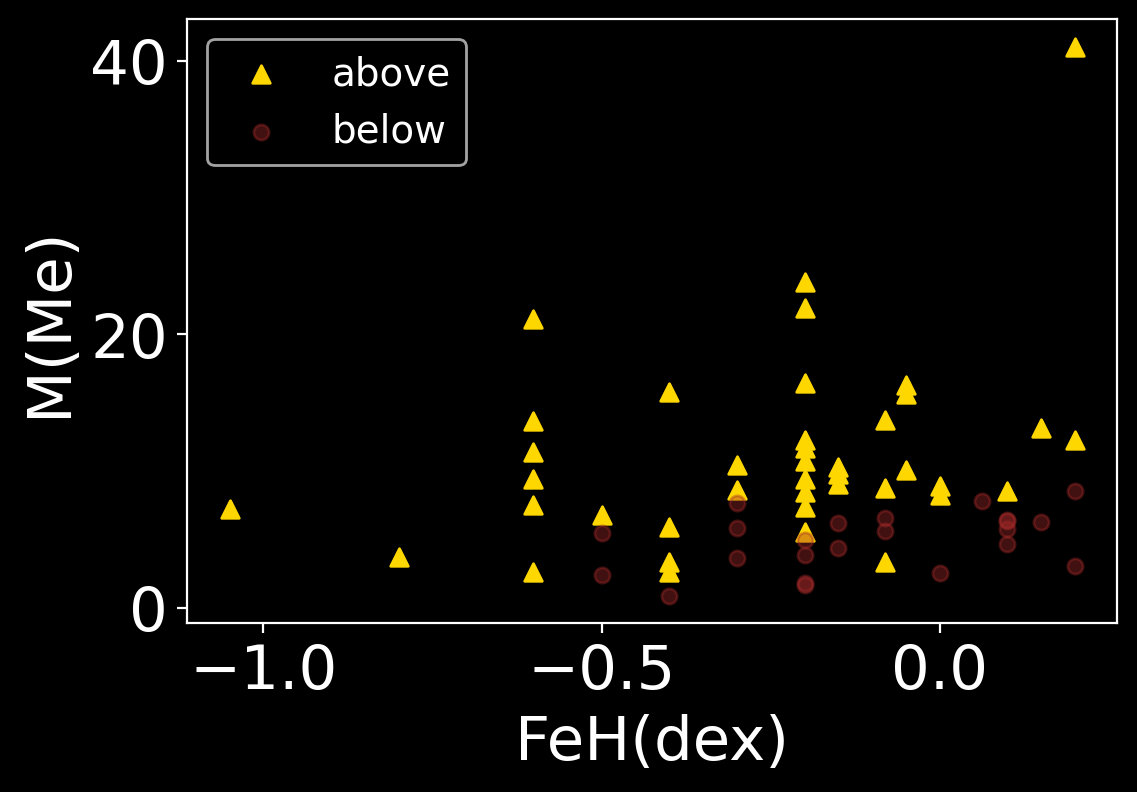

In [85]:
plt.scatter(df_above['FeH_gaia'], df_above['mp_new'], s=40, c='gold', marker='^', label='above')
plt.scatter(df_below['FeH_gaia'], df_below['mp_new'], s=30, c='brown', alpha=0.4, marker='o', label='below')


plt.xlabel('FeH(dex)')
plt.ylabel('M(Me)')
plt.legend()


plt.show()

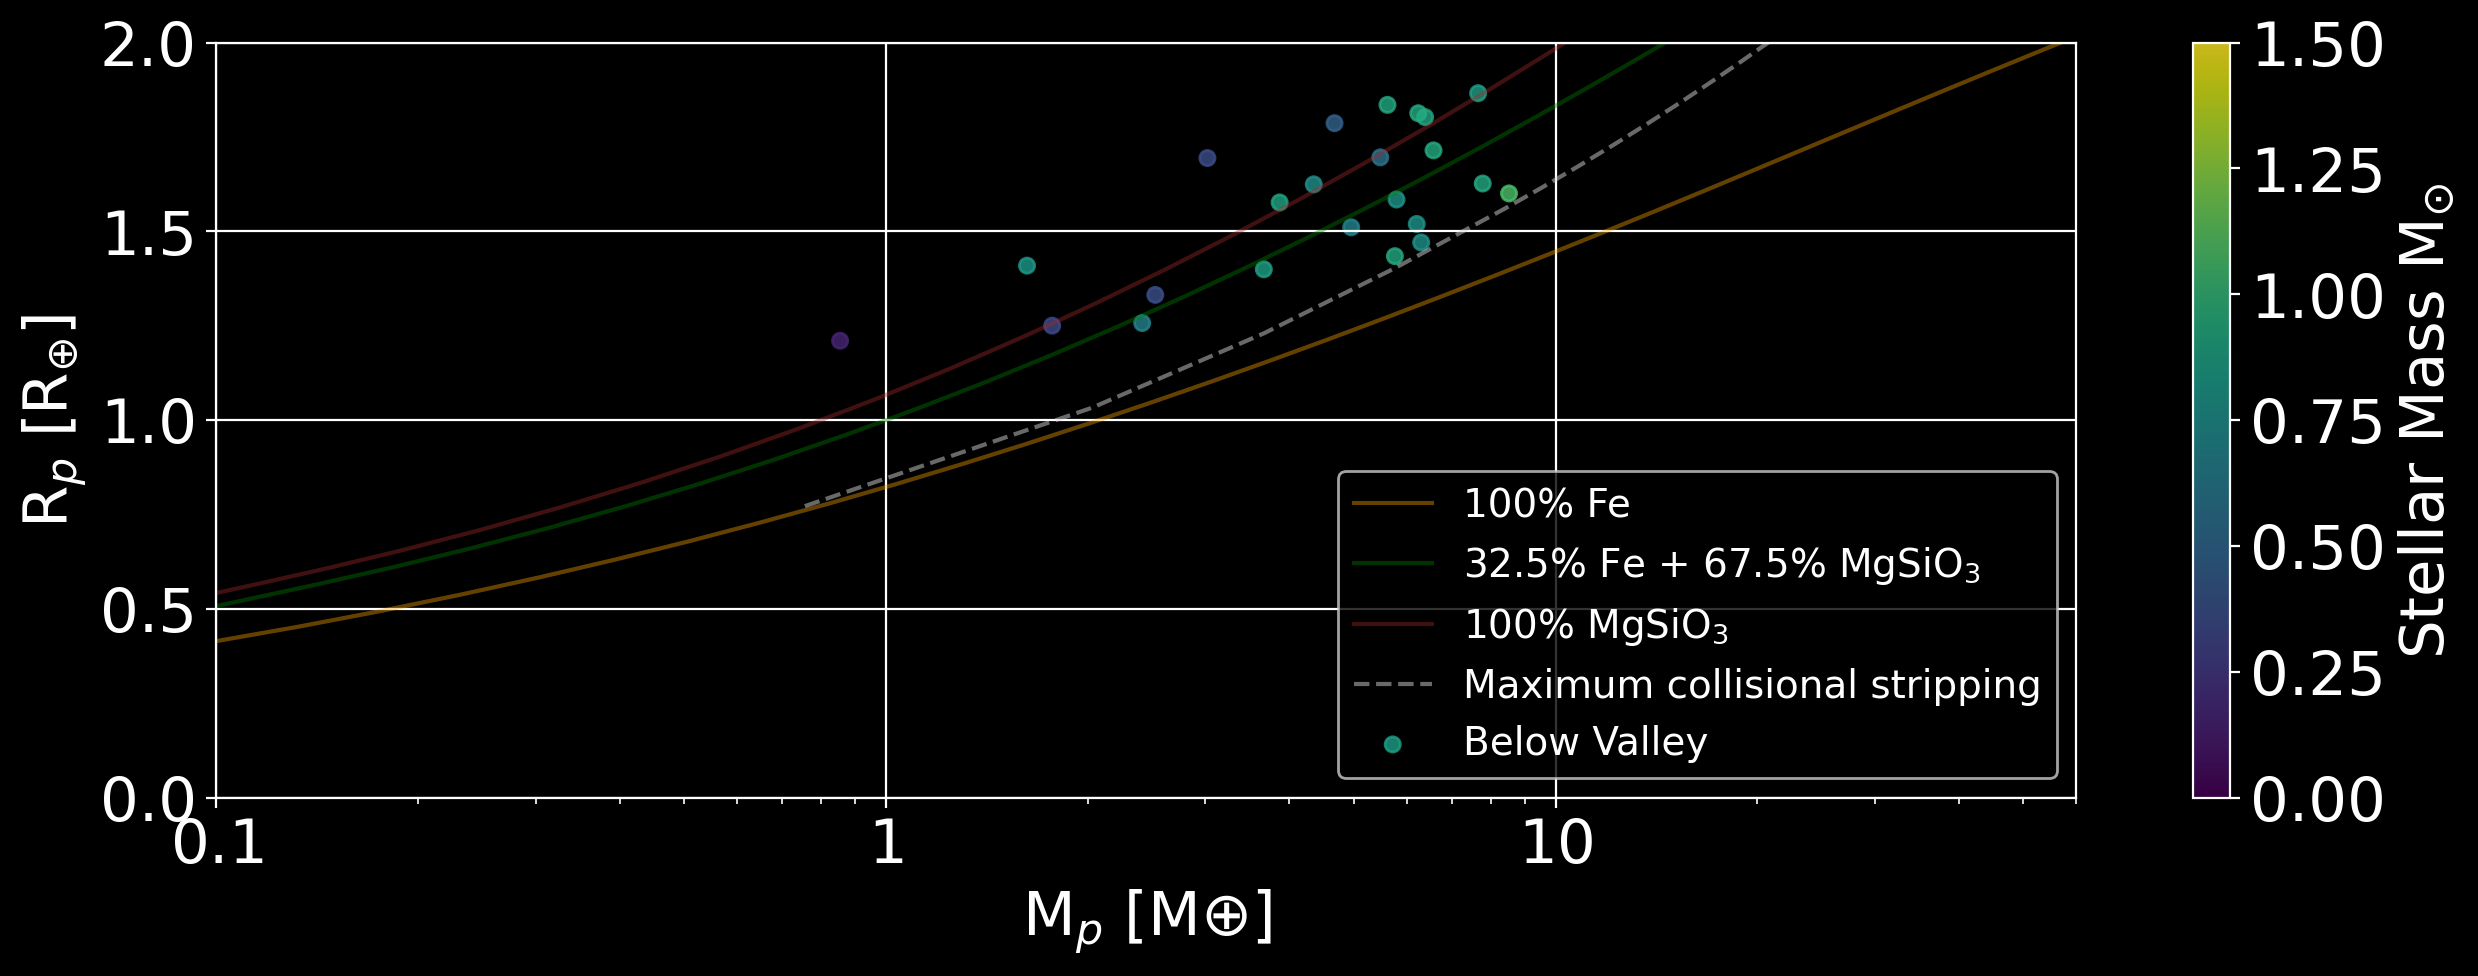

In [115]:
mp_old = np.array(df['pl_bmasse'])
ms = np.array(df['massfin_gaia'])
fig, ax = plt.subplots(figsize=(15, 5))

    #PLotting planet composition thoretical tracks

    #importing the values from files

fe_100 = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_fe.ascii', delim_whitespace=True)
earth = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/earth.ascii', delim_whitespace=True)
rock = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/100_rock.ascii', delim_whitespace=True)
h_cold = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/H_cold.ascii', delim_whitespace=True)
max_coll = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/max_coll_strip.ascii',
                             delim_whitespace=True)
h2o_100_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/h20_100_500k.ascii',
                                 delim_whitespace=True)
h2_2_earth_49_h2o_49_500k = pd.read_table(
        '/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_49_earth_49_h2O_500k.ascii', delim_whitespace=True)
h2_2_earth_98_500k = pd.read_table('/Users/afw2/BASTA/Paper1/data/composition_tracks/2_h2_98_earth_500k.ascii',
                                       delim_whitespace=True)

plt.plot(fe_100['Mass'], fe_100['Radius'], c='orange', label='100% Fe', alpha=0.4)
plt.plot(earth['Mass'], earth['Radius'], c='green', label=f'32.5% Fe + 67.5% MgSiO$_3$', alpha=0.4)
plt.plot(rock['Mass'], rock['Radius'], c='brown', label=f'100% MgSiO$_3$', alpha=0.4)
#plt.plot(h2_2_earth_49_h2o_49_500k['Mass'], h2_2_earth_49_h2o_49_500k['Radius'], linestyle='-',
             #label=f'49% Earth-like rocky core + 49% H$_2$O + 2% H$_2$ atmosphere', alpha=0.4)
#plt.plot(h2_2_earth_98_500k['Mass'], h2_2_earth_98_500k['Radius'], linestyle='-',
             #label=f'98% Earth-like rocky core + 2% H$_2$ atmosphere', alpha=0.4)
    # plt.plot(h_cold['Mass'], h_cold['Radius'], label  = 'Cold Hydrogen')
plt.plot(max_coll['Mass'], max_coll['Radius'], linestyle='--', c='lightgrey', label='Maximum collisional stripping',
             alpha=0.5)
#plt.plot(h2o_100_500k['Mass'], h2o_100_500k['Radius'], linestyle='-', c='cyan', label=f'100% H$_2$O', alpha=0.5)


plt.grid(True)
plt.scatter(df_below['mp_new'], df_below['rp_1'], s=30, c=df_below['massfin_gaia'], alpha=0.8, marker='o', label='Below Valley')
plt.clim(0,1.5)
plt.colorbar(label=r'Stellar Mass M$_{\odot}$')
plt.legend()

plt.xlim(0.1, 60)
plt.ylim(0, 2)


plt.xlabel(r'M$_p$ [M${\oplus}$]')
plt.ylabel(r'R$_p$ [R$_{\oplus}$]')
plt.xscale('log')
# plt.yscale('log')
plt.legend()

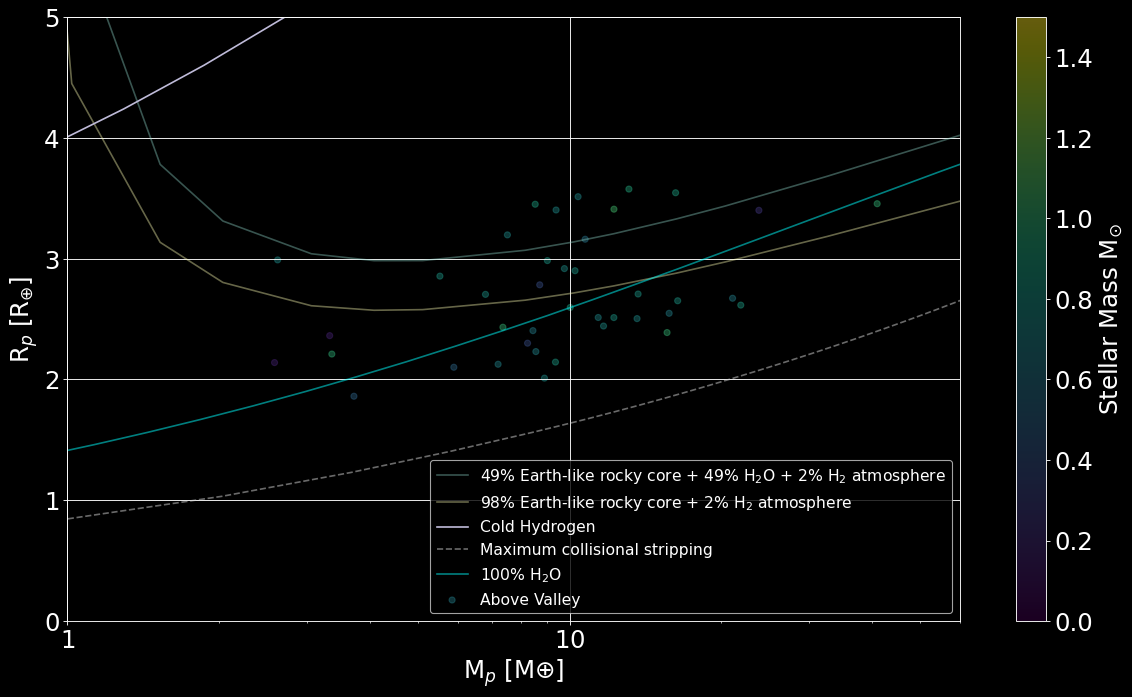

In [106]:
from matplotlib.pyplot import figure

figure(figsize=(18, 10), dpi=80)
#plt.plot(fe_100['Mass'], fe_100['Radius'], c='orange', label='100% Fe', alpha=0.4)
#plt.plot(earth['Mass'], earth['Radius'], c='green', label=f'32.5% Fe + 67.5% MgSiO$_3$', alpha=0.4)
#plt.plot(rock['Mass'], rock['Radius'], c='brown', label=f'100% MgSiO$_3$', alpha=0.4)

plt.plot(h2_2_earth_49_h2o_49_500k['Mass'], h2_2_earth_49_h2o_49_500k['Radius'], linestyle='-',
             label=f'49% Earth-like rocky core + 49% H$_2$O + 2% H$_2$ atmosphere', alpha=0.4)
plt.plot(h2_2_earth_98_500k['Mass'], h2_2_earth_98_500k['Radius'], linestyle='-',
             label=f'98% Earth-like rocky core + 2% H$_2$ atmosphere', alpha=0.4)
plt.plot(h_cold['Mass'], h_cold['Radius'], label  = 'Cold Hydrogen')
plt.plot(max_coll['Mass'], max_coll['Radius'], linestyle='--', c='lightgrey', label='Maximum collisional stripping',
             alpha=0.5)
plt.plot(h2o_100_500k['Mass'], h2o_100_500k['Radius'], linestyle='-', c='cyan', label=f'100% H$_2$O', alpha=0.5)


plt.grid(True)
plt.scatter(df_above['mp_new'], df_above['rp_1'], s=30, c=df_above['massfin_gaia'], alpha=0.4, marker='o', label='Above Valley')
plt.clim(0,1.5)
plt.colorbar(label=r'Stellar Mass M$_{\odot}$')
plt.legend()

plt.xlim(1, 60)
plt.ylim(0, 5)


plt.xlabel(r'M$_p$ [M${\oplus}$]')
plt.ylabel(r'R$_p$ [R$_{\oplus}$]')
plt.xscale('log')
# plt.yscale('log')
plt.legend()

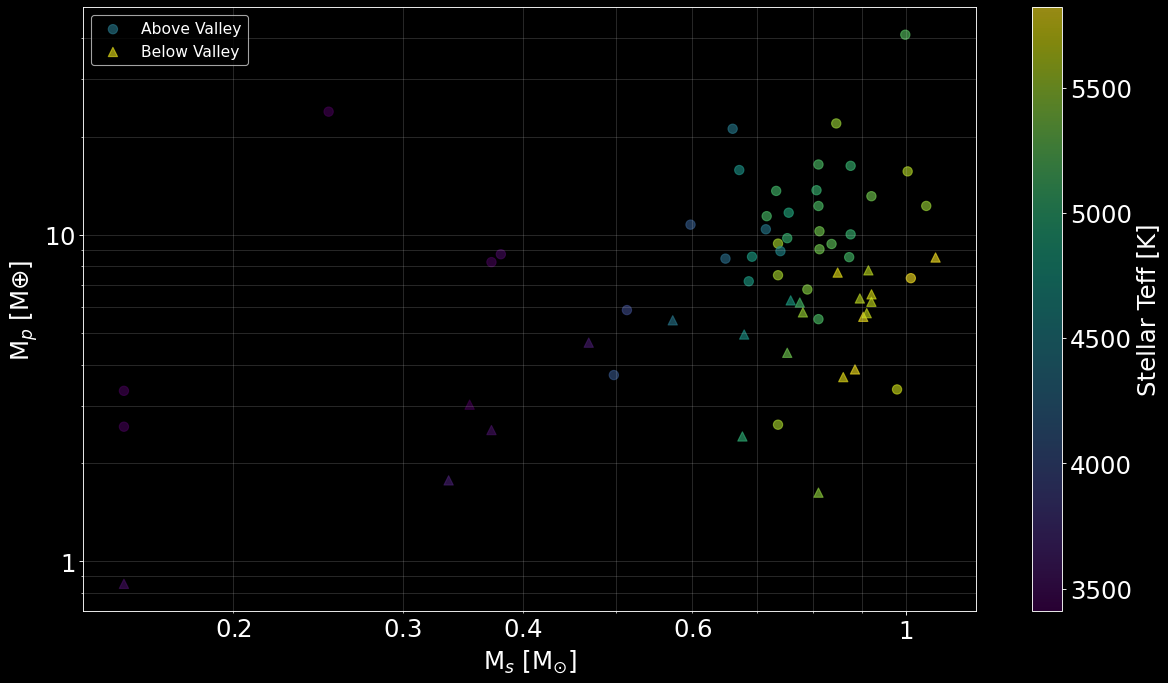

In [104]:
figure(figsize=(18, 10), dpi=80)

plt.grid(True, which='both', alpha=0.2, color='lightgrey')


plt.scatter(df_above['massfin_gaia'], df_above['mp_new'], s=70, c=df_above['Teff_gaia'], alpha=0.6, marker='o', label='Above Valley')
plt.scatter(df_below['massfin_gaia'], df_below['mp_new'], s=70, c=df_below['Teff_gaia'], alpha=0.6, marker='^', label='Below Valley')

#plt.clim(0,1.5)
plt.colorbar(label=r'Stellar Teff [K]')
plt.legend()

#plt.xlim(0.1, 60)
#plt.ylim(0, 5)


plt.ylabel(r'M$_p$ [M${\oplus}$]')
plt.xlabel(r'M$_{s}$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


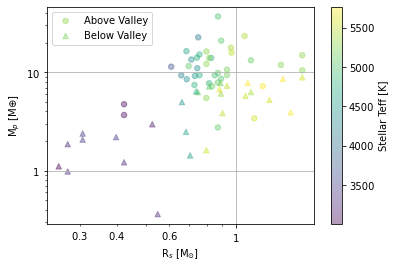

In [61]:
plt.legend()
plt.grid(True)
plt.scatter(df_above['radPhot'], df_above['mp_new'], s=30, c=df_above['Teff_bg'], alpha=0.4, marker='o',
            label='Above Valley')
plt.scatter(df_below['radPhot'], df_below['mp_new'], s=30, c=df_below['Teff_bg'], alpha=0.4, marker='^',
            label='Below Valley')

#plt.clim(0,1.5)
plt.colorbar(label=r'Stellar Teff [K]')
plt.legend()

#plt.xlim(0.1, 60)
#plt.ylim(0, 5)


plt.ylabel(r'M$_p$ [M${\oplus}$]')
plt.xlabel(r'R$_{s}$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


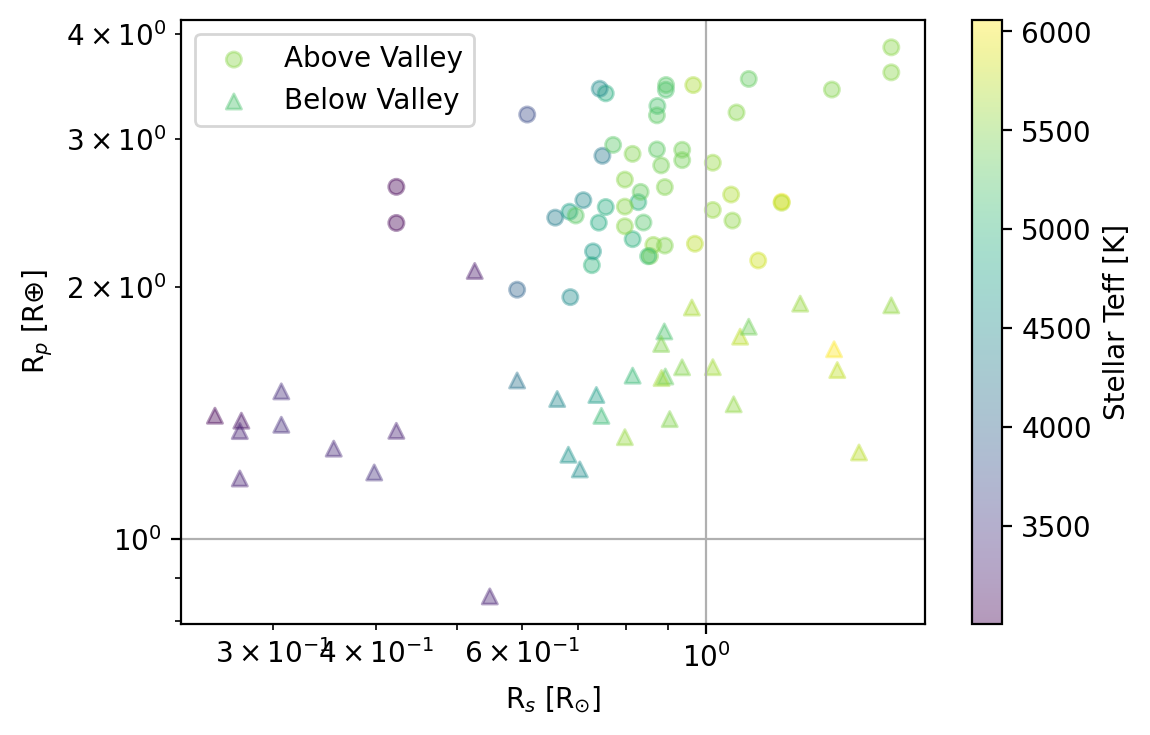

In [127]:
plt.legend()
plt.grid(True)
plt.scatter(df_above['radPhot'], df_above['rp_new'], s=30, c=df_above['Teff_bg'], alpha=0.4, marker='o',
            label='Above Valley')
plt.scatter(df_below['radPhot'], df_below['rp_new'], s=30, c=df_below['Teff_bg'], alpha=0.4, marker='^',
            label='Below Valley')

#plt.clim(0,1.5)
plt.colorbar(label=r'Stellar Teff [K]')
plt.legend()

#plt.xlim(0.1, 60)
#plt.ylim(0, 5)


plt.ylabel(r'R$_p$ [R${\oplus}$]')
plt.xlabel(r'R$_{s}$ [R$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend()